<a href="https://colab.research.google.com/github/lonnie-nguyen/pratt_data_analysis/blob/main/pratt_seq_logo_unaligned_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started
Detailed user manual can be found [here](https://drive.google.com/file/d/1_oCSprvBQt3TdIfQ0sHbT_CLdKBKVsCw/view?usp=sharing).
1. Upload the file to be analyzed (this file name must match the variable _file_name_ in SETUP)
    - Upload file(s) by clicking on the _**Files icon**_ located on the far left menu and selecting the _**Upload to session storage icon**_ (looks like a piece of paper with an arrow)
    - Files must be uploaded for each session (files are not saved)
2. Fill out parameters in SETUP form
3. Navigate to **Runtime > Run all**
    - To re-run code on the same file: **Runtime > Restart and run all**
    - To run code on a new file, upload file, update _file_name_, and then **Runtime > Restart and run all**
4. Disconnect runtime when notebook is not running: **Runtime > Manage sessions** and terminate the notebook


This notebook uses the Python package Logomaker to generate sequence logos. The package is also used to calculate the Position Probability Matrices (PPM), Position Weight Matrices (PWM), and Information Content Matrices (IC).

## Links for Logomaker
* Github: https://github.com/jbkinney/logomaker
* Documentation: https://logomaker.readthedocs.io/en/latest/
* Article: https://academic.oup.com/bioinformatics/article/36/7/2272/5671693




In [ ]:
# The following code will not work when viewing this notebook in a Jupyter environement.

#@title SETUP { display-mode: "form" }

#@markdown ### Enter complete Pratt file name to analyze:
file_name = '' #@param {type:"string"}

#@markdown ### Set number of flanking positions to observe:
# pos = 0 #@param {type:"integer", min:0, max:10, step:1}
positions = 3 #@param{type:"slider", min:0, max:10, step:1}

#@markdown ### Select matrices and sequence logos to output:
#@markdown Position Frequency
pfm = False #@param {type:"boolean"}
logo_pfm = False #@param {type:"boolean"}
#@markdown Position Probabiity
ppm = False #@param {type:"boolean"}
logo_ppm = False #@param {type:"boolean"}
#@markdown Position Weight
pwm = False #@param {type:"boolean"}
logo_pwm = False #@param {type:"boolean"}
#@markdown Information Content
icm = False #@param {type:"boolean"}
logo_icm = False #@param {type:"boolean"}

#@markdown ### Optional:
#@markdown Normalize PPM values or Center PWM values (default is False)
norm_ppm = False #@param ["False", "True"] {type: "raw"}
cent_pwm = False #@param ["False", "True"] {type: "raw"}

In [ ]:
!pip install logomaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logomaker as lm
import scipy.stats as st

# ---------------------------------------------
# Global data structures
# ---------------------------------------------
obs_freq = []
flank1_seq_list = []
flank2_seq_list = []
pattern_seq_list = []
x_axis = []

# Function Definitions

## Pad Sequences

For each pattern block, all sequences must be the same length and aligned to get the correct amino acid frequencies per position. The function `pad_sequence()` left pads the strings in `flank1_seq_list` and right pads the strings in `flank2_seq_list` with `*`. After padding, the sequences are aligned and concatenated then added to the list `combined_sequences` using Python list comprehension. A list of numbers `x_axis` is created to be used for the corresponding sequence logo.

The images below are used as illustrative examples:

From 
<img src='https://drive.google.com/uc?export=view&id=1UqvQImaZr_LlTwCzD6Zt4VWkQNBJ3btS' width=150px> 
To 
<img src='https://drive.google.com/uc?export=view&id=12FIIB-VdaG0R2t8hcWXGjC1vAbF6NiOB' width=150px>

In [ ]:
def pad_sequence(seq_list, direction, positions):
  padded = []

  if positions == 0:
    if direction == 'left':
      return [''] * len(seq_list)
    else:
      x_axis.extend([i for i in range(len(pattern_seq_list[0]))])
      return [''] * len(seq_list)
  elif positions > len(max(seq_list, key = len)):
    max_len =  len(max(seq_list, key = len))
  else:
    max_len = positions

  if direction == 'left':
    padded = [seq[-positions:].upper() if len(seq[-positions:]) == max_len 
              else seq.rjust(len(seq) + (max_len - len(seq)), '*').upper() 
              for seq in seq_list]
    x_axis.extend([i - len(padded[0]) for i in range(len(padded[0]))])
  else:
    padded = [seq[:positions].upper() if len(seq[:positions]) == max_len 
              else seq.ljust(len(seq) + (max_len - len(seq)), '*').upper() 
              for seq in seq_list]
    x_axis.extend([i for i in range(len(pattern_seq_list[0] + padded[0]))])

  return padded

## Create Matrices

Before sequence logos for sequence alignments found by Pratt can be generated, different matrices need to be calculated for each block of sequence alignments:

* Postion Frequency Matirx (PFM)
* Position Probability Matrix (PPM)
* Position Weight Matrix (PWM)
* Information Content Matrix (ICM)

### PFM

The function `frequency_matrix()` creates a Pandas DataFrame (matrix) with dimensions $m * n$ where $m = \text{length of the sequence}$ and $n = 20$ (for $20$ amino acids). The DataFrame is initialized with values of $0$. Then frequencies are added up for each amino acid at each position and multiplied by a corresponding value from the list `obs_freq`.

> **NOTE:**
>
> The character `*` is not counted in the function `frequency_matrix()`.

In [ ]:
def frequency_matrix(combined_sequences: list):
  char_array = np.array([np.array(list(seq)) for seq in combined_sequences])
  columns = [c for c in 'ACDEFGHIKLMNPQRSTVWY']
  index = list(range(len(combined_sequences[0])))
  counts_df = pd.DataFrame(data=0, columns=columns, index=index)
  counts = np.array(obs_freq)
  # Calculate frequencies of each amino acid at each position
  for aa in columns:
    temp_matrix = (char_array == aa).astype(float) * counts[:, np.newaxis]
    counts_df.loc[:, aa] = temp_matrix.sum(axis=0).T
  return counts_df

### PPM

The function `probability_matrix()` creates a DataFrame (matrix) using the probabilities of each amino acid at each position from the PFM. By default, Logomaker sets $pseudocount = 1$ to correct for values where the $frequency = 0$. 

Logomaker uses the following formula (found in file **matrix.py** under the function `transform_matrix()`) to calculate the PPM:

\begin{align}
        PPM_{ic} = \frac{PFM_{ic} + pseudocount}{PFM_{i} + 20 * pseudocount} \\[1em]
    \end{align}

* Where $pseudocount ≥ 0$.
* Notation:
  * $i = \text{position}$
  * $c = \text{character}$

In [ ]:
def probability_matrix(counts_df, pseudocount = 1):
  # Use logomaker for PPM w/ pseudocount = 1 if no value is given
  prob_df = lm.transform_matrix(counts_df, 
                              from_type='counts', 
                              to_type='probability',
                              pseudocount=pseudocount)
  return prob_df

### PWM

The function `weight_matrix()` creates a DataFrame (matrix) using the values from the PPM with $pseudocount = 1$. The values of a PWM are used to score how well a sequence matches a motif by adding up the values for the amino acids at specific positions. 

By default, Logomaker assumes a uniform distribution background probability of $1/20 = 0.05$ for each amino acid. The background can also be user submitted as a list. This notebook uses the following non-uniform background probabilities from Amino Acid Freq in unselected library:

Amino Acid | Frequency | Amino Acid | Frequency
:--- | :---: | :---: | ---:
A | 0.06384185843169986 | M | 0.029787170621199476 
C | 0.010099956281546838 | N | 0.05246413099638329 
D | 0.04909383569810421 | P | 0.0795020070744406 
E | 0.02797981002344899 | Q | 0.031751520209848574 
F | 0.03694308652279321 | R | 0.0499791343746274 
G | 0.06389253209331902 | S | 0.10975318945987839 
H | 0.04279738484161997 | T | 0.0749006398791781 
I | 0.037401136679782204 | V | 0.05928917769564008 
K | 0.027565478319621636 | W | 0.026045268471046462
L | 0.08509002026946465 | Y | 0.04182266205635706

Logomaker uses the following formula to calculate the PWM:

\begin{align}
        PWM_{ic} = \log_2\left(\frac{PPM_{ic}}{background_{ic}}\right) \\[1em]
    \end{align}

* Notation:
  * $i = \text{position}$
  * $c = \text{character}$

In [ ]:
background = [0.06384185843169986, 0.010099956281546838, 0.04909383569810421, 0.02797981002344899, 
       0.03694308652279321, 0.06389253209331902, 0.04279738484161997, 0.037401136679782204, 
       0.027565478319621636, 0.08509002026946465, 0.029787170621199476, 0.05246413099638329, 
       0.0795020070744406, 0.031751520209848574, 0.0499791343746274, 0.10975318945987839, 
       0.0749006398791781, 0.05928917769564008, 0.026045268471046462, 0.04182266205635706]
              
def weight_matrix(prob_df): 
  # Use logomaker to get PWM w/ a non-uniform background
  weight_df = lm.transform_matrix(prob_df, 
                              from_type='probability', 
                              to_type='weight',
                              background=background)
  return weight_df

### ICM

The function `info_content_matrix()` creates a DataFrame (matrix) using the values from the PPM with $pseudocount = 0$. The information (values) for each amino acid at a specific position indicate the level of conservation or relative entropy at a position.

Logomaker uses the following formula to calculate the ICM:

\begin{align}
        ICM_{ic} = PPM_{ic} * \sum_i{PPM_{id}} * \log_2\left(\frac{PPM_{id}}{PWM_{id}}\right) \\[1em]
    \end{align}

* Notation:
  * $i = \text{position}$
  * $c, d = \text{character}$

In [ ]:
def info_content_matrix(prob_df):
  # Use logomaker to get Information Content
  info_df = lm.transform_matrix(prob_df,
                                from_type='probability',
                                to_type='information',
                                background=background)
  return info_df

## Matrix Transformations

Use this function to center values of PWM with `transform_type = 'center'` or normalize values of PPM with `transform_type = 'normalize'` before graphing.

In [ ]:
def transform_matrix(df, transform_type):
  if transform_type == 'center':
    return lm.transform_matrix(df, center_values=True)
  else:
    return lm.transform_matrix(df, normalize_values=True)

## Display Matrix

In [ ]:
def display_matrix(df, title):
  # Label DataFrame table
  df.index.names = ['Position']
  df.columns.names = ['Amino Acid']
  pd.set_option('display.max_columns', None)
  print(title)
  display(df)

## Display Sequence Logo

In [ ]:
def display_sequence_logo(df, graph_type, pattern):
  logo = lm.Logo(df,
                color_scheme='skylign_protein',
                center_values=False,
                shade_below=0.5,
                fade_below=0.5,
                figsize=(15, 8))
  logo.ax.set_xticks(range(len(df)))
  logo.ax.set_xticklabels('%d'%x for x in x_axis)
  if graph_type == 'PFM':
    y = 'frequency'
  elif graph_type == 'PPM':
    y = 'probability'
  elif graph_type == 'PWM':
    y = '$\log_2$ enrichment'
  elif graph_type == 'ICM':
    y = 'bits'
  else:
    y = ''
  logo.ax.set_ylabel('{}'.format(y), fontsize=14)
  logo.ax.set_xlabel('position', fontsize=14)
  logo.ax.set_title('{} Sequence Logo for Pattern {}'.format(graph_type, pattern), fontsize=14)
  plt.show()

## Display Output

In [ ]:
def display_output(freq_df, prob_df, weight_df, info_df, seq_pattern):
  if pfm:
    display_matrix(freq_df, 'Position Frequency Matrix')
  if logo_pfm:
    display_sequence_logo(freq_df, 'PFM', seq_pattern)
  if ppm:
    display_matrix(prob_df, 'Position Probability Matrix')
  if logo_ppm:
    display_sequence_logo(prob_df, 'PPM', seq_pattern)
  if pwm:
    display_matrix(weight_df, 'Position Weight Matrix')
  if logo_pwm:
    display_sequence_logo(weight_df, 'PWM', seq_pattern)
  if icm:
    display_matrix(info_df, 'Information Content Matrix')
  if logo_icm:
    display_sequence_logo(info_df, 'ICM', seq_pattern)

## Statistical Significance

### $\chi^2$ Critical Value

The function `chi_square_critical_val()` finds the $\chi^2$ Critical Value. If the $\chi^2 \text{ Test Statistic} ≥ \chi^2 \text{ Critical Value}$, than the test results have statistical significance.  The $χ^2$ Critical Value is found using the below function from scipy package:

```python
scipy.stats.chi2.ppf(1-alpha, df)
```
where $df = N - 1$ and the corrected $\alpha$ value is found by:

\begin{align}
        α = 1 - [(1 - α_{0})^\frac{1}{N}] ≈ \frac{α_{0}}{N} \\[1em]
    \end{align}
* Significance Level $\alpha_{0} = 0.05$
* $N = \text{length of sequence}$


In [ ]:
def chi_square_critical_val(sequence: string):
  alpha_0 = 0.05
  df = 20 - 1
  N = len(sequence)
  # alpha = 1 - (1 - alpha_0)**(1/N)
  alpha = alpha_0 / N
  print('X^2 Critical Value = {}'.format(st.chi2.ppf(1-alpha, df)))

### 1-Way $\chi^2$ test

This function performs $\chi^2$ test on each row (position) of the PFM matrix. A table is created for the $\chi^2$ test statistic and p-value for each position. The $\chi^2$ and p-value are found using the below function from scipy:

```python
scipy.stats.chisquare(obs_freq, exp_freq)
```

The formula for $\chi^2$ is:

\begin{align}
        χ^2 = \sum \frac{(\text{Observed - Expected})^2}{\text{Expected}}\\[1em]
    \end{align}

The p-values are sorted in ascending order to a list and critical p-values for each $i$th rank are calculated und using Benjamini-Hochberg (BH) and Benjamini-Yekutieli(Y) procedures. 

\begin{align}
        P_{BH_{i}} = \frac{α * i}{\text{N}} \\[1em]
    \end{align}
* $\alpha = 0.05$
* $i = \text{rank of the p-value}$ 
* $N = \text{length of sequence}$
\begin{align}
        P_{BY_{i}} = \frac{P_{BH_{i}}}{\sum_{i=1}^N \frac{1}{i}} \\[1em]
    \end{align}

The table with sorted p-values and corresponding most and least likely to occur amino acids is displayed.

In [ ]:
def chi_square_test(counts_df):
  exp = background
  test_data = []

  for i in range(len(counts_df)):
    exp_freq = [num * sum(counts_df.values[i]) for num in exp]
    obs_freq = counts_df.values[i]
    chi, p = st.chisquare(obs_freq, exp_freq)
    test_data.append([chi, p])

  max_val_idx = weight.idxmax(axis=1)
  max_val = weight.max(axis=1)
  min_val_idx = weight.idxmin(axis=1)
  min_val = weight.min(axis=1)
  test_df = pd.DataFrame(np.column_stack([x_axis, test_data, max_val_idx.tolist(), max_val.tolist(), min_val_idx.tolist(), min_val.tolist()]),
                         columns=['Position', 'X^2', 'p-value', 'AAmax', 'PWMSmax', 'AAmin', 'PWMSmin'])

  # Find Critical p-values using BH and BY procedure
  alpha = 0.05
  N = len(combined_sequences[0])
  arr = test_df['p-value'].tolist()
  arr.sort()
  bh_list = [(alpha * (i + 1)) / N for i in range(len(arr))]
  summation = sum([(1 / (i + 1)) for i in range(N)])
  by_list = [bh / summation for bh in bh_list]  

  # Sort p-values & display DataFrame
  copy_df = test_df.copy()
  copy_df['p-value'] = copy_df['p-value'].astype('float')
  sorted = (copy_df.sort_values(by='p-value')
                      .reset_index(drop=False))
  # Add critical p-values columns
  sorted.insert(4, 'Critical pBH', bh_list, True)
  sorted.insert(5, 'Critical pBY', by_list, True)
  print('Chi Square Tests')
  display(sorted)

# Main Python Script
The following script takes an uploaded Pratt sequence data file as input and parses the file line by line. Each line is broken up into an array of tokens which are processed according to the length of the array. The script identifies pattern sequence blocks in the Pratt file and outputs the user selected matrices for **frequency**, **probability**, **weight**, or **information content** (**relative entropy**) using the function `display_output()`. Sequence logos can also be displayed through the fucntion `display_output()`.

----------------------------------------------------------------------
A Pattern: S-S-E-F-R-[AGLV]
Information Content Matrix


Amino Acid         A    C         D         E         F         G    H  \
Position                                                                 
0           0.452515  0.0  0.079856  0.000000  0.079856  0.000000  0.0   
1           0.000000  0.0  0.063903  0.000000  0.063903  0.042602  0.0   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.0   
5           0.000000  0.0  0.000000  0.000000  4.758552  0.000000  0.0   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.449594  0.0  0.000000  0.000000  0.000000  0.474571  0.0   
8           0.000000  0.0  0.264811  0.000000  0.000000  0.000000  0.0   
9           0.000000  0.0  0.070092  0.105139  0.000000  1.016341  0.0   

Amino Acid         I    K         L    M         N         P         Q  \
Position                                                                 
0           0.079856  0.0  0.745318  0.0  0.000000  0.000000  0.000000   
1           0.063903  0.0  0.127805  0.0  0.213009  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.299729  0.0  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.093463  0.0  0.186925  0.218079  0.000000   
9           0.000000  0.0  0.000000  0.0  0.105139  0.000000  0.105139   

Amino Acid         R         S         T         V         W    Y  
Position                                                           
0           0.079856  0.079856  0.000000  0.000000  0.053237  0.0  
1           0.000000  0.894636  0.063903  0.000000  0.000000  0.0  
2           0.000000  3.187665  0.000000  0.000000  0.000000  0.0  
3           0.000000  3.187665  0.000000  0.000000  0.000000  0.0  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.0  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.0  
7           0.000000  0.000000  0.000000  0.824255  0.000000  0.0  
8           0.046731  0.077885  0.249233  0.046731  0.000000  0.0  
9           0.000000  0.105139  0.455601  0.000000  0.000000  0.0

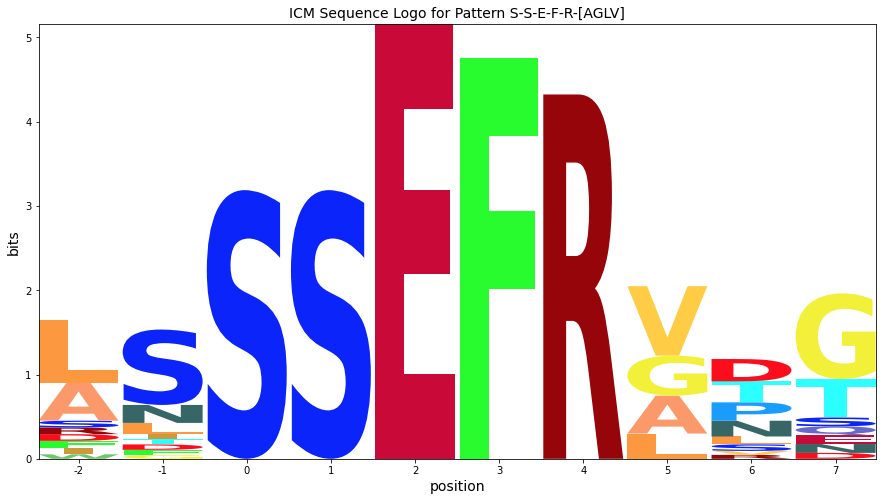

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2   2848.684659090909   0.000000e+00         0.005   
1      5        3  2137.6304564159113   0.000000e+00         0.010   
2      6        4  1558.6846782370135   0.000000e+00         0.015   
3      2        0   665.1309071156982  8.693822e-129         0.020   
4      3        1   665.1309071156982  8.693822e-129         0.025   
5      7        5   293.4278033404802   4.436945e-51         0.030   
6      9        7  236.12832606729032   1.967543e-39         0.035   
7      1       -1   195.3876451933957   2.808334e-31         0.040   
8      0       -2   177.0937563153499   1.154004e-27         0.045   
9      8        6  127.91269792717776   3.616505e-18         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.862084112185676     S  -3.4847601125950143  
1      0.003414     F   4.461165873438733     S  -3.4847601125950143  
2      0.005121     R   4.025144364605229     S  -3.4847601125950143  
3      0.006828     S  2.8902793187519107     L   -3.117559088431946  
4      0.008535     S  2.8902793187519107     L   -3.117559088431946  
5      0.010243     V   2.491124901478307     S  -3.4847601125950143  
6      0.011950     G   2.627171956441093     L   -2.693061259904037  
7      0.013657     S   2.090368028021566     P  -2.8706970488150216  
8      0.015364     L   2.055295244049037     P  -2.7046870973760924  
9      0.017071     D  1.9332768017211888     G  -2.6167536264449955

----------------------------------------------------------------------
B Pattern: S-A-E-F-R-[AGPST]
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.252020  0.0  0.324026  0.00000  0.000000  0.612049  0.000000   
1           0.000000  0.0  0.223196  0.00000  0.000000  0.127541  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           3.969354  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.00000  4.758552  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
7           0.308389  0.0  0.000000  0.00000  0.000000  0.179893  0.000000   
8           0.000000  0.0  0.000000  0.00000  0.000000  0.252774  0.000000   
9           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.279864   

Amino Acid         I    K         L         M         N         P         Q  \
Position                                                                      
0           0.072006  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
1           0.127541  0.0  0.000000  0.000000  0.000000  0.605819  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.179893  0.000000   
8           0.000000  0.0  0.000000  0.112344  0.000000  0.056172  0.056172   
9           0.000000  0.0  0.199903  0.000000  0.439786  0.000000  0.199903   

Amino Acid        R         S         T         V    W         Y  
Position                                                          
0           0.00000  0.072006  0.000000  0.108009  0.0  0.252020  
1           0.00000  0.191311  0.223196  0.000000  0.0  0.000000  
2           0.00000  3.187665  0.000000  0.000000  0.0  0.000000  
3           0.00000  0.000000  0.000000  0.000000  0.0  0.000000  
4           0.00000  0.000000  0.000000  0.000000  0.0  0.000000  
5           0.00000  0.000000  0.000000  0.000000  0.0  0.000000  
6           4.32253  0.000000  0.000000  0.000000  0.0  0.000000  
7           0.00000  0.745273  0.128495  0.000000  0.0  0.000000  
8           0.00000  0.224688  0.308946  0.112344  0.0  0.084258  
9           0.00000  0.079961  0.000000  0.239883  0.0  0.159922

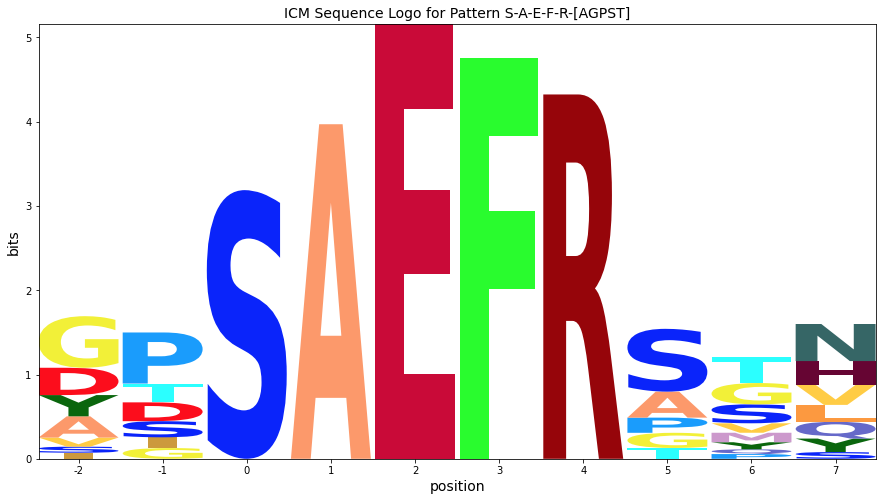

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2   2084.403409090909   0.000000e+00         0.005   
1      5        3  1564.1198461579843   0.000000e+00         0.010   
2      6        4  1140.5009840758635  5.009723e-230         0.015   
3      3        1    879.822265108244  2.235968e-174         0.020   
4      2        0   486.6811515480718   3.468297e-91         0.025   
5      7        5  133.92076434128265   2.631674e-19         0.030   
6      0       -2   131.8819039343174   6.416126e-19         0.035   
7      1       -1  106.17613210624879   4.018120e-14         0.040   
8      9        7    98.9661083800335   8.238107e-13         0.045   
9      8        6   65.48482271041843   5.091677e-07         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.768279265485771     S    -3.13426286551088  
1      0.003414     F   4.367361026738828     S   -3.134262865510881  
2      0.005121     R  3.9313395179053234     S   -3.134262865510881  
3      0.006828     A  3.5781627835345273     S    -3.13426286551088  
4      0.008535     S  2.7964744720520054     L  -2.7670618413478127  
5      0.010243     S  1.7726277300976372     L  -2.7670618413478127  
6      0.011950     G     2.0720446852607     L   -2.511222936918224  
7      0.013657     P   1.908703811671581     L   -2.511222936918223  
8      0.015364     N  1.9305966858099026     P  -2.2540256883665273  
9      0.017071     M   1.413813267605688     L   -2.422413669960367

----------------------------------------------------------------------
C Pattern: S-[DS]-A-E-[FHWY]-R
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.000000  0.910565  0.124168  0.124168  0.000000  0.000000   
1           0.000000  0.000000  0.000000  0.000000  0.000000  0.125965   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.873556  0.000000  0.000000  0.000000   
4           3.969354  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.943257  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.269078  0.000000  0.134539  0.000000  0.000000  0.067269   
9           0.000000  0.000000  0.112140  0.000000  0.112140  0.000000   

Amino Acid         H         I         K         L         M         N  \
Position                                                                 
0           0.165557  0.000000  0.206947  0.124168  0.124168  0.248336   
1           0.075579  0.000000  0.100772  0.151159  0.554248  0.176352   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.471629  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.112116  0.000000  0.156962  0.044846  0.067269   
9           0.000000  0.560700  0.000000  0.000000  0.000000  0.000000   

Amino Acid         P    Q         R         S         T         V        W  \
Position                                                                     
0           0.124168  0.0  0.082779  0.000000  0.000000  0.000000  0.00000   
1           0.125965  0.0  0.000000  0.075579  0.050386  0.075579  0.00000   
2           0.000000  0.0  0.000000  3.187665  0.000000  0.000000  0.00000   
3           0.000000  0.0  0.000000  1.782054  0.000000  0.000000  0.00000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.00000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.00000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.15721   
7           0.000000  0.0  4.322530  0.000000  0.000000  0.000000  0.00000   
8           0.000000  0.0  0.067269  0.000000  0.067269  0.000000  0.00000   
9           0.000000  0.0  0.000000  0.616770  0.000000  0.000000  0.16821   

Amino Acid         Y  
Position              
0           0.124168  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           1.414886  
7           0.000000  
8           0.067269  
9           0.392490

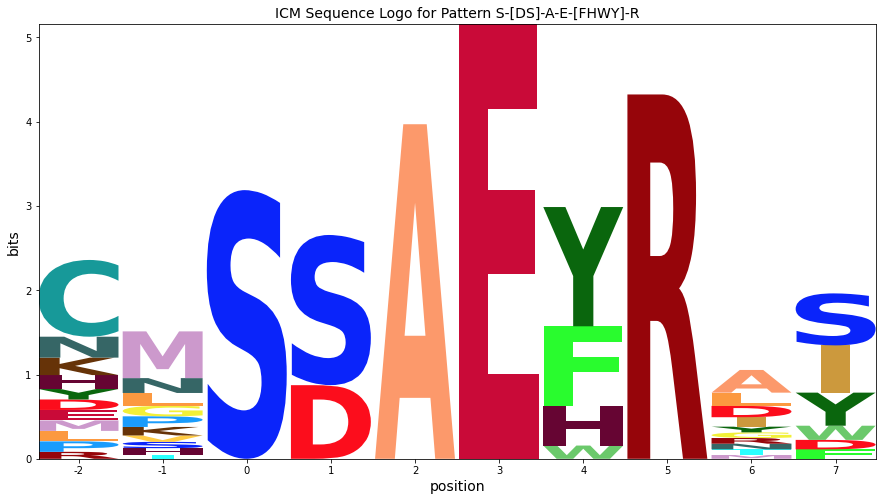

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2640.2443181818176   0.000000e+00         0.005   
1      7        5  1444.6345798294271  3.382950e-295         0.010   
2      4        2  1114.4415358037754  1.876627e-224         0.015   
3      0       -2   841.4087347451325  3.360851e-166         0.020   
4      2        0    616.462791960891  1.689467e-118         0.025   
5      6        4   589.2439676691761  9.377954e-113         0.030   
6      3        1  403.33355849228155   8.884106e-74         0.035   
7      1       -1  263.15553830739753   6.632889e-45         0.040   
8      9        7   121.6601794836823   5.423734e-17         0.045   
9      8        6   63.53775810696575   1.053116e-06         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.841294062783992     S  -3.3972972713446743  
1      0.003414     R   4.004354315203545     S   -3.397297271344675  
2      0.005121     A  3.6511775808327487     S  -3.3972972713446743  
3      0.006828     C   4.886282556964922     S   -3.079121311318421  
4      0.008535     S  2.8694892693502263     L   -3.030096247181607  
5      0.010243     Y  3.2040621607780957     S   -3.397297271344675  
6      0.011950     D   2.463791518419968     L   -3.030096247181607  
7      0.013657     M  3.2707989573878926     A  -2.3525745540283594  
8      0.015364     I   2.418845978320833     L   -2.226493459985111  
9      0.017071     A  1.6037040685423216     S   -2.878423961081292

----------------------------------------------------------------------
D Pattern: S-S-[AS]-E-[FHWY]-R
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.000000  0.548282  0.000000  0.074766  0.000000  1.096564   
1           0.263611  0.000000  0.000000  0.000000  0.000000  0.077533   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           1.319174  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  2.037543  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.038285  0.000000  0.000000  0.325422   
9           0.000000  0.000000  0.416022  0.000000  0.043792  0.000000   

Amino Acid         H         I         K         L         M         N  \
Position                                                                 
0           0.099688  0.124610  0.124610  0.074766  0.074766  0.099688   
1           0.000000  0.000000  0.062026  0.434183  0.341144  0.186079   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.103604  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.095712  0.095712  0.000000  0.076570  0.038285  0.057427   
9           0.000000  0.000000  0.000000  0.000000  0.109479  0.000000   

Amino Acid         P         Q         R         S         T         V  \
Position                                                                 
0           0.000000  0.000000  0.049844  0.000000  0.000000  0.000000   
1           0.108546  0.000000  0.000000  0.000000  0.000000  0.046520   
2           0.000000  0.000000  0.000000  3.187665  0.000000  0.000000   
3           0.000000  0.000000  0.000000  3.187665  0.000000  0.000000   
4           0.000000  0.000000  0.000000  1.267441  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  4.322530  0.000000  0.000000  0.000000   
8           0.000000  0.038285  0.000000  0.000000  0.057427  0.535989   
9           0.306542  0.000000  0.000000  0.175167  0.240855  0.000000   

Amino Acid         W         Y  
Position                        
0           0.000000  0.000000  
1           0.000000  0.000000  
2           0.000000  0.000000  
3           0.000000  0.000000  
4           0.000000  0.000000  
5           0.000000  0.000000  
6           0.069069  1.243247  
7           0.000000  0.000000  
8           0.000000  0.057427  
9           0.065688  0.065688

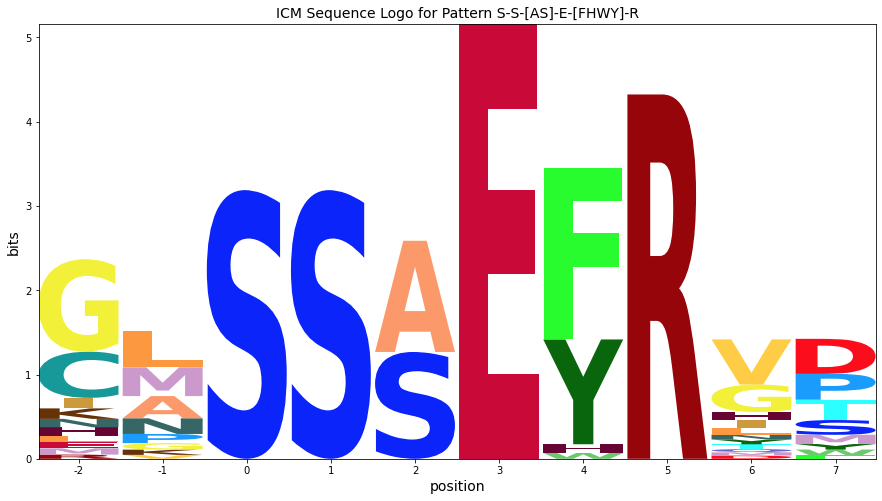

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3   3474.005681818182   0.000000e+00         0.005   
1      7        5  1900.8349734597716   0.000000e+00         0.010   
2      6        4  1155.7787613812047  2.699740e-233         0.015   
3      2        0   811.1352525801196  9.232477e-160         0.020   
4      3        1   811.1352525801196  9.232477e-160         0.025   
5      0       -2   760.6386664906626  4.941406e-149         0.030   
6      4        2   526.1765260689104   1.781046e-99         0.035   
7      1       -1  253.77320038509419   5.322617e-43         0.040   
8      8        6  196.75401676297162   1.503799e-31         0.045   
9      9        7  143.08493343005438   4.685071e-21         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.910790909953523     S   -3.719225366232037  
1      0.003414     R   4.073851162373076     S   -3.719225366232037  
2      0.005121     F   3.758551784063304     S   -3.719225366232037  
3      0.006828     S  2.9389861165197573     L   -3.352024342068969  
4      0.008535     S  2.9389861165197573     L   -3.352024342068969  
5      0.010243     C   4.307579046715449     S   -3.657824821567894  
6      0.011950     A   2.762902663391576     L  -3.3520243420689697  
7      0.013657     M  2.7100840029134137     S  -3.6949778199853607  
8      0.015364     V  2.3794795456493976     S  -3.3669236223011567  
9      0.017071     D  2.2608514597496927     L  -2.8545246825981527

----------------------------------------------------------------------
E Pattern: D-A-E-S-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G    H    I  \
Position                                                                      
0           0.280059  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
1           0.123454  0.0  0.041151  0.205757  0.000000  0.123454  0.0  0.0   
2           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.0  0.0   
3           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.0  0.0   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.070443  0.0  0.0   
8           0.000000  0.0  0.000000  0.000000  0.050144  0.200576  0.0  0.0   

Amino Acid    K         L         M         N         P    Q         R  \
Position                                                                 
0           0.0  0.186706  0.000000  0.037341  0.074682  0.0  0.205376   
1           0.0  0.329211  0.000000  0.041151  0.000000  0.0  0.000000   
2           0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
3           0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
4           0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
5           0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
6           0.0  0.000000  0.000000  0.000000  0.000000  0.0  4.322530   
7           0.0  0.000000  0.316992  0.316992  0.000000  0.0  0.070443   
8           0.0  0.300865  0.000000  0.000000  0.050144  0.0  0.075216   

Amino Acid         S         T         V         W         Y  
Position                                                      
0           0.037341  0.112023  0.074682  0.000000  0.074682  
1           0.082303  0.000000  0.082303  0.000000  0.267484  
2           0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  
5           3.187665  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.140885  0.070443  0.000000  0.140885  1.091860  
8           0.100288  0.000000  0.275793  0.000000  0.175504

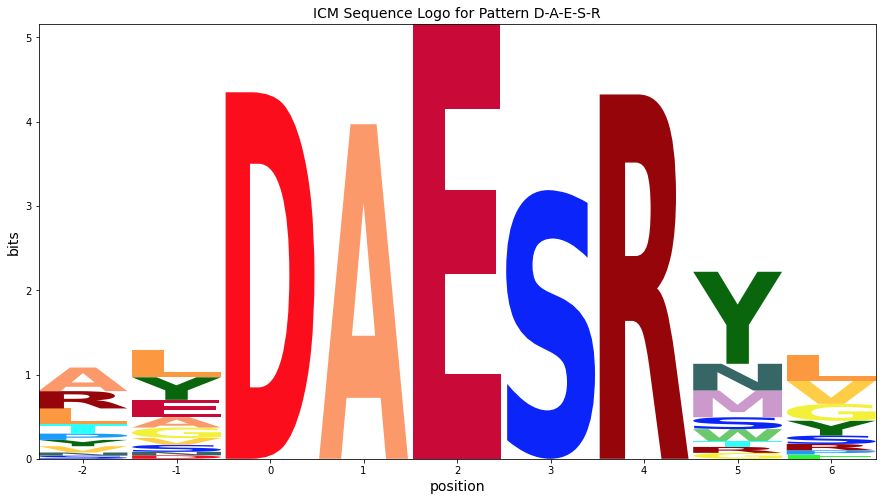

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2   2258.103693181817   0.000000e+00      0.005556   
1      2        0  1258.9951426836676  2.154813e-255      0.011111   
2      6        4  1235.5427327488521  2.273708e-250      0.016667   
3      3        1   953.1407872005975  5.289004e-190      0.022222   
4      5        3   527.2379141770778   1.065633e-99      0.027778   
5      7        5  384.57644081366215   7.027465e-70      0.033333   
6      1       -1  132.62158119248204   4.644678e-19      0.038889   
7      0       -2    89.7168746664362   3.723192e-11      0.044444   
8      8        6   81.42673998646845   1.054298e-09      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E  4.7944732060309985     S    -3.22172570676122  
1      0.003928     D   3.983317484220785     S    -3.22172570676122  
2      0.005891     R  3.9575334584505515     S   -3.221725706761221  
3      0.007855     A  3.6043567240797554     S    -3.22172570676122  
4      0.009819     S   2.822668412597233     L  -2.8545246825981527  
5      0.011783     Y  3.2045318645233776     L  -2.8201731778073755  
6      0.013747     E  2.2438622101006187     P   -2.722174524104933  
7      0.015710     A  1.6839513219967541     G   -2.317193344586088  
8      0.017674     V  1.5525254461424498     T  -2.3696463107418597

----------------------------------------------------------------------
F Pattern: S-A-E-Y-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.045298  0.0  0.000000  0.000000  0.120794  0.030198  0.000000   
1           0.026209  0.0  0.000000  0.039314  0.000000  0.026209  0.026209   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.036465  0.000000  0.200556  0.036465  0.127627   
8           0.000000  0.0  0.000000  0.099978  0.028565  0.057130  0.000000   

Amino Acid         I    K         L         M         N         P         Q  \
Position                                                                      
0           0.135893  0.0  0.075496  0.332183  0.120794  0.181191  0.060397   
1           0.000000  0.0  0.196568  0.000000  0.144150  0.052418  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.237021  0.0  0.164092  0.000000  0.054697  0.000000  0.054697   
8           0.000000  0.0  0.071413  0.057130  0.042848  0.157108  0.057130   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.030198  0.045298  0.045298  0.000000  0.000000  0.000000  
1           0.000000  0.471763  0.039314  0.065523  0.000000  0.000000  
2           0.000000  3.187665  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  4.579571  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.000000  0.000000  0.054697  0.072930  0.109394  0.036465  
8           0.000000  0.199955  0.000000  0.071413  0.028565  0.000000

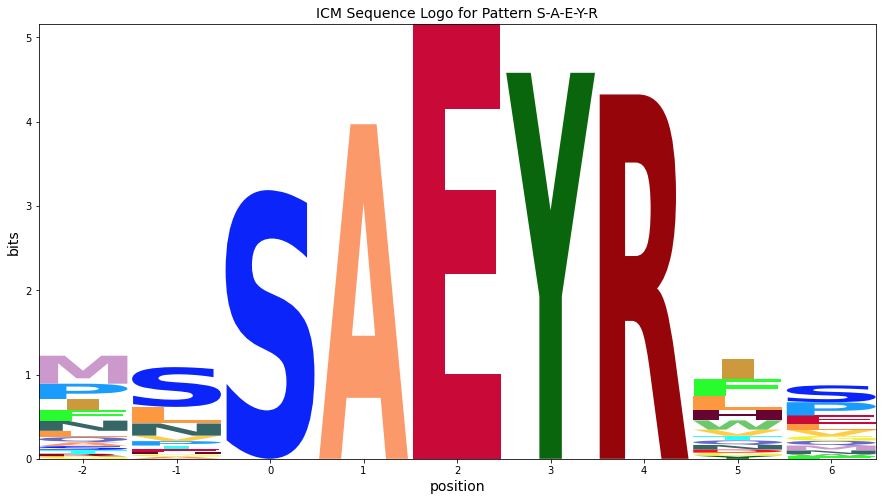

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  3404.5255681818185   0.000000e+00      0.005556   
1      5        3  2245.2272165732206   0.000000e+00      0.011111   
2      6        4  1862.8182739905767   0.000000e+00      0.016667   
3      3        1  1437.0430330101315  1.439980e-293      0.022222   
4      2        0   794.9125475285172  2.592056e-156      0.027778   
5      0       -2  220.99208383519422   2.179861e-36      0.033333   
6      1       -1  134.37791678699114   2.154446e-19      0.038889   
7      7        5  125.11850166746255   1.216013e-17      0.044444   
8      8        6   61.94110178387134   1.900784e-06      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.906183593528015     S    -3.69497781998536  
1      0.003928     Y    4.32628486658807     S  -3.6949778199853607  
2      0.005891     R   4.069243845947568     S    -3.69497781998536  
3      0.007855     A   3.716067111576771     S    -3.69497781998536  
4      0.009819     S  2.9343788000942492     L  -3.3277767958222917  
5      0.011783     M    2.93451556952346     V  -2.5821240805523322  
6      0.013747     S  1.7106180678222123     R   -2.363970251953419  
7      0.015710     I  2.1387380591280976     S   -3.221725706761221  
8      0.017674     E  1.8196200199256207     T  -2.6009718568483158

----------------------------------------------------------------------
G Pattern: G-G-G-S-A
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.000000  0.031344  0.094033  0.047017  0.000000   
1           0.086391  0.0  0.021598  0.000000  0.075592  0.032397  0.064793   
2           0.000000  0.0  0.000000  0.000000  0.000000  3.968209  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  3.968209  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  3.968209  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  4.123923  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

Amino Acid    I    K         L         M         N         P    Q         R  \
Position                                                                      
0           0.0  0.0  0.203739  0.000000  0.125378  0.094033  0.0  0.000000   
1           0.0  0.0  0.032397  0.043196  0.021598  0.043196  0.0  0.075592   
2           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
3           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
4           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
5           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
6           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
7           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
8           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   

Amino Acid         S         T         V         W         Y  
Position                                                      
0           0.219411  0.078361  0.000000  0.062689  0.000000  
1           0.064793  0.161984  0.000000  0.000000  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  
5           3.187665  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.000000  0.000000  0.458214  0.000000  0.000000  
8           0.000000  2.730417  0.000000  0.000000  0.511953

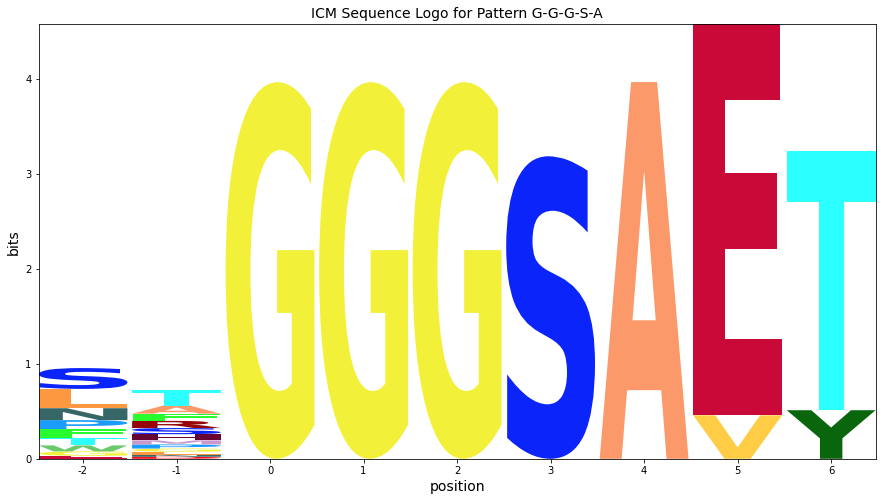

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      6        4   982.4681960375391  2.928505e-196      0.005556   
1      2        0   981.6358546902213  4.408230e-196      0.011111   
2      3        1   981.6358546902213  4.408230e-196      0.016667   
3      4        2   981.6358546902213  4.408230e-196      0.022222   
4      7        5   843.5433260489145  1.181025e-166      0.027778   
5      5        3     543.46061922868  4.133672e-103      0.033333   
6      8        6  172.21345567021166   1.047291e-26      0.038889   
7      0       -2   64.42690157590623   7.563631e-07      0.044444   
8      1       -1   61.73372928356538   2.051537e-06      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     A   3.613872886260614     S   -3.255278266472247  
1      0.003928     G  3.6127282196777717     S   -3.255278266472247  
2      0.005891     G  3.6127282196777717     S   -3.255278266472247  
3      0.007855     G  3.6127282196777717     S   -3.255278266472247  
4      0.009819     E   4.322968755093125     S  -2.4561909603982444  
5      0.011783     S   2.832184574778092     L   -2.888077242309179  
6      0.013747     T  2.5409387684244003     S   -2.097736989485768  
7      0.015710     W  1.2449129735100746     A   -2.370496462025623  
8      0.017674     F   1.315608288214575     V  -2.3668560936492655

----------------------------------------------------------------------
H Pattern: D-A-E-L-R
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.034941  0.000000  0.041929  0.000000  0.000000  0.013976   
1           0.069776  0.026166  0.052332  0.000000  0.156996  0.000000   
2           0.000000  0.000000  4.348314  0.000000  0.000000  0.000000   
3           3.969354  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.061837  0.000000  0.000000  0.092755  0.020612  0.041224   
8           0.000000  0.000000  0.222549  0.000000  0.127171  0.063585   

Amino Acid         H         I         K         L         M         N  \
Position                                                                 
0           0.013976  0.062894  0.062894  0.041929  0.000000  0.041929   
1           0.069776  0.000000  0.000000  0.043610  0.026166  0.113386   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  3.554866  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.020612  0.000000  0.000000  0.154591  0.113367  0.000000   
8           0.063585  0.000000  0.000000  0.158963  0.095378  0.476890   

Amino Acid         P         Q         R         S         T         V    W  \
Position                                                                      
0           0.062894  0.062894  0.013976  0.034941  0.041929  0.013976  0.0   
1           0.095942  0.034888  0.000000  0.000000  0.061054  0.052332  0.0   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.000000  4.322530  0.000000  0.000000  0.000000  0.0   
7           0.030918  0.000000  0.113367  0.000000  0.113367  0.092755  0.0   
8           0.286134  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

Amino Acid         Y  
Position              
0           0.013976  
1           0.043610  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.041224  
8           0.000000

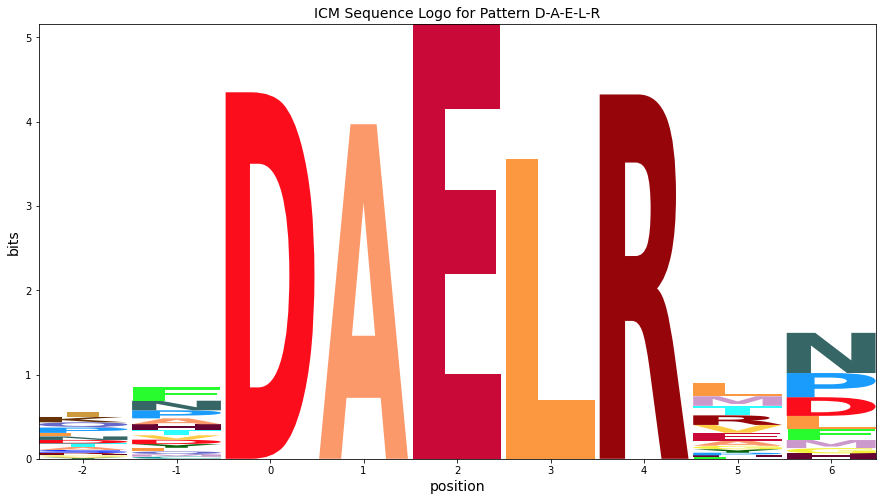

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      2        0   1878.808136004857   0.000000e+00      0.005556   
1      4        2   3369.785511363636   0.000000e+00      0.011111   
2      6        4   1843.809924255979   0.000000e+00      0.016667   
3      3        1  1422.3793285916609  2.017116e-290      0.022222   
4      5        3  1042.9691725635814  3.541478e-209      0.027778   
5      1       -1  115.31717813790915   8.274299e-16      0.033333   
6      8        6  112.37643856201021   2.902861e-15      0.038889   
7      7        5   102.8373350731791   1.635489e-13      0.044444   
8      0       -2   70.19807504387853   8.526304e-08      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     D   4.092659425531837     S   -3.682699490206923  
1      0.003928     E    4.90381514734205     S   -3.682699490206923  
2      0.005891     R   4.066875399761603     S   -3.682699490206923  
3      0.007855     A   3.713698665390807     S   -3.682699490206923  
4      0.009819     L  3.2992113780713535     S   -3.682699490206923  
5      0.011783     F   2.136114577923484     S   -3.682699490206924  
6      0.013747     N  2.1864355902394923     S   -2.878423961081292  
7      0.015710     M  1.9126606105382513     S  -3.5538017570246665  
8      0.017674     K  1.8590654594166551     F  -1.8853044057114223

----------------------------------------------------------------------
I Pattern: D-S-E-F-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.135555  0.0  0.067778  0.000000  0.158148  0.000000  0.000000   
1           0.000000  0.0  0.042823  0.000000  0.042823  0.064234  0.042823   
2           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  4.758552  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.238769  0.000000  0.095508  0.000000   
8           0.000000  0.0  0.000000  0.000000  0.328754  0.000000  0.000000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.316295  0.000000  0.180740  0.090370   
1           0.000000  0.000000  0.235526  0.000000  0.406818  0.171292   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.071631  0.047754  0.000000  0.071631   
8           0.263004  0.065751  0.098626  0.131502  0.000000  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.067778  0.045185  0.045185  0.000000  0.000000   
1           0.000000  0.000000  0.107057  0.085646  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  3.187665  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.405908  0.047754  0.143262  0.000000   
8           0.065751  0.295879  0.000000  0.065751  0.098626  0.131502   

Amino Acid         Y  
Position              
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.095508  
8           0.000000

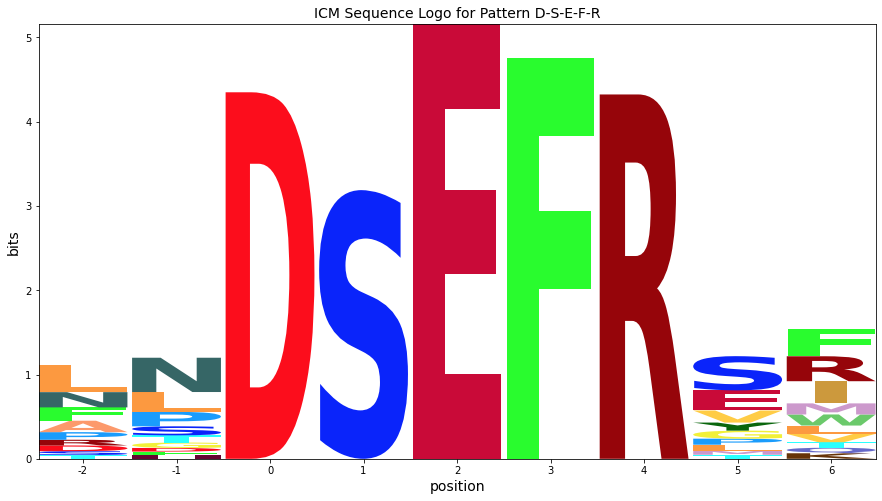

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  2014.9232954545448   0.000000e+00      0.005556   
1      5        3  1511.9825179527172  1.182637e-309      0.011111   
2      2        0  1123.4110503946563  2.265745e-226      0.016667   
3      6        4  1102.4842846066676  6.762594e-222      0.022222   
4      3        1   470.4584464964694   8.674048e-88      0.027778   
5      1       -1  122.09647804524586   4.492939e-17      0.033333   
6      8        6  118.36680319049658   2.238837e-16      0.038889   
7      7        5  103.00065343909971   1.527257e-13      0.044444   
8      0       -2   74.83840112964256   1.417737e-08      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E    4.75671085330984     S   -3.097736989485766  
1      0.003928     F   4.355792614562897     S   -3.097736989485767  
2      0.005891     D   3.945555131499626     S   -3.097736989485766  
3      0.007855     R  3.9197711057293927     S   -3.097736989485767  
4      0.009819     S   2.784906059876074     L   -2.730535965322699  
5      0.011783     N  2.3265253621410418     A  -2.2785739725845837  
6      0.013747     F  2.1518942122428273     S   -2.878423961081292  
7      0.015710     E  2.4691545219428614     A   -2.180393578645679  
8      0.017674     F  1.6500273272851342     G  -2.1403155825020077

----------------------------------------------------------------------
J Pattern: G-G-S-A-E
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.129235  0.0  0.080772  0.00000  0.096926  0.080772  0.032309   
1           0.000000  0.0  0.146419  0.00000  0.000000  0.988328  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  3.968209  0.000000   
3           0.000000  0.0  0.000000  0.00000  0.000000  3.968209  0.000000   
4           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
5           3.969354  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   

Amino Acid    I    K         L         M         N         P         Q  \
Position                                                                 
0           0.0  0.0  0.048463  0.000000  0.032309  0.000000  0.032309   
1           0.0  0.0  0.000000  0.073209  0.000000  0.073209  0.000000   
2           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   

Amino Acid         R         S         T         V    W         Y  
Position                                                           
0           0.048463  0.177698  0.032309  0.000000  0.0  0.000000  
1           0.183024  0.109814  0.146419  0.073209  0.0  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
4           0.000000  3.187665  0.000000  0.000000  0.0  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
7           0.000000  0.000000  3.212127  0.000000  0.0  0.229438  
8           0.332636  0.000000  0.000000  3.326358  0.0  0.000000

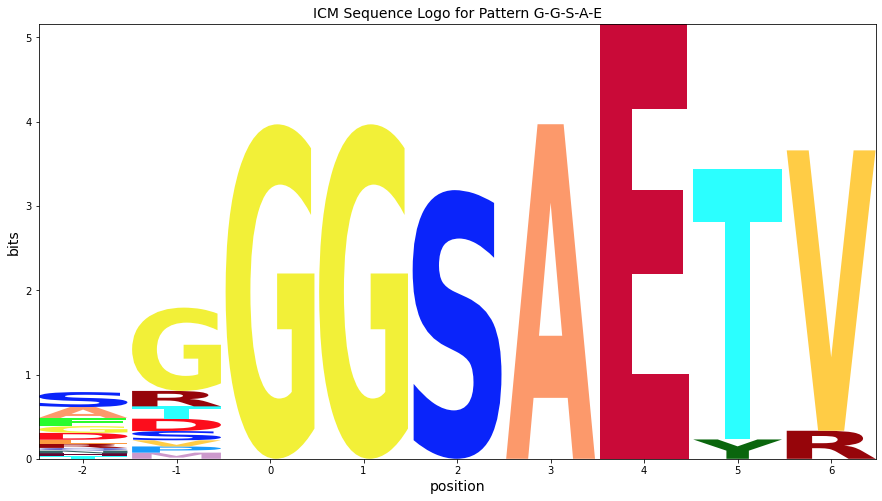

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      6        4  1702.2627840909092   0.000000e+00      0.005556   
1      5        3   718.5215165050657  4.263578e-140      0.011111   
2      2        0   717.9127892510576  5.739021e-140      0.016667   
3      3        1   717.9127892510576  5.739021e-140      0.022222   
4      4        2   397.4562737642586   1.482320e-72      0.027778   
5      7        5  322.09474081187636   5.806322e-57      0.033333   
6      8        6  288.30123735151744   4.962566e-50      0.038889   
7      1       -1   211.8894495766878   1.449749e-34      0.044444   
8      0       -2   45.18097122795337   6.465177e-04      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.694801755806803     S  -2.9208592274016874  
1      0.003928     A  3.5046852738555594     S  -2.9208592274016874  
2      0.005891     G   3.503540607272717     S  -2.9208592274016874  
3      0.007855     G   3.503540607272717     S  -2.9208592274016874  
4      0.009819     S  2.7229969623730366     L    -2.55365820323862  
5      0.011783     T  2.9530029513891565     S  -2.4561909603982435  
6      0.013747     V  3.0760874021994624     S    -2.20465219340228  
7      0.015710     G   2.667039339555596     L  -2.5536582032386193  
8      0.017674     F  1.4573822493427384     P   -2.455659549536177

----------------------------------------------------------------------
K Pattern: D-A-E-Y-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.079021  0.0  0.000000  0.000000  0.079021  0.173847  0.237064   
1           0.215722  0.0  0.071907  0.043144  0.000000  0.000000  0.028763   
2           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
3           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.105072  0.0  0.000000  0.000000  0.000000  0.000000  0.105072   
8           0.092013  0.0  0.092013  0.000000  0.000000  0.000000  0.000000   

Amino Acid         I         K         L         M         N         P    Q  \
Position                                                                      
0           0.063217  0.000000  0.031609  0.000000  0.000000  0.000000  0.0   
1           0.028763  0.043144  0.129433  0.000000  0.057526  0.000000  0.0   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.000000  0.000000  0.546377  0.042029  0.000000  0.084058  0.0   
8           0.000000  0.000000  0.368053  0.000000  0.000000  0.153355  0.0   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.110630  0.142239  0.000000  0.063217  0.000000  0.079021  
1           0.115052  0.000000  0.230103  0.043144  0.000000  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  4.579571  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.000000  0.189130  0.042029  0.147101  0.000000  0.000000  
8           0.214698  0.245369  0.000000  0.000000  0.061342  0.000000

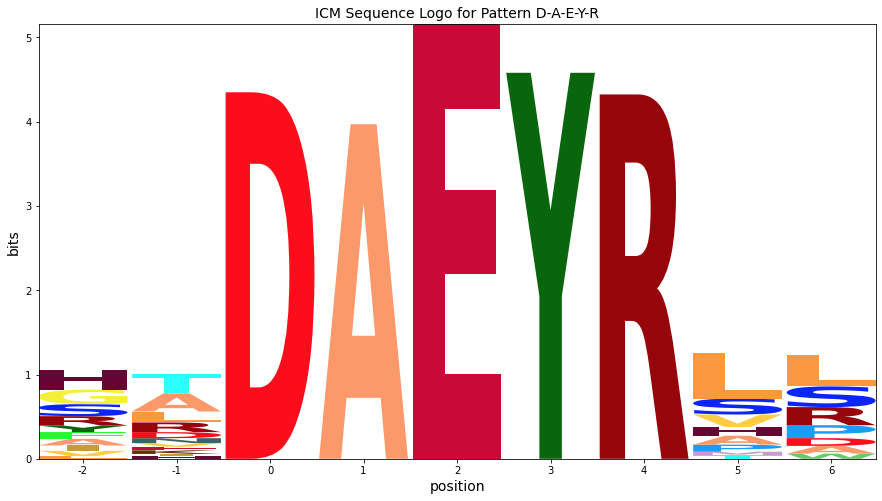

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2   2431.803977272728   0.000000e+00      0.005556   
1      5        3  1603.7337261237287   0.000000e+00      0.011111   
2      2        0  1355.8409228901032  3.773656e-276      0.016667   
3      6        4  1330.5844814218403  9.813407e-271      0.022222   
4      3        1  1026.4593092929513  1.189785e-205      0.027778   
5      7        5  121.22813406506783   6.534676e-17      0.033333   
6      0       -2  101.36272917648915   3.031979e-13      0.038889   
7      1       -1   86.98896952664941   1.127935e-10      0.044444   
8      8        6   61.20482602343212   2.491422e-06      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.817364045985254     S   -3.304187866953193  
1      0.003928     Y  4.2374653190453095     S   -3.304187866953194  
2      0.005891     D   4.006208324175041     S   -3.304187866953193  
3      0.007855     R   3.980424298404807     S   -3.304187866953194  
4      0.009819     A  3.6272475640340107     S   -3.304187866953193  
5      0.011783     L   1.987825660815656     G   -2.353719220611201  
6      0.013747     H  2.1033900513018065     P  -2.7900785886067365  
7      0.015710     A   1.477500444529328     S   -3.304187866953194  
8      0.017674     R  1.4156396796212807     T  -2.1680124495722093

----------------------------------------------------------------------
L Pattern: S-x-D-A-E-x-R
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.191694   
1           0.158559  0.0  0.000000  0.00000  0.000000  0.211412  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           0.043893  0.0  0.029262  0.00000  0.073154  0.029262  0.029262   
4           0.000000  0.0  4.348314  0.00000  0.000000  0.000000  0.000000   
5           3.969354  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.00000  0.196329  0.000000  0.215962   
8           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
9           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
10          0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.460065  0.000000  0.383388  0.000000  0.076678  0.153355   
1           0.000000  0.079280  0.052853  0.105706  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.029262  0.043893  0.131678  0.190201  0.000000  0.117047   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.098165  0.000000  0.098165  0.039266  0.000000  0.000000   
8           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9           0.000000  0.000000  0.102167  0.476779  0.000000  0.000000   
10          0.000000  0.186168  0.000000  0.000000  0.000000  0.248224   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.076678  0.000000  0.000000  0.000000  0.000000   
1           0.000000  0.052853  0.052853  0.052853  0.422825  0.000000   
2           0.000000  0.000000  3.187665  0.000000  0.000000  0.000000   
3           0.146309  0.000000  0.087785  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.255228  0.039266  0.157063  0.000000  0.039266   
8           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
9           0.170278  0.544890  0.170278  0.170278  0.068111  0.000000   
10          0.000000  0.124112  0.093084  0.372336  0.403364  0.000000   

Amino Acid         Y  
Position              
0           0.421726  
1           0.079280  
2           0.000000  
3           0.029262  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.176696  
8           0.000000  
9           0.068111  
10          0.062056

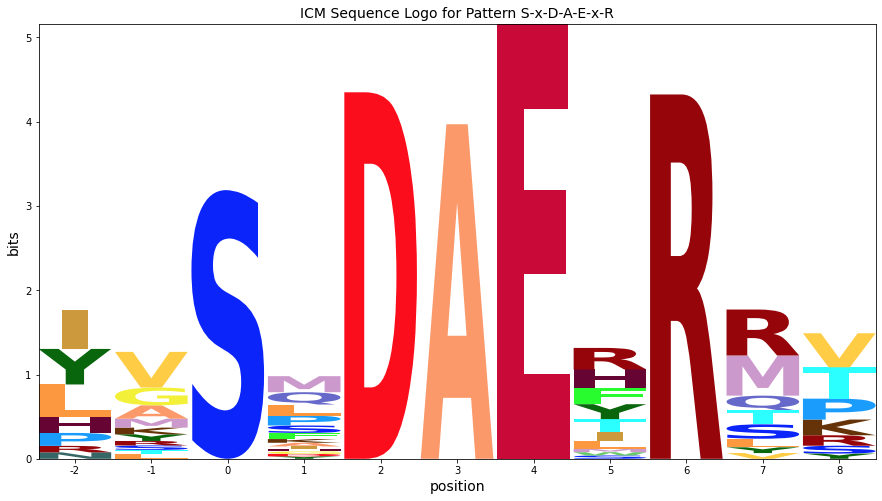

X^2 Critical Value = 38.90371889923782
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0       6        4  2327.5838068181824   0.000000e+00      0.004545   
1       4        2  1297.7334547662415  1.079412e-263      0.009091   
2       8        6  1273.5594322180473  1.633824e-258      0.013636   
3       5        3   982.4681960375391  2.928505e-196      0.018182   
4       2        0     543.46061922868  4.133672e-103      0.022727   
5       9        7  204.15294136635953   5.074043e-33      0.027273   
6       0       -2  146.61350437765927   9.841641e-22      0.031818   
7       7        5  126.93004427649515   5.542384e-18      0.036364   
8       3        1  119.45243390448721   1.403947e-16      0.040909   
9      10        8  105.78652147613687   4.735273e-14      0.045455   
10      1       -1  101.56502115647093   2.786081e-13      0.050000   

    Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0       0.001505     E   4.803989368211857     S   -3.255278266472247  
1       0.003010     D   3.992833646401644     S   -3.255278266472247  
2       0.004516     R  3.9670496206314105     S   -3.255278266472247  
3       0.006021     A   3.613872886260614     S   -3.255278266472247  
4       0.007526     S   2.832184574778092     L   -2.888077242309179  
5       0.009031     M  2.8061306903844483     P  -2.5170600942003207  
6       0.010536     I  2.3968196719908343     S  -2.8567288899819725  
7       0.012041     F  1.7750399068518723     P  -2.7900785886067365  
8       0.013547     M  2.4335765224271184     T  -2.7040653498124185  
9       0.015052     K  1.9008856351112824     L    -2.53259658771079  
10      0.016557     V  2.0760874021994633     P  -2.4345979340083477

----------------------------------------------------------------------
M Pattern: N-S-E-[FW]-R
Information Content Matrix


Amino Acid        A    C         D         E         F         G         H  \
Position                                                                     
0           0.21143  0.0  0.000000  0.126858  0.211430  0.000000  0.296002   
1           0.00000  0.0  0.000000  0.043313  0.086627  0.108284  0.064970   
2           0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.00000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.00000  0.0  0.000000  0.000000  3.942707  0.000000  0.000000   
6           0.00000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.00000  0.0  0.061197  0.030598  0.030598  0.030598  0.076496   
8           0.00000  0.0  0.048809  0.000000  0.000000  0.146427  0.292854   

Amino Acid         I         K         L         M         N        P  \
Position                                                                
0           0.084572  0.169144  0.000000  0.000000  0.000000  0.21143   
1           0.000000  0.000000  0.000000  0.043313  0.000000  0.00000   
2           0.000000  0.000000  0.000000  0.000000  4.252525  0.00000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
7           0.061197  0.000000  0.030598  0.000000  0.260086  0.00000   
8           0.000000  0.000000  0.000000  0.000000  0.219641  0.00000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.000000  0.000000  0.000000  0.084572  0.084572   
1           0.151597  0.000000  0.064970  0.259881  0.368164  0.194910   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  3.187665  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.411925   
6           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.030598  0.107094  0.229487  0.000000   
8           0.000000  0.170832  0.195236  0.000000  0.414877  0.000000   

Amino Acid        Y  
Position             
0           0.00000  
1           0.00000  
2           0.00000  
3           0.00000  
4           0.00000  
5           0.00000  
6           0.00000  
7           0.18359  
8           0.00000

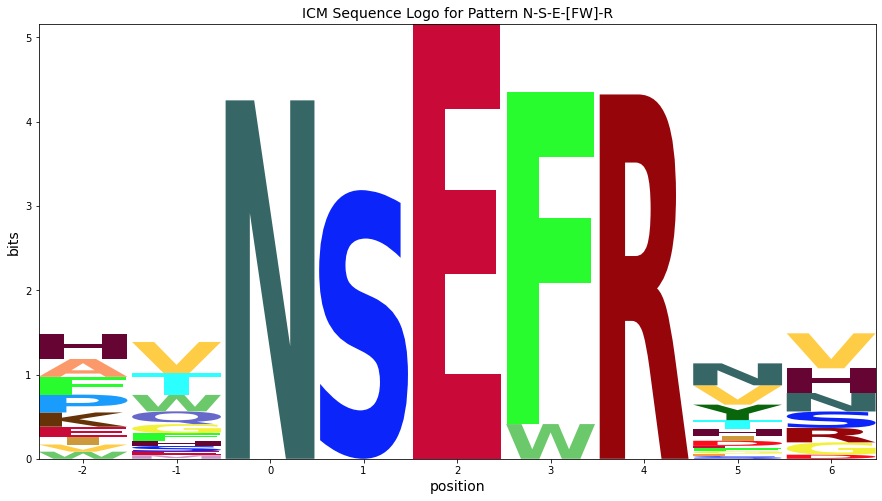

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  2570.7642045454554   0.000000e+00      0.005556   
1      5        3   1593.467202026381   0.000000e+00      0.011111   
2      6        4  1406.6178803602315  4.855238e-287      0.016667   
3      2        0  1336.4874815347905  5.324951e-272      0.022222   
4      3        1   600.2400869092884  4.491074e-115      0.027778   
5      1       -1  136.68884957127509   7.824266e-20      0.033333   
6      8        6  135.58157432485055   1.271586e-19      0.038889   
7      7        5  130.53969106830746   1.152404e-18      0.044444   
8      0       -2   72.36532653882271   3.703414e-08      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E  4.8336998616284905     S   -3.366923622301156  
1      0.003928     F   4.291425773636006     S   -3.366923622301156  
2      0.005891     R   3.996760114048043     S  -3.3669236223011567  
3      0.007855     N   3.926754619515509     S   -3.366923622301156  
4      0.009819     S  2.8618950681947246     L  -2.9997225981380886  
5      0.011783     W   2.192445553615939     L  -2.8374511692392117  
6      0.013747     H  1.9069232624070014     L   -2.784983749345076  
7      0.015710     N  1.8678609304619402     P   -2.901723944435646  
8      0.017674     H   1.764973833625875     S   -2.593694484148179

----------------------------------------------------------------------
N Pattern: L-x-D-A-E-[FW]
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.096605  0.0  0.096605  0.000000  0.000000  0.000000  0.000000   
1           0.000000  0.0  0.000000  0.000000  0.087344  0.052406  0.192156   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.200456  0.200456  0.000000  0.100228  0.260593   
4           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
5           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  2.650053  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.121007  0.169409  0.169409  0.121007   
9           0.000000  0.0  0.000000  0.000000  0.237509  0.169650  0.000000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.917745  0.000000  0.000000  0.096605   
1           0.034937  0.034937  0.000000  0.000000  0.000000  0.122281   
2           0.000000  0.000000  3.554866  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.040091  0.140319  0.040091   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.145208  0.000000  0.000000  0.096805   
9           0.101790  0.000000  0.101790  0.067860  0.237509  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.096605  0.000000  0.000000  0.000000  0.338116  0.144907   
1           0.052406  0.000000  0.262031  0.000000  0.087344  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.220501  0.000000  0.100228  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  1.355841   
8           0.000000  0.169409  0.072604  0.048403  0.000000  0.000000   
9           0.000000  0.000000  0.101790  0.000000  0.169650  0.067860   

Amino Acid         Y  
Position              
0           0.000000  
1           0.209625  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.000000  
8           0.000000  
9           0.000000

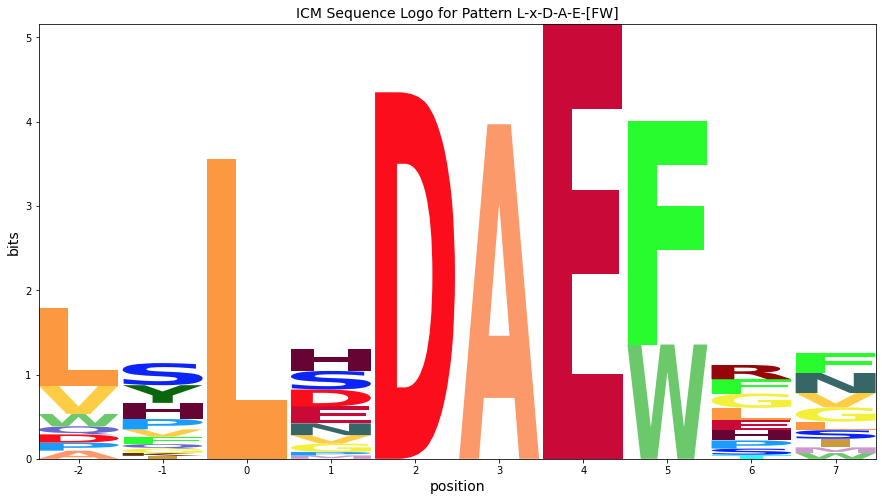

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      6        4   2258.103693181817   0.000000e+00         0.005   
1      4        2  1258.9951426836676  2.154813e-255         0.010   
2      7        5   990.8921495406983  4.665090e-198         0.015   
3      5        3   953.1407872005975  5.289004e-190         0.020   
4      2        0   698.8968682127095  6.155730e-136         0.025   
5      3        1  128.74998675158733   2.512716e-18         0.030   
6      0       -2  117.99995920954973   2.620837e-16         0.035   
7      1       -1   99.79268917481619   5.838968e-13         0.040   
8      8        6   69.45817627835989   1.131529e-07         0.045   
9      9        7   65.42031880192063   5.216338e-07         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E  4.7944732060309985     S    -3.22172570676122  
1      0.003414     D   3.983317484220785     S    -3.22172570676122  
2      0.005121     F  3.8085924665628994     S    -3.22172570676122  
3      0.006828     A  3.6043567240797554     S    -3.22172570676122  
4      0.008535     L   3.189869436760301     S    -3.22172570676122  
5      0.010243     E  2.2095107053098424     L   -2.854524682598152  
6      0.011950     L  2.0439043342621694     S  -2.6452247847882613  
7      0.013657     Y   1.870620077873693     L  -2.8545246825981527  
8      0.015364     F  1.7141576647048495     A   -2.075040578499451  
9      0.017071     F  1.9256617698985607     P  -2.1800251069227508

----------------------------------------------------------------------
O Pattern: T-A-E-[FW]-R
Information Content Matrix


Amino Acid         A    C        D         E         F         G         H  \
Position                                                                     
0           0.137072  0.0  0.08567  0.034268  0.000000  0.154206  0.000000   
1           0.000000  0.0  0.00000  0.000000  0.000000  0.000000  0.383790   
2           0.000000  0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
3           3.969354  0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.00000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.00000  0.000000  2.193260  0.000000  0.000000   
6           0.000000  0.0  0.00000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.00000  0.000000  0.119681  0.059841  0.074801   
8           0.000000  0.0  0.00000  0.048273  0.048273  0.032182  0.000000   

Amino Acid         I         K         L         M        N         P  \
Position                                                                
0           0.051402  0.000000  0.085670  0.102804  0.00000  0.034268   
1           0.179102  0.000000  0.000000  0.000000  0.25586  0.179102   
2           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
7           0.000000  0.029920  0.104721  0.029920  0.00000  0.000000   
8           0.064364  0.032182  0.000000  0.064364  0.00000  0.144820   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.137072  0.119938  0.000000  0.000000  0.000000   
1           0.000000  0.051172  0.102344  0.000000  0.000000  0.153516   
2           0.000000  0.000000  0.000000  3.738878  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  1.799598   
6           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
7           0.104721  0.000000  0.044881  0.149602  0.074801  0.059841   
8           0.032182  0.032182  0.080456  0.112638  0.080456  0.193093   

Amino Acid         Y  
Position              
0           0.000000  
1           0.281446  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.044881  
8           0.000000

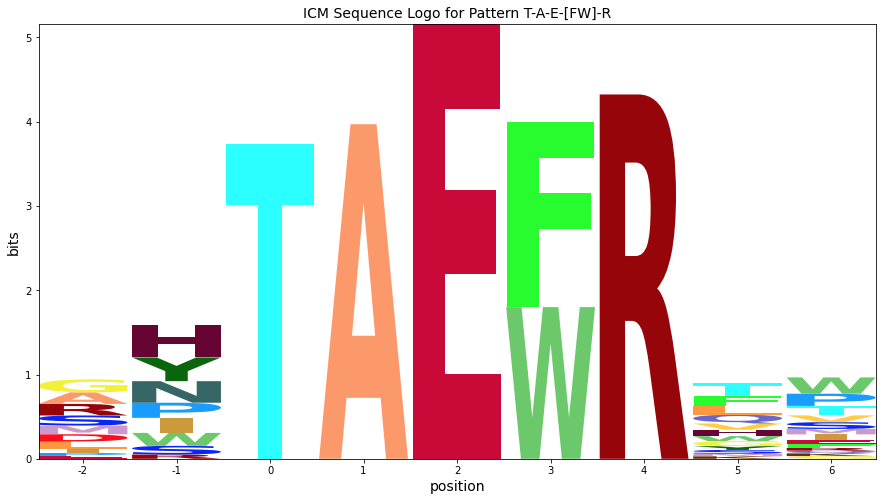

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2    2466.54403409091   0.000000e+00      0.005556   
1      6        4  1349.5928311564378  8.250739e-275      0.011111   
2      5        3  1062.6281733759938  2.234024e-213      0.016667   
3      3        1  1041.1230137114221  8.781029e-209      0.022222   
4      2        0   876.9224758897893  9.268044e-174      0.027778   
5      1       -1  157.21038965560496   8.828637e-24      0.033333   
6      8        6  103.25443690182333   1.373055e-13      0.038889   
7      7        5   67.22879219545888   2.640088e-07      0.044444   
8      0       -2   62.14070445191278   1.766007e-06      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.821600384053863     S  -3.3201294108222146  
1      0.003928     R  3.9846606364734156     S  -3.3201294108222155  
2      0.005891     W   3.799434360667095     S  -3.3201294108222146  
3      0.007855     A  3.6314839021026195     S  -3.3201294108222137  
4      0.009819     T  3.4010085072799257     S  -3.3201294108222155  
5      0.011783     H  2.1887815425324506     L   -2.802685751078535  
6      0.013747     W   2.641346504761067     L  -2.7670618413478127  
7      0.015710     Q  1.6551024275157729     P   -2.669063187645371  
8      0.017674     M  1.6477013277799655     T   -2.489940544459571

----------------------------------------------------------------------
P Pattern: S-A-E-x-R-[FL]
Information Content Matrix


Amino Acid         A    C    D         E         F    G         H         I  \
Position                                                                      
0           0.000000  0.0  0.0  0.089239  0.059492  0.0  0.059492  0.267716   
1           0.133724  0.0  0.0  0.000000  0.000000  0.0  0.044575  0.044575   
2           0.000000  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.000000   
3           3.969354  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.000000   
4           0.000000  0.0  0.0  5.159470  0.000000  0.0  0.000000  0.000000   
5           0.000000  0.0  0.0  0.000000  0.500101  0.0  0.200040  0.000000   
6           0.000000  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.000000   
7           0.000000  0.0  0.0  0.000000  1.343702  0.0  0.000000  0.000000   
8           0.000000  0.0  0.0  0.592891  0.000000  0.0  0.000000  0.000000   
9           0.000000  0.0  0.0  0.000000  0.000000  0.0  0.144465  0.000000   

Amino Acid         K         L         M         N         P         Q  \
Position                                                                 
0           0.000000  0.000000  0.000000  0.386701  0.059492  0.000000   
1           0.000000  0.000000  0.000000  0.111436  0.267447  0.044575   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.100020  0.100020  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  1.746813  0.000000  0.000000  0.000000  0.000000   
8           0.098815  0.098815  0.000000  0.098815  0.148223  0.000000   
9           0.096310  0.000000  0.144465  0.000000  0.192620  0.000000   

Amino Acid        R         S         T         V         W         Y  
Position                                                               
0           0.00000  0.089239  0.059492  0.148731  0.000000  0.148731  
1           0.00000  0.089149  0.111436  0.178298  0.000000  0.000000  
2           0.00000  3.187665  0.000000  0.000000  0.000000  0.000000  
3           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.00000  0.150030  0.000000  0.000000  0.250050  1.000202  
6           4.32253  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.00000  0.296446  0.247038  0.000000  0.098815  0.000000  
9           0.09631  0.192620  0.096310  0.240775  0.000000  0.000000

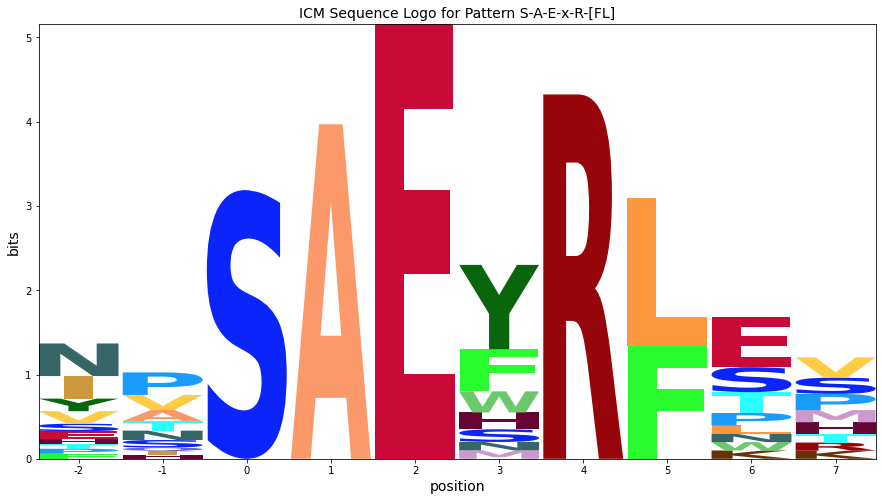

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  1598.0426136363635   0.000000e+00         0.005   
1      6        4    874.384087791495  3.217479e-173         0.010   
2      3        1   674.5304032496538  8.908012e-131         0.015   
3      2        0    373.122216186855   1.671259e-67         0.020   
4      7        5  362.08680587968263   3.229616e-65         0.025   
5      5        3   256.1154724091306   1.782965e-43         0.030   
6      8        6  152.57342592247522   6.979611e-23         0.035   
7      0       -2  108.68479238748857   1.392085e-14         0.040   
8      1       -1  56.980154233327454   1.150754e-05         0.045   
9      9        7  37.387191091393404   7.095121e-03         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E    4.66966475512943     S  -2.8567288899819725  
1      0.003414     R  3.8327250075489836     S  -2.8567288899819725  
2      0.005121     A  3.4795482731781866     S  -2.8567288899819725  
3      0.006828     S   2.697859961695665     L  -2.4895278658189044  
4      0.008535     F  3.1064750874836102     S  -2.8567288899819725  
5      0.010243     Y   2.927494599290609     L  -2.4895278658189044  
6      0.011950     E    3.10502223878787     G  -1.7866786278873077  
7      0.013657     I   2.018308048737104     L  -2.4895278658189044  
8      0.015364     P  1.3089105060246302     L  -2.4895278658189044  
9      0.017071     M  1.5773119998885674     L  -1.9369868427901258

----------------------------------------------------------------------
Q Pattern: P-Q-x-G-[FL]-L
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.065686  0.0  0.000000  0.098529  0.098529  0.000000  0.000000   
1           0.124009  0.0  0.000000  0.099207  0.000000  0.173612  0.049604   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.159493  0.0  0.053164  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  3.968209  0.000000   
6           0.000000  0.0  0.000000  0.000000  1.039943  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.063018  0.0  0.000000  0.063018  0.000000  0.000000  0.094527   
9           0.000000  0.0  0.000000  0.000000  0.262220  0.104888  0.000000   

Amino Acid         I    K         L         M         N         P         Q  \
Position                                                                      
0           0.000000  0.0  0.000000  0.000000  0.065686  0.065686  0.197058   
1           0.000000  0.0  0.049604  0.000000  0.000000  0.049604  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  3.652865  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  4.977031   
4           0.000000  0.0  0.292403  0.053164  0.053164  0.079746  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  1.999891  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  3.554866  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.157545  0.000000  0.094527  0.126036  0.000000   
9           0.157332  0.0  0.104888  0.000000  0.000000  0.104888  0.000000   

Amino Acid         R         S         T         V    W         Y  
Position                                                           
0           0.000000  0.229901  0.295587  0.065686  0.0  0.000000  
1           0.000000  0.248018  0.099207  0.049604  0.0  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
4           0.000000  0.186075  0.132911  0.000000  0.0  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
7           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
8           0.000000  0.126036  0.000000  0.063018  0.0  0.126036  
9           0.157332  0.104888  0.209776  0.000000  0.0  0.000000

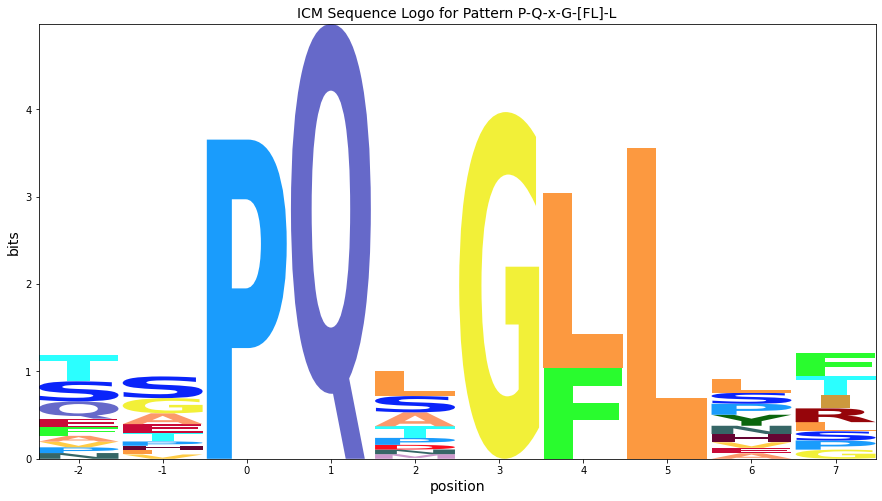

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      3        1  1158.7930904994369  6.114584e-234         0.005   
1      5        3   556.7486937049019  6.602522e-106         0.010   
2      2        0  439.97535431299525   2.048190e-81         0.015   
3      7        5    408.585861416661   7.171482e-75         0.020   
4      6        4   275.6780638867885   1.873896e-47         0.025   
5      0       -2   60.76799844301269   2.923739e-06         0.030   
6      4        2   45.45680088025197   5.913260e-04         0.035   
7      1       -1  43.930255793870664   9.655863e-04         0.040   
8      9        7   42.53979345697125   1.497761e-03         0.045   
9      8        6  28.873399960938784   6.800274e-02         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     Q   4.404451746137811     S   -2.670315765751092  
1      0.003414     G   3.395630098010836     S   -2.670315765751092  
2      0.005121     P  3.0802861309766674     S   -2.670315765751092  
3      0.006828     L  2.9822874772742245     S   -2.670315765751092  
4      0.008535     F   2.707925710993335     S   -2.670315765751092  
5      0.010243     Q  1.9770305224031346     L  -2.2524886685180556  
6      0.011950     L  1.2818477591331332     G  -1.8897721208514113  
7      0.013657     E  1.6234171225700362     N  -1.6054562144303075  
8      0.015364     F   1.917249530082361     A  -1.4569112138430955  
9      0.017071     Y  1.2867895466424564     T   -1.875831698078899

----------------------------------------------------------------------
R Pattern: A-E-F-R-[AT]
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.130537  0.0  0.076147  0.000000  0.000000  0.043512  0.000000   
1           0.046289  0.0  0.185156  0.231445  0.000000  0.092578  0.000000   
2           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  4.758552  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           1.500519  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.095484  0.000000  0.000000  0.047742  0.023871   
8           0.000000  0.0  0.052448  0.104895  0.157343  0.000000  0.000000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.054390  0.000000  0.119659  0.021756   
1           0.030859  0.000000  0.046289  0.000000  0.216016  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.167098  0.000000  0.107420  0.047742  0.000000  0.000000   
8           0.000000  0.262238  0.445805  0.000000  0.236015  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.043512  0.141415  0.097903  0.000000  0.000000   
1           0.000000  0.000000  0.262305  0.123438  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  1.360936  0.000000  0.000000   
7           0.023871  0.083549  0.179033  0.023871  0.035807  0.000000   
8           0.000000  0.000000  0.000000  0.052448  0.104895  0.104895   

Amino Acid         Y  
Position              
0           0.043512  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.035807  
8           0.000000

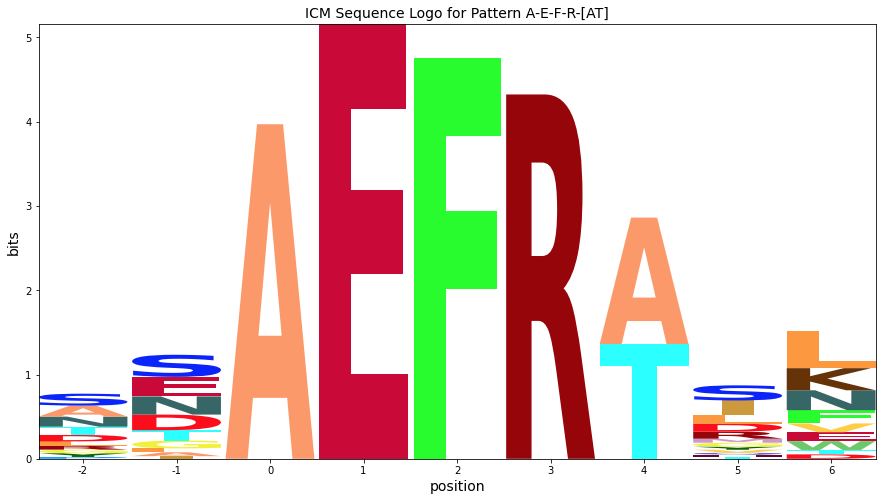

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      3        1   2848.684659090909   0.000000e+00      0.005556   
1      4        2  2137.6304564159113   0.000000e+00      0.011111   
2      5        3  1558.6846782370135   0.000000e+00      0.016667   
3      2        0  1202.4237623146003  2.807322e-243      0.022222   
4      6        4   518.8425864274802   6.188831e-98      0.027778   
5      1       -1  158.94177067174397   4.071983e-24      0.033333   
6      8        6   133.9553999324007   2.592089e-19      0.038889   
7      7        5   90.75216521545029   2.439904e-11      0.044444   
8      0       -2   62.49989396887396   1.546778e-06      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.862084112185676     S  -3.4847601125950143  
1      0.003928     F   4.461165873438733     S  -3.4847601125950143  
2      0.005891     R   4.025144364605229     S  -3.4847601125950143  
3      0.007855     A  3.6719676302344326     S  -3.4847601125950134  
4      0.009819     A  2.7563598175248045     S  -3.4847601125950143  
5      0.011783     E   2.515613833035521     P   -2.990991282532733  
6      0.013747     K  2.3550229540790673     S   -3.097736989485767  
7      0.015710     I  2.1085058577086824     P  -2.8862939038660396  
8      0.017674     N  1.3296926412197254     V   -2.431707237999234

----------------------------------------------------------------------
S Pattern: P-[DS]-A-E-F
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.072456  0.0  0.000000  0.000000  0.000000  0.000000  0.054342   
1           0.105332  0.0  0.000000  0.042133  0.000000  0.073732  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  1.132705  0.000000  0.000000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  4.758552  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.141130  0.141130   
8           0.074877  0.0  0.336946  0.000000  0.149754  0.000000  0.000000   

Amino Acid         I    K         L         M         N         P    Q  \
Position                                                                 
0           0.000000  0.0  0.000000  0.090570  0.126798  0.000000  0.0   
1           0.000000  0.0  0.063199  0.000000  0.052666  0.000000  0.0   
2           0.000000  0.0  0.000000  0.000000  0.000000  3.652865  0.0   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.105848  0.0  0.141130  0.000000  0.000000  0.176413  0.0   
8           0.000000  0.0  0.056158  0.093596  0.000000  0.000000  0.0   

Amino Acid         R         S         T         V    W         Y  
Position                                                           
0           0.072456  0.054342  0.525304  0.199253  0.0  0.181139  
1           0.189597  0.157997  0.052666  0.042133  0.0  0.147464  
2           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
3           0.000000  1.561296  0.000000  0.000000  0.0  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
7           1.587714  0.105848  0.000000  0.000000  0.0  0.000000  
8           0.074877  0.355666  0.056158  0.000000  0.0  0.074877

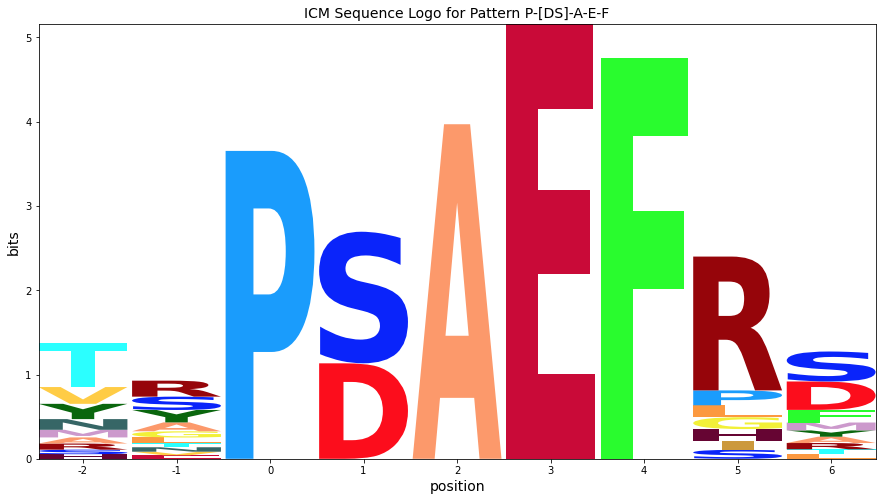

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  3057.1250000000005   0.000000e+00      0.005556   
1      6        4  2294.0424410317105   0.000000e+00      0.011111   
2      4        2  1290.4059888254242  4.012882e-262      0.016667   
3      2        0  1018.8902941985151  4.918034e-204      0.022222   
4      7        5   549.1516695099025  2.623324e-104      0.027778   
5      3        1  498.18184704694386   1.344717e-93      0.033333   
6      0       -2   164.7422170740984   3.025517e-25      0.038889   
7      8        6  132.58436648487282   4.720825e-19      0.044444   
8      1       -1   112.3133507010852   2.981907e-15      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.880315951613174     S   -3.567222272786989  
1      0.003928     F  4.4793977128662315     S   -3.567222272786989  
2      0.005891     A  3.6901994696619305     S   -3.567222272786989  
3      0.007855     P  3.3737108360449204     S  -3.5672222727869882  
4      0.009819     R   3.386660612649515     T   -2.720553472600988  
5      0.011783     D  2.8413543122801492     L  -3.2000212486239192  
6      0.013747     T  2.0608062409236716     L   -3.030096247181607  
7      0.015710     D   2.136810195806321     P   -2.806566711395306  
8      0.017674     R  1.8155702865099164     P   -3.102022594921477

----------------------------------------------------------------------
T Pattern: A-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.028250  0.0  0.028250  0.000000  0.084751  0.056500  0.000000   
1           0.000000  0.0  0.000000  0.000000  0.102767  0.123321  0.411070   
2           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  2.519463  0.000000  0.000000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.042051  0.000000  0.042051   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.086593  0.0  0.000000  0.108241  0.000000  0.000000  0.064944   
9           0.000000  0.0  0.000000  0.000000  0.000000  0.180082  0.090041   

Amino Acid         I         K         L         M         N         P    Q  \
Position                                                                      
0           0.000000  0.042375  0.098876  0.028250  0.084751  0.211877  0.0   
1           0.000000  0.000000  0.061660  0.000000  0.041107  0.000000  0.0   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.000000  0.168204  0.147179  0.105128  0.000000  0.0   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
8           0.000000  0.000000  0.454611  0.064944  0.000000  0.000000  0.0   
9           0.225102  0.000000  0.000000  0.000000  0.090041  0.315143  0.0   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.042375  0.000000  0.028250  0.000000  0.070626  0.028250  
1           0.143874  0.061660  0.184981  0.041107  0.041107  0.041107  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.771264  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.105128  0.126153  0.063077  0.000000  0.189230  0.357434  
7           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.000000  0.151537  0.108241  0.043296  0.000000  0.108241  
9           0.225102  0.000000  0.135061  0.000000  0.090041  0.000000

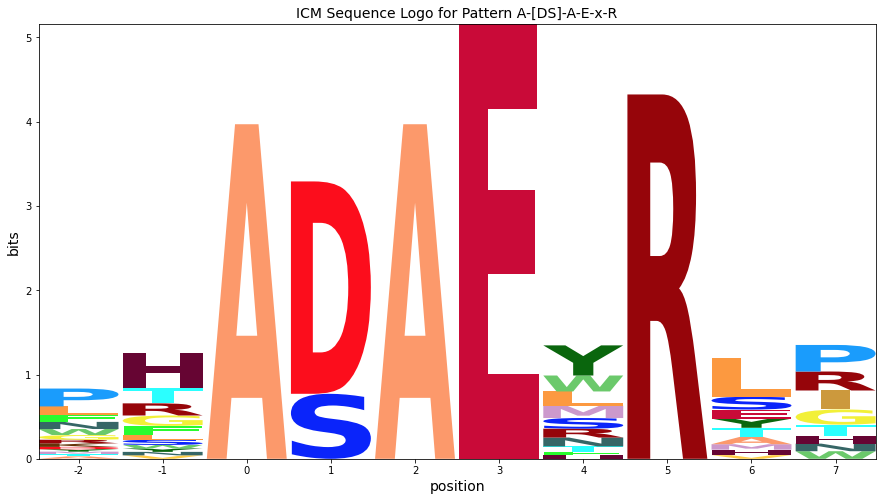

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3   2223.363636363636   0.000000e+00         0.005   
1      7        5   1216.534383014254  2.674275e-246         0.010   
2      2        0   938.4770827821268  7.086729e-187         0.015   
3      4        2   938.4770827821268  7.086729e-187         0.020   
4      3        1   732.1937183349344  5.373792e-143         0.025   
5      1       -1  155.87002829077755   1.606128e-23         0.030   
6      6        4   155.4355966831257   1.949651e-23         0.035   
7      8        6   95.63206610517408   3.283059e-12         0.040   
8      0       -2   63.21956997562395   1.185106e-06         0.045   
9      9        7   52.62796455691425   5.325712e-05         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.789520413059941     S   -3.204652193402279  
1      0.003414     R   3.952580665479494     S   -3.204652193402279  
2      0.005121     A   3.599403931108698     S   -3.204652193402279  
3      0.006828     A   3.599403931108698     S   -3.204652193402279  
4      0.008535     D  3.5998530679959977     L   -2.837451169239211  
5      0.010243     H    2.59880096704467     P  -2.6869850956426338  
6      0.011950     Y   2.357178874533854     P  -2.7394525155367693  
7      0.013657     L  1.7854791816809656     P   -2.575953783253889  
8      0.015364     W  1.5440166340513906     S  -3.1161155188006213  
9      0.017071     I  1.6818803841546264     S  -2.4561909603982435

----------------------------------------------------------------------
U Pattern: T-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.000000  0.000000  0.063642  0.222748  0.000000   
1           0.255698  0.0  0.098345  0.000000  0.078676  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  2.166145  0.000000  0.000000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.232671  0.000000  0.166193   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.103372  0.000000  0.034457  0.000000  0.086144   
9           0.084037  0.0  0.000000  0.056025  0.000000  0.000000  0.056025   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.063642  0.000000  0.063642  0.095464  0.159106  0.127285   
1           0.078676  0.000000  0.039338  0.137683  0.000000  0.039338   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.132955  0.000000  0.232671  0.166193  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.172287  0.034457  0.000000  0.155058   
9           0.000000  0.056025  0.168075  0.000000  0.084037  0.056025   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.286391  0.000000  0.127285  0.000000  0.000000   
1           0.000000  0.137683  0.039338  0.078676  0.059007  0.000000   
2           0.000000  0.000000  0.000000  3.738878  0.000000  0.000000   
3           0.000000  0.000000  0.944217  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.066477  0.000000  0.232671   
7           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
8           0.086144  0.000000  0.034457  0.000000  0.120601  0.086144   
9           0.000000  0.196087  0.280125  0.000000  0.000000  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.631535  
7           0.000000  
8           0.051686  
9           0.000000

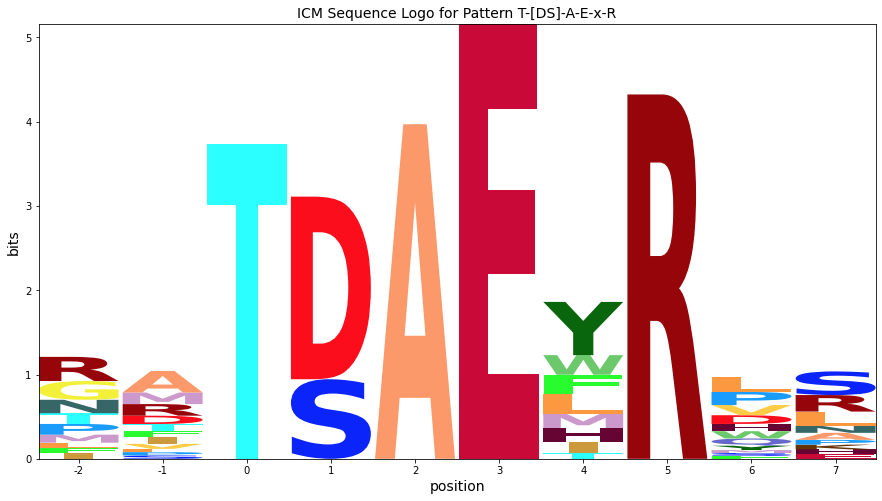

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  1945.4431818181815   0.000000e+00         0.005   
1      7        5  1064.4675851374725  9.037265e-214         0.010   
2      4        2   821.1674474343612  6.793892e-162         0.015   
3      2        0   691.6571640820874  2.103949e-134         0.020   
4      3        1   544.2619146206138  2.803853e-103         0.025   
5      6        4  199.71219450099753   3.884402e-32         0.030   
6      1       -1    81.7525100881594   9.258447e-10         0.035   
7      0       -2   63.14079179727515   1.220226e-06         0.040   
8      8        6   61.48919421837151   2.244488e-06         0.045   
9      9        7  45.675431357313954   5.508409e-04         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.744432523531401     S   -3.060262284067105  
1      0.003414     R  3.9074927759509555     S  -3.0602622840671043  
2      0.005121     A  3.5543160415801576     S   -3.060262284067105  
3      0.006828     T  3.3238406467574655     S  -3.0602622840671043  
4      0.008535     D  3.4223148824438083     L   -2.693061259904037  
5      0.010243     Y  2.6535718773140786     S   -3.060262284067105  
6      0.011950     M   1.879340537338225     G   -2.221615684603857  
7      0.013657     R  1.7864773749895897     S   -2.670315765751091  
8      0.015364     W   1.599869868784908     T   -2.509049367407276  
9      0.017071     R  1.4896402610650572     T  -2.0940118681284328

----------------------------------------------------------------------
V Pattern: S-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.000000  0.505904  0.068987  0.068987  0.000000  0.000000   
1           0.000000  0.000000  0.028877  0.000000  0.000000  0.072192   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  1.383995  0.000000  0.000000  0.000000   
4           3.969354  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.492367  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.210549  0.000000  0.090235  0.000000  0.000000  0.045118   
9           0.000000  0.000000  0.063548  0.063548  0.063548  0.000000   

Amino Acid         H         I         K         L         M         N  \
Position                                                                 
0           0.137974  0.344935  0.114978  0.068987  0.068987  0.137974   
1           0.043315  0.000000  0.057754  0.115508  0.317646  0.101069   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.246184  0.061546  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.105274  0.000000  0.330863  0.030078  0.105274   
9           0.000000  0.317742  0.000000  0.000000  0.000000  0.063548   

Amino Acid         P    Q         R         S         T         V         W  \
Position                                                                      
0           0.160969  0.0  0.045991  0.000000  0.000000  0.045991  0.000000   
1           0.072192  0.0  0.000000  0.086631  0.028877  0.043315  0.000000   
2           0.000000  0.0  0.000000  3.187665  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  1.383995  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.348760  0.082061  0.041031  0.000000  0.082061   
7           0.000000  0.0  4.322530  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.045118  0.000000  0.090235  0.000000  0.000000   
9           0.000000  0.0  0.000000  0.476613  0.000000  0.095323  0.095323   

Amino Acid         Y  
Position              
0           0.068987  
1           0.274330  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.738551  
7           0.000000  
8           0.045118  
9           0.222420

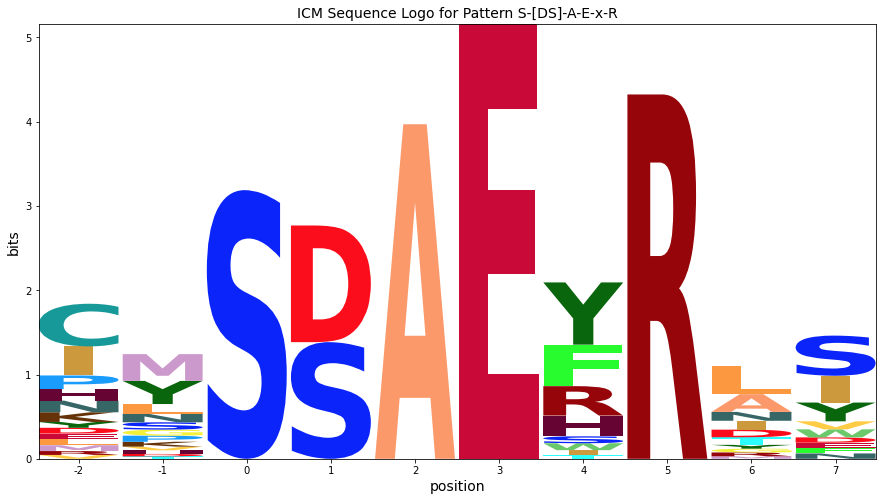

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  3543.4857954545446   0.000000e+00         0.005   
1      7        5  1938.8516729289674   0.000000e+00         0.010   
2      4        2  1495.6978506840144  3.707670e-306         0.015   
3      2        0    827.357957631722  3.277349e-163         0.020   
4      3        1   649.7529684607539  1.557419e-125         0.025   
5      0       -2   648.2884248489668  3.177775e-125         0.030   
6      6        4  454.67426213200844   1.738988e-84         0.035   
7      1       -1  247.46003066919462   1.011111e-41         0.040   
8      8        6  103.52897400454442   1.223657e-13         0.045   
9      9        7  101.86278477102753   2.459801e-13         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.915233212430578     S   -3.743072108186406  
1      0.003414     R   4.078293464850131     S   -3.743072108186405  
2      0.005121     A  3.7251167304793342     S   -3.743072108186406  
3      0.006828     S   2.943428418996813     L   -3.375871084023337  
4      0.008535     D   3.118016681578238     L   -3.375871084023337  
5      0.010243     C   4.509212907885098     S  -3.4561909603982444  
6      0.011950     Y  2.8582873239363655     L  -3.3758710840233377  
7      0.013657     M   2.864806597712056     A  -2.7585669137041973  
8      0.015364     L  1.5392693984885306     S    -3.35149358173155  
9      0.017071     I   2.155811572487039     L  -2.4895278658189044

----------------------------------------------------------------------
W Pattern: D-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A    C         D         E       F         G         H  \
Position                                                                    
0           0.071114  0.0  0.106671  0.177785  0.0000  0.000000  0.000000   
1           0.000000  0.0  0.084197  0.000000  0.0000  0.589380  0.056131   
2           0.000000  0.0  4.348314  0.000000  0.0000  0.000000  0.000000   
3           0.000000  0.0  1.040258  0.000000  0.0000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.0000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.0000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.1937  0.166028  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.0000  0.000000  0.000000   
8           0.507227  0.0  0.063403  0.000000  0.0000  0.000000  0.285315   
9           0.000000  0.0  0.000000  0.000000  0.0000  0.091970  0.137955   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.071114  0.071114  0.106671  0.071114   
1           0.168394  0.000000  0.084197  0.056131  0.000000  0.056131   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.193700  0.000000  0.304386  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.063403  0.000000  0.000000  0.063403  0.000000   
9           0.000000  0.000000  0.091970  0.000000  0.137955  0.873717   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.320012  0.248898  0.000000  0.000000  0.000000  0.000000   
1           0.056131  0.000000  0.056131  0.084197  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  1.634692  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.055343  0.055343  0.055343  0.000000  0.332057   
7           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
8           0.063403  0.095105  0.000000  0.063403  0.095105  0.000000   
9           0.000000  0.000000  0.000000  0.091970  0.091970  0.000000   

Amino Acid         Y  
Position              
0           0.213341  
1           0.056131  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.138357  
7           0.000000  
8           0.158508  
9           0.091970

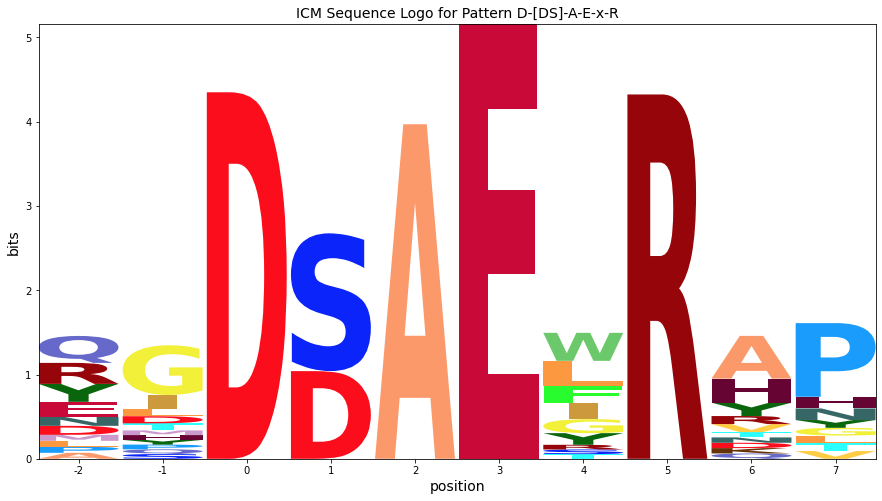

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  1875.9630681818178   0.000000e+00         0.005   
1      2        0  1045.9344262295078  8.236599e-210         0.010   
2      7        5   1026.450885668277  1.194723e-205         0.015   
3      4        2   791.8400385974196  1.165659e-155         0.020   
4      3        1  296.09371694083615   1.262813e-51         0.025   
5      6        4  148.19323945646738   4.886615e-22         0.030   
6      1       -1  135.54443809964005   1.292453e-19         0.035   
7      9        7  114.96374217623661   9.624276e-16         0.040   
8      8        6   113.0085526835208   2.217470e-15         0.045   
9      0       -2  103.75312411316148   1.113768e-13         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.731376370705957     S  -3.0217881362524683  
1      0.003414     D   3.920220648895743     S  -3.0217881362524683  
2      0.005121     R   3.894436623125509     S  -3.0217881362524683  
3      0.006828     A   3.541259888754713     S  -3.0217881362524683  
4      0.008535     D  2.5982925540083803     L  -2.6545871120894002  
5      0.010243     W  2.7538212340194796     P  -2.5565884583869587  
6      0.011950     G   2.340177651663119     A  -2.1181093003913367  
7      0.013657     P   2.193433288604694     S   -2.593694484148179  
8      0.015364     A   2.012422262750889     S  -2.8567288899819716  
9      0.017071     Q   2.368221279727611     S   -2.743072108186406

----------------------------------------------------------------------
X Pattern: S-[DS]-A-E-F
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.121406   
1           0.120175  0.0  0.330480  0.000000  0.000000  0.210306  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  2.206839  0.000000  0.000000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  4.758552  0.000000  0.000000   
7           0.131130  0.0  0.065565  0.098347  0.229477  0.065565  0.000000   
8           0.447695  0.0  0.094252  0.047126  0.047126  0.070689  0.047126   

Amino Acid    I         K         L         M         N         P    Q  \
Position                                                                 
0           0.0  0.060703  0.212460  0.091054  0.121406  0.212460  0.0   
1           0.0  0.120175  0.270393  0.000000  0.000000  0.060087  0.0   
2           0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.0  0.000000  0.000000  0.131130  0.000000  0.000000  0.0   
8           0.0  0.000000  0.094252  0.047126  0.164940  0.000000  0.0   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.000000  0.121406  0.000000  0.060703  0.060703  0.000000  
1           0.060087  0.000000  0.000000  0.150218  0.000000  0.000000  
2           0.000000  3.187665  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.923793  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.786778  0.000000  0.065565  0.000000  0.000000  0.295042  
8           0.070689  0.000000  0.070689  0.000000  0.000000  0.000000

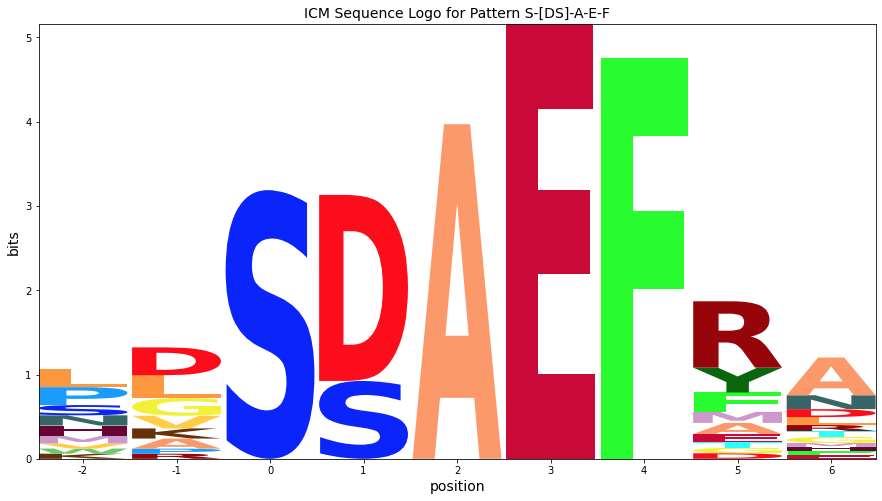

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2119.1434659090905   0.000000e+00      0.005556   
1      6        4   1590.188510260617   0.000000e+00      0.011111   
2      4        2   894.4859695267146  1.683298e-177      0.016667   
3      3        1   604.8138973557311  4.865051e-116      0.022222   
4      2        0   494.7925040738729   6.910684e-93      0.027778   
5      7        5   225.3654847355653   2.886757e-37      0.033333   
6      8        6  106.30572138047815   3.804432e-14      0.038889   
7      1       -1    82.5131321690742   6.832511e-10      0.044444   
8      0       -2   41.71717475833374   1.934921e-03      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.773816330312495     S   -3.152184773508145  
1      0.003928     F   4.372898091565553     S   -3.152184773508145  
2      0.005891     A  3.5836998483612517     S   -3.152184773508145  
3      0.007855     D   3.467895916752704     L   -2.784983749345077  
4      0.009819     S   2.802011536878731     L   -2.784983749345076  
5      0.011783     R  2.6995999243096227     S    -3.07912131131842  
6      0.013747     A  2.1415345162416832     S  -2.9620818901282013  
7      0.015710     D  1.9332768017211883     S   -2.812334770623519  
8      0.017674     M  1.2878053826935827     T  -2.0424815674883505

----------------------------------------------------------------------
Y Pattern: L-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.102771  0.0  0.000000  0.00000  0.000000  0.436778  0.077078   
1           0.057739  0.0  0.023096  0.00000  0.069287  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           0.000000  0.0  1.849148  0.00000  0.000000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.00000  0.123778  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.123209  0.00000  0.000000  0.000000  0.000000   
9           0.000000  0.0  0.000000  0.00000  0.000000  0.166267  0.000000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1           0.034644  0.000000  0.080835  0.046192  0.000000  0.184766   
2           0.000000  0.000000  3.554866  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.222800  0.000000  0.123778  0.247556  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.197135  0.098568  0.073926  0.271061  0.246419  0.000000   
9           0.000000  0.000000  0.124700  0.166267  0.083134  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.205542  0.385392  0.051386  0.128464  0.000000   
1           0.046192  0.000000  0.219410  0.034644  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  1.109489  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.074267  0.396089  0.000000  0.000000  0.000000   
7           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.000000  0.049284  0.147851  0.049284   
9           0.000000  0.290967  0.207834  0.000000  0.000000  0.083134   

Amino Acid         Y  
Position              
0           0.000000  
1           0.034644  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.594134  
7           0.000000  
8           0.172493  
9           0.207834

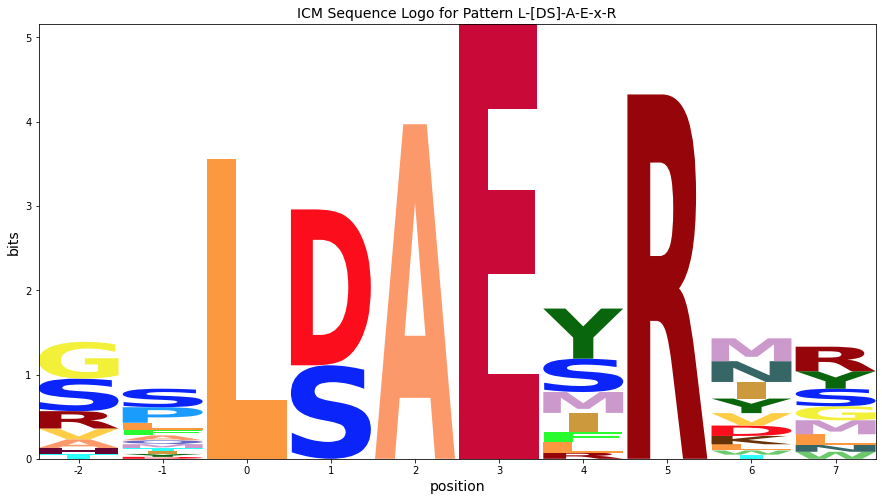

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2501.2840909090914   0.000000e+00         0.005   
1      7        5  1368.6011808910355  6.925253e-279         0.010   
2      4        2  1055.7867181298927  6.469832e-212         0.015   
3      2        0   774.1626847894624  6.637926e-152         0.020   
4      3        1   593.1349579849392  1.417106e-113         0.025   
5      6        4  244.36668870976143   4.270431e-41         0.030   
6      8        6  129.25204976948075   2.019492e-18         0.035   
7      0       -2  108.77384667891101   1.340567e-14         0.040   
8      1       -1   68.96790853396736   1.364243e-07         0.045   
9      9        7   59.53472373115632   4.583389e-06         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E    4.82573262563325     S   -3.335896726680533  
1      0.003414     R  3.9887928780528035     S   -3.335896726680532  
2      0.005121     A  3.6356161436820056     S   -3.335896726680533  
3      0.006828     L  3.2211288563625526     S   -3.335896726680533  
4      0.008535     D  3.3483143010000314     L   -2.968695702517465  
5      0.010243     Y   2.699865529588014     P  -2.8706970488150216  
6      0.011950     M  2.3687253780771504     S   -3.097736989485767  
7      0.013657     G  1.9286805100895235     L  -2.6545871120894002  
8      0.015364     P  1.2167657924353175     G  -2.5553530817808525  
9      0.017071     M  1.6906534729645122     P   -2.047574810899101

----------------------------------------------------------------------
Z Pattern: P-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A        C         D         E         F         G       H  \
Position                                                                        
0           0.092356  0.00000  0.073885  0.000000  0.000000  0.000000  0.0000   
1           0.061463  0.00000  0.000000  0.000000  0.000000  0.086048  0.0000   
2           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0000   
3           0.000000  0.00000  1.588044  0.000000  0.000000  0.000000  0.0000   
4           3.969354  0.00000  0.000000  0.000000  0.000000  0.000000  0.0000   
5           0.000000  0.00000  0.000000  5.159470  0.000000  0.000000  0.0000   
6           0.000000  0.08195  0.000000  0.000000  1.229253  0.054633  0.1639   
7           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0000   
8           0.000000  0.00000  0.300465  0.150233  0.150233  0.000000  0.0000   
9           0.000000  0.00000  0.000000  0.171306  0.000000  0.308350  0.0000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.055413  0.258596  0.129298  0.055413   
1           0.159803  0.000000  0.036878  0.000000  0.098341  0.073755   
2           0.000000  0.000000  0.000000  0.000000  0.000000  3.652865   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.081950  0.000000  0.300484  0.218534  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.050078  0.000000  0.000000  0.000000   
9           0.000000  0.205567  0.102783  0.000000  0.000000  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.036942  0.055413  0.000000  0.498721  0.110827  0.000000   
1           0.000000  0.221266  0.098341  0.000000  0.049170  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  1.257201  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.109267   
7           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.133540  0.367236  0.000000  0.100155  0.000000   
9           0.000000  0.000000  0.137045  1.027834  0.000000  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.172096  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.109267  
7           0.000000  
8           0.116848  
9           0.000000

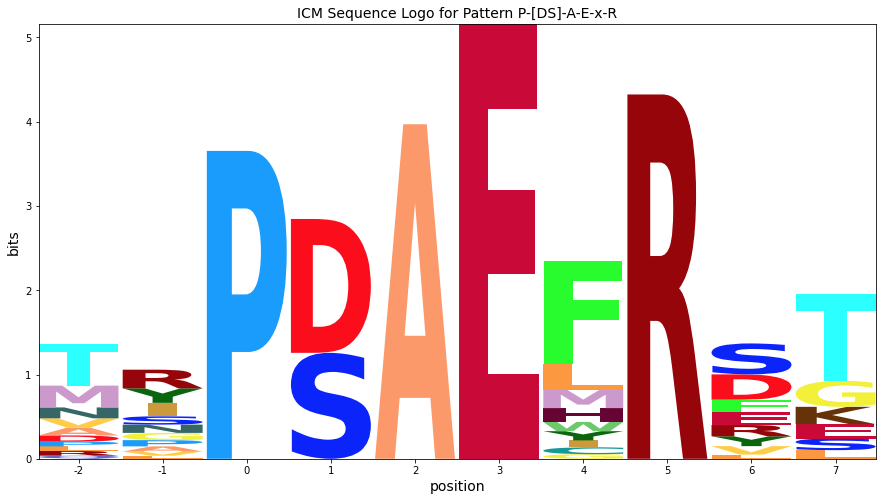

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2987.6448863636356   0.000000e+00         0.005   
1      7        5  1634.7180771754045   0.000000e+00         0.010   
2      4        2   1261.078579988483  7.710648e-256         0.015   
3      2        0   995.7336966030945  4.320039e-199         0.020   
4      6        4   628.1515388047176  5.736967e-121         0.025   
5      3        1   612.6898670509606  1.057896e-117         0.030   
6      9        7   219.0474952285587   5.350311e-36         0.035   
7      0       -2  184.06216956422784   4.895639e-29         0.040   
8      8        6   152.9038944561211   6.024818e-23         0.045   
9      1       -1  140.48494029588014   1.474518e-20         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.874493064095775     S  -3.5402552251867188  
1      0.003414     R   4.037553316515329     S  -3.5402552251867188  
2      0.005121     A  3.6843765821445316     S  -3.5402552251867188  
3      0.006828     P  3.3678879485275206     S  -3.5402552251867188  
4      0.008535     F  3.5541932855571168     S   -3.540255225186718  
5      0.010243     D  3.2351036905520414     L  -3.1730542010236507  
6      0.011950     T  2.4262879157282833     P  -2.6139216334529096  
7      0.013657     M  2.4214668401491237     S  -3.3669236223011567  
8      0.015364     D  1.9238164724721223     P  -3.0195604347295038  
9      0.017071     R  1.8425373341101858     T  -2.9890423085268893

----------------------------------------------------------------------
a Pattern: N-[DS]-A-E-x-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.090286  0.045143  0.067714  0.158000  0.158000   
1           0.000000  0.0  0.099310  0.000000  0.066207  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  1.310305  0.000000  0.000000  0.000000  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.428541  0.000000  0.160703   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.255495  0.000000  0.437991  0.291994  0.000000   
9           0.261604  0.0  0.261604  0.261604  0.000000  0.000000  0.000000   

Amino Acid         I         K         L         M         N         P    Q  \
Position                                                                      
0           0.000000  0.045143  0.000000  0.000000  0.000000  0.180572  0.0   
1           0.082758  0.033103  0.231724  0.099310  0.082758  0.000000  0.0   
2           0.000000  0.000000  0.000000  0.000000  4.252525  0.000000  0.0   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.080351  0.348190  0.133919  0.000000  0.000000  0.0   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
8           0.109498  0.000000  0.255495  0.000000  0.000000  0.000000  0.0   
9           0.112116  0.000000  0.000000  0.000000  0.000000  0.261604  0.0   

Amino Acid         R         S    T         V         W         Y  
Position                                                           
0           0.000000  0.316001  0.0  0.045143  0.000000  0.000000  
1           0.033103  0.115862  0.0  0.066207  0.000000  0.033103  
2           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  
3           0.000000  1.433146  0.0  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  
6           0.000000  0.053568  0.0  0.000000  0.187487  0.401757  
7           4.322530  0.000000  0.0  0.000000  0.000000  0.000000  
8           0.109498  0.000000  0.0  0.000000  0.072999  0.072999  
9           0.000000  0.224232  0.0  0.000000  0.112116  0.000000

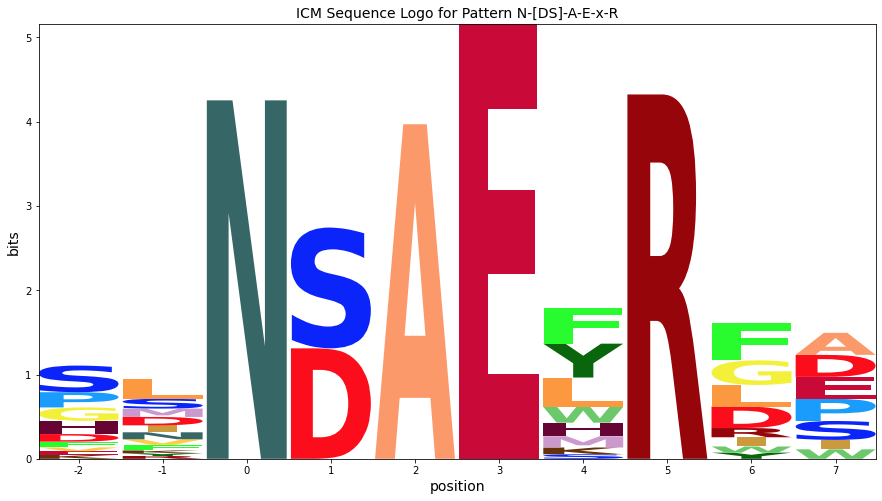

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2327.5838068181824   0.000000e+00         0.005   
1      7        5  1273.5594322180473  1.633824e-258         0.010   
2      2        0  1210.0629900382562  6.498221e-245         0.015   
3      4        2   982.4681960375391  2.928505e-196         0.020   
4      3        1   410.9018303042468   2.362995e-75         0.025   
5      6        4  204.94491346714028   3.527958e-33         0.030   
6      8        6  118.35111896560748   2.253971e-16         0.035   
7      9        7   86.18512208257816   1.561307e-10         0.040   
8      1       -1   63.35884951060019   1.125435e-06         0.045   
9      0       -2  61.770172517347866   2.024216e-06         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.803989368211857     S   -3.255278266472247  
1      0.003414     R  3.9670496206314105     S   -3.255278266472247  
2      0.005121     N  3.8970441260988764     S   -3.255278266472247  
3      0.006828     A   3.613872886260614     S   -3.255278266472247  
4      0.008535     D  2.9497649245097577     L   -2.888077242309179  
5      0.010243     F   2.403071129464914     P  -2.7900785886067365  
6      0.011950     F   2.458991502204395     S   -2.812334770623519  
7      0.013657     E  2.2525794272017268     L  -2.3520243420689697  
8      0.015364     M  1.6097334775809449     P  -2.6139216334529105  
9      0.017071     H  1.4378090903723657     L  -2.5536582032386193

----------------------------------------------------------------------
b Pattern: L-[DS]-A-E-F
Information Content Matrix


Amino Acid         A    C         D         E         F    G        H  \
Position                                                                
0           0.000000  0.0  0.087587  0.087587  0.000000  0.0  0.06569   
1           0.000000  0.0  0.156122  0.034694  0.000000  0.0  0.00000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.00000   
3           0.000000  0.0  2.416542  0.000000  0.000000  0.0  0.00000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.0  0.00000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.0  0.00000   
6           0.000000  0.0  0.000000  0.000000  4.758552  0.0  0.00000   
7           0.000000  0.0  0.161601  0.096960  0.064640  0.0  0.00000   
8           0.000000  0.0  0.000000  0.112227  0.000000  0.0  0.33668   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.043793  0.000000  0.000000  0.087587  0.350346  0.000000   
1           0.069387  0.000000  0.069387  0.121428  0.086734  0.104081   
2           0.000000  0.000000  3.554866  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.193921  0.129280  0.000000  0.000000  0.129280   
8           0.000000  0.149635  0.112227  0.074818  0.336680  0.336680   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.043793  0.000000  0.197070  0.000000  0.262760  0.109483   
1           0.000000  0.000000  0.173469  0.052041  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.820712  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.387841  0.161601  0.000000  0.000000  0.193921  0.000000   
8           0.000000  0.000000  0.074818  0.000000  0.000000  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.364284  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.000000  
8           0.000000

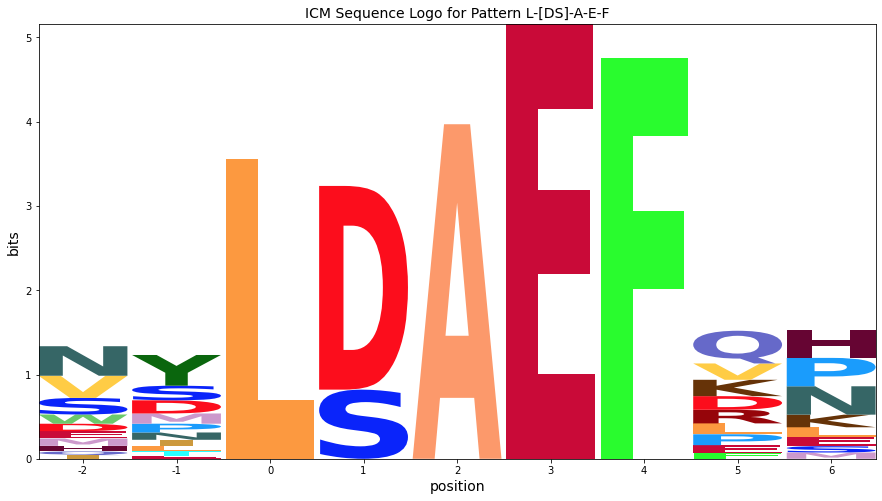

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3    2466.54403409091   0.000000e+00      0.005556   
1      6        4  1850.8751512869476   0.000000e+00      0.011111   
2      4        2  1041.1230137114221  8.781029e-209      0.016667   
3      3        1      776.4512329343  2.167447e-152      0.022222   
4      2        0   763.4104252784979  1.274566e-149      0.027778   
5      1       -1  162.22320729787197   9.368464e-25      0.033333   
6      7        5  129.10749871654642   2.150657e-18      0.038889   
7      0       -2  117.43108694498841   3.345556e-16      0.044444   
8      8        6   96.41442895516539   2.375468e-12      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.821600384053863     S  -3.3201294108222146  
1      0.003928     F    4.42068214530692     S  -3.3201294108222146  
2      0.005891     A  3.6314839021026195     S  -3.3201294108222137  
3      0.007855     D  3.5954071629648054     L  -2.9529283866591465  
4      0.009819     L  3.2169966147831657     S  -3.3201294108222146  
5      0.011783     Y   2.531208274308903     G   -2.539585765922536  
6      0.013747     Q  2.6113810500864547     S   -2.878423961081291  
7      0.015710     N    2.00013761906298     L   -2.784983749345076  
8      0.017674     H  1.9375243044750103     T  -2.1918591915265764

----------------------------------------------------------------------
c Pattern: A-E-[FY]-R-A
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.046874  0.0  0.187496  0.062499  0.000000  0.000000  0.000000   
1           0.056140  0.0  0.280699  0.149706  0.000000  0.074853  0.000000   
2           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  2.451959  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.050790  0.0  0.101581  0.050790  0.000000  0.033860  0.033860   
8           0.096577  0.0  0.064385  0.064385  0.000000  0.000000  0.064385   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.109372  0.000000  0.031249  0.062499   
1           0.000000  0.000000  0.056140  0.000000  0.056140  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.237022  0.000000  0.033860  0.000000  0.000000  0.084651   
8           0.096577  0.321925  0.257540  0.160962  0.000000  0.000000   

Amino Acid         Q         R         S         T         V        W  \
Position                                                                
0           0.046874  0.031249  0.156246  0.187496  0.000000  0.00000   
1           0.000000  0.000000  0.224559  0.261986  0.000000  0.00000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
5           0.000000  4.322530  0.000000  0.000000  0.000000  0.00000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
7           0.000000  0.118511  0.101581  0.033860  0.050790  0.00000   
8           0.000000  0.000000  0.000000  0.064385  0.064385  0.12877   

Amino Acid         Y  
Position              
0           0.000000  
1           0.037427  
2           0.000000  
3           0.000000  
4           1.311513  
5           0.000000  
6           0.000000  
7           0.000000  
8           0.000000

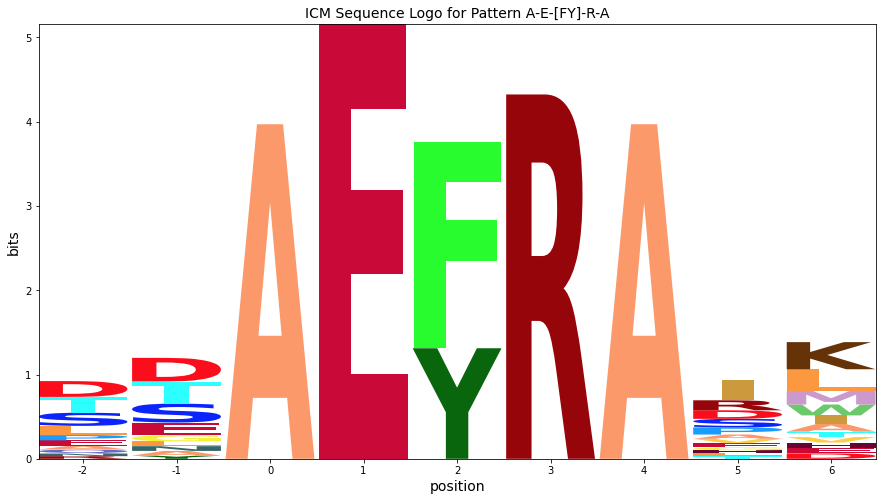

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      3        1  2292.8437499999995   0.000000e+00      0.005556   
1      5        3  1254.5510824834496  1.929267e-254      0.011111   
2      2        0   967.8044916190681  3.939417e-193      0.016667   
3      6        4   967.8044916190681  3.939417e-193      0.022222   
4      4        2   883.9788605894482  2.912267e-175      0.027778   
5      1       -1  116.68141349409017   4.613898e-16      0.033333   
6      8        6  111.74072842730307   3.804935e-15      0.038889   
7      7        5   98.95566307082308   8.273989e-13      0.044444   
8      0       -2   71.44907495192076   5.273484e-08      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E    4.79929445856592     S   -3.238599525325617  
1      0.003928     R   3.962354710985474     S   -3.238599525325617  
2      0.005891     A  3.6091779766146765     S   -3.238599525325618  
3      0.007855     A  3.6091779766146765     S   -3.238599525325618  
4      0.009819     F   3.791718647998502     S   -3.238599525325617  
5      0.011783     D  1.9559968782212724     P  -2.7394525155367684  
6      0.013747     K  2.6631452494413987     S   -2.789614694123435  
7      0.015710     I   2.418845978320833     N  -1.9762939097986152  
8      0.017674     D  1.7449732709640218     G  -2.3355718739009426

----------------------------------------------------------------------
d Pattern: A-E-[FY]-R-T
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.161076  0.0  0.000000  0.053692  0.000000  0.161076  0.000000   
1           0.000000  0.0  0.099773  0.174602  0.000000  0.424034  0.000000   
2           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  2.353048  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.033272  0.000000  0.000000  0.033272  0.033272   
8           0.000000  0.0  0.216759  0.173407  0.260110  0.000000  0.000000   

Amino Acid         I    K         L         M         N         P         Q  \
Position                                                                      
0           0.000000  0.0  0.035795  0.000000  0.196870  0.035795  0.000000   
1           0.049886  0.0  0.000000  0.000000  0.399091  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.066544  0.0  0.199632  0.149724  0.000000  0.216268  0.033272   
8           0.000000  0.0  0.390165  0.000000  0.390165  0.000000  0.000000   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.035795  0.053692  0.232665  0.000000  0.000000  0.071589  
1           0.000000  0.199545  0.199545  0.000000  0.000000  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  1.387695  
5           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  3.738878  0.000000  0.000000  0.000000  
7           0.000000  0.149724  0.000000  0.000000  0.033272  0.049908  
8           0.000000  0.000000  0.000000  0.086703  0.000000  0.130055

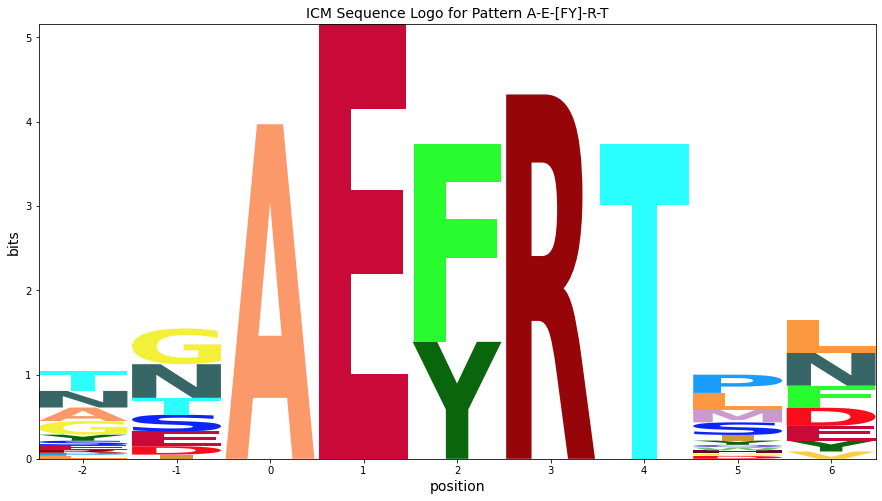

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      3        1  2153.8835227272725   0.000000e+00      0.005556   
1      5        3  1178.5176835450588  3.676418e-238      0.011111   
2      2        0   909.1496739451853  1.264354e-180      0.016667   
3      4        2   806.0658544070957  1.104177e-158      0.022222   
4      6        4    765.763288805168  4.034355e-150      0.027778   
5      1       -1  148.07184488528833   5.156892e-22      0.033333   
6      8        6    89.2117627810844   4.574008e-11      0.038889   
7      0       -2   81.01310395222127   1.243163e-09      0.044444   
8      7        5   80.59100215603853   1.470497e-09      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.779197941692078     S   -3.169886775241603  
1      0.003928     R  3.9422581941116324     S   -3.169886775241603  
2      0.005891     A   3.589081459740835     S   -3.169886775241603  
3      0.007855     F  3.7229278743325813     S   -3.169886775241603  
4      0.009819     T  3.3586060649181424     S   -3.169886775241603  
5      0.011783     N   1.982435617329521     L   -2.802685751078535  
6      0.013747     N  1.7164718804570556     S   -2.670315765751092  
7      0.015710     N   1.552085062556173     V  -2.2093148166627863  
8      0.017674     M  2.0691650962182426     T  -2.5830499488510523

----------------------------------------------------------------------
e Pattern: A-E-[FY]-R-S
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.032127  0.0  0.000000  0.032127  0.080318  0.000000  0.000000   
1           0.040156  0.0  0.321251  0.100391  0.000000  0.080313  0.000000   
2           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  2.091573  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.146444  0.000000   
8           0.000000  0.0  0.000000  0.000000  0.243852  0.069672  0.243852   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.064254  0.048191  0.240954  0.000000  0.000000  0.497971   
1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.125523  0.230126  0.251047  0.041841   
8           0.000000  0.000000  0.104508  0.000000  0.383196  0.418032   

Amino Acid         Q         R         S         T         V    W         Y  
Position                                                                     
0           0.032127  0.096382  0.000000  0.032127  0.000000  0.0  0.112445  
1           0.000000  0.000000  0.582268  0.542111  0.000000  0.0  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.0  1.602056  
5           0.000000  4.322530  0.000000  0.000000  0.000000  0.0  0.000000  
6           0.000000  0.000000  3.187665  0.000000  0.000000  0.0  0.000000  
7           0.041841  0.000000  0.062762  0.251047  0.083682  0.0  0.000000  
8           0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.139344

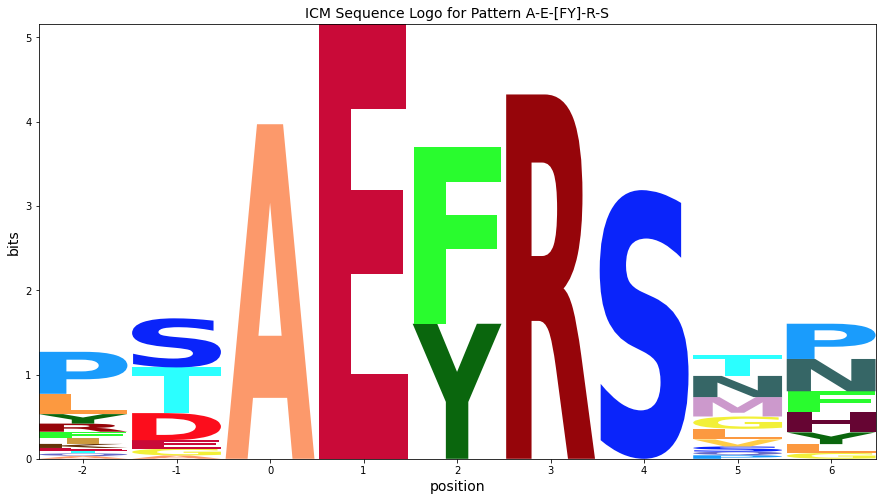

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      3        1  2883.4247159090905   0.000000e+00      0.005556   
1      5        3  1577.6930279716107   0.000000e+00      0.011111   
2      2        0  1217.0874667330709  2.036013e-246      0.016667   
3      4        2  1010.7670291302072  2.668370e-202      0.022222   
4      6        4   673.2422596414995  1.669024e-130      0.027778   
5      1       -1  203.94725681161034   5.576167e-33      0.033333   
6      0       -2  154.41672786142263   3.070898e-23      0.038889   
7      7        5  118.07766726172073   2.534837e-16      0.044444   
8      8        6  109.21413363250083   1.112461e-14      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.865286918405788     S  -3.4988352978067376  
1      0.003928     R  4.0283471708253415     S  -3.4988352978067376  
2      0.005891     A  3.6751704364545446     S  -3.4988352978067376  
3      0.007855     F  3.6570137576012405     S  -3.4988352978067376  
4      0.009819     S   2.893482124972023     L  -3.1316342736436695  
5      0.011783     T  1.8597325409106955     L  -3.1316342736436695  
6      0.013747     P  2.0235082871623824     S  -3.4416913907031286  
7      0.015710     M  2.3503468487622956     A  -2.3344272073181007  
8      0.017674     N  1.7930931620599684     S  -2.8567288899819725

----------------------------------------------------------------------
f Pattern: N-A-E-[FY]-R
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.000000  0.0  0.028127  0.00000  0.098445  0.070318  0.000000   
1           0.000000  0.0  0.037977  0.00000  0.050636  0.291154  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           3.969354  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.00000  1.186291  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
7           0.048207  0.0  0.080345  0.00000  0.032138  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.207689   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.028127  0.210953  0.253144  0.000000  0.028127   
1           0.000000  0.000000  0.000000  0.000000  0.189883  0.101271   
2           0.000000  0.000000  0.000000  0.000000  4.252525  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.032138  0.000000  0.176759  0.000000  0.192828  0.000000   
8           0.000000  0.000000  0.103845  0.138460  0.000000  0.155767   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.042191  0.028127  0.210953  0.042191  0.000000   
1           0.000000  0.025318  0.126589  0.063294  0.037977  0.088612   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
7           0.048207  0.000000  0.000000  0.257104  0.257104  0.048207   
8           0.000000  0.000000  0.155767  0.328842  0.086537  0.034615   

Amino Acid         Y  
Position              
0           0.084381  
1           0.025318  
2           0.000000  
3           0.000000  
4           0.000000  
5           2.548329  
6           0.000000  
7           0.000000  
8           0.000000

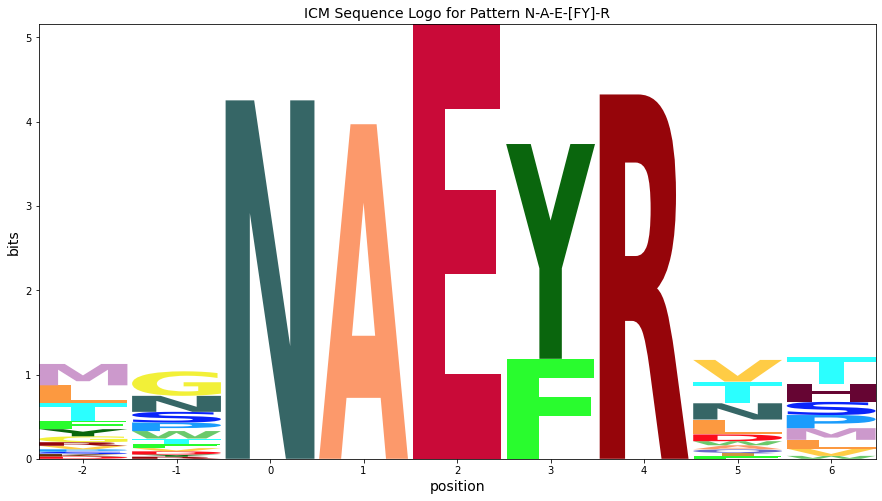

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      2        0   1535.154539600772   0.000000e+00      0.005556   
1      4        2   2952.904829545455   0.000000e+00      0.011111   
2      6        4   1615.709727440806   0.000000e+00      0.016667   
3      3        1  1246.4148755700119  1.067007e-252      0.022222   
4      5        3  1093.4460813172423  5.786319e-220      0.027778   
5      0       -2  166.86307223894937   1.166448e-25      0.033333   
6      1       -1   130.7235200350944   1.063637e-18      0.038889   
7      8        6  116.97385785220682   4.070316e-16      0.044444   
8      7        5  110.51871076578384   6.396378e-15      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     N  3.9645440177332407     S  -3.5265802882896407  
1      0.003928     E   4.871489259846222     S  -3.5265802882896407  
2      0.005891     R   4.034549512265775     S  -3.5265802882896415  
3      0.007855     A  3.6813727778949787     S  -3.5265802882896407  
4      0.009819     Y  3.7479688275660203     S  -3.5265802882896424  
5      0.011783     M  2.6732364198871026     A   -2.674502648915723  
6      0.013747     G   1.880746033025821     L   -3.117559088431946  
7      0.015710     H  1.7549201689619518     G  -2.5236442220535142  
8      0.017674     V  1.6243914323417705     S    -3.35149358173155

----------------------------------------------------------------------
g Pattern: S-x-D-A-E-[FY]
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.052748  0.0  0.000000  0.00000  0.105496  0.131870  0.000000   
1           0.099675  0.0  0.099675  0.00000  0.149513  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           0.031299  0.0  0.093897  0.00000  0.000000  0.031299  0.031299   
4           0.000000  0.0  4.348314  0.00000  0.000000  0.000000  0.000000   
5           3.969354  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.00000  2.716802  0.000000  0.000000   
8           0.057891  0.0  0.000000  0.00000  0.144728  0.115783  0.000000   
9           0.000000  0.0  0.190554  0.00000  0.000000  0.076222  0.076222   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.052748  0.158244  0.131870  0.052748  0.000000  0.105496   
1           0.000000  0.000000  0.049838  0.000000  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.125196  0.046948  0.140845  0.156495  0.172144  0.234742   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.347348  0.000000  0.000000  0.173674   
9           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.290113  0.000000  0.000000  0.105496  0.000000   
1           0.000000  0.000000  0.124594  0.099675  0.323944  0.124594   
2           0.000000  0.000000  3.187665  0.000000  0.000000  0.000000   
3           0.062598  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.549968  0.057891  0.000000  0.000000  0.000000   
9           0.000000  0.533551  0.190554  0.000000  0.457330  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.149513  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           1.118683  
8           0.057891  
9           0.152443

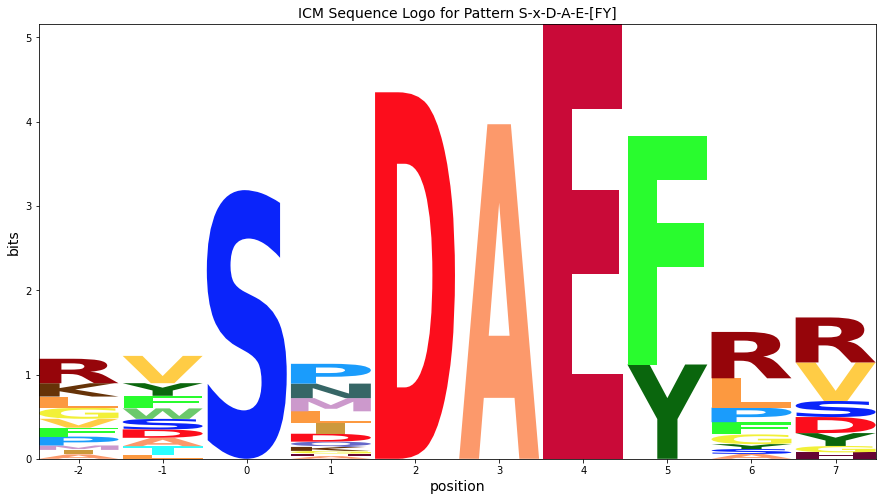

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      6        4  2501.2840909090914   0.000000e+00         0.005   
1      4        2  1394.5792349726773  1.856457e-284         0.010   
2      5        3  1055.7867181298927  6.469832e-212         0.015   
3      7        5  1052.3071917434459  3.583438e-211         0.020   
4      2        0   584.0173818576859  1.186511e-111         0.025   
5      8        6    149.731493089401   2.469119e-22         0.030   
6      9        7  129.31953471753832   1.961019e-18         0.035   
7      3        1  107.71023973671021   2.102477e-14         0.040   
8      1       -1   87.94872112804673   7.643728e-11         0.045   
9      0       -2   79.89299484507436   1.940288e-09         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E    4.82573262563325     S   -3.335896726680533  
1      0.003414     D   4.014576903823036     S   -3.335896726680533  
2      0.005121     A  3.6356161436820056     S   -3.335896726680533  
3      0.006828     F   3.935429546147381     S   -3.335896726680533  
4      0.008535     S   2.853927832199485     L   -2.968695702517464  
5      0.010243     R    2.47453336867485     T  -2.4310468554060027  
6      0.011950     R   2.229420870838318     L   -2.445133746460451  
7      0.013657     M  2.0050347587985264     S   -3.335896726680532  
8      0.015364     V  1.7749178674788975     P  -2.4556595495361777  
9      0.017071     K   1.965980663333168     S  -2.8347025836519726

----------------------------------------------------------------------
h Pattern: S-x-A-E-[FY]-R
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.000000  0.791634  0.000000  0.000000  0.000000  0.000000   
1           0.078300  0.000000  0.000000  0.000000  0.000000  0.097875   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.241196  0.034457  0.000000  0.292881   
4           3.969354  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  1.524664  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.151614  0.000000  0.136453  0.000000  0.030323  0.106130   
9           0.029205  0.000000  0.029205  0.058410  0.029205  0.000000   

Amino Acid         H         I         K         L        M         N  \
Position                                                                
0           0.143933  0.000000  0.179917  0.251884  0.10795  0.143933   
1           0.058725  0.000000  0.078300  0.254475  0.43065  0.078300   
2           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
3           0.000000  0.051685  0.000000  0.000000  0.00000  0.172283   
4           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
8           0.000000  0.075807  0.000000  0.060646  0.00000  0.136453   
9           0.000000  0.146024  0.000000  0.000000  0.00000  0.043807   

Amino Acid         P         Q         R         S         T         V  \
Position                                                                 
0           0.000000  0.000000  0.000000  0.107950  0.107950  0.431800   
1           0.137025  0.000000  0.000000  0.039150  0.000000  0.117450   
2           0.000000  0.000000  0.000000  3.187665  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.792502  0.034457  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  4.322530  0.000000  0.000000  0.000000   
8           0.000000  0.030323  0.000000  0.000000  0.045484  0.227422   
9           0.029205  0.000000  0.029205  0.204434  0.146024  0.043807   

Amino Acid         W         Y  
Position                        
0           0.000000  0.000000  
1           0.000000  0.000000  
2           0.000000  0.000000  
3           0.000000  0.000000  
4           0.000000  0.000000  
5           0.000000  0.000000  
6           0.000000  2.150167  
7           0.000000  0.000000  
8           0.030323  0.000000  
9           0.000000  0.102217

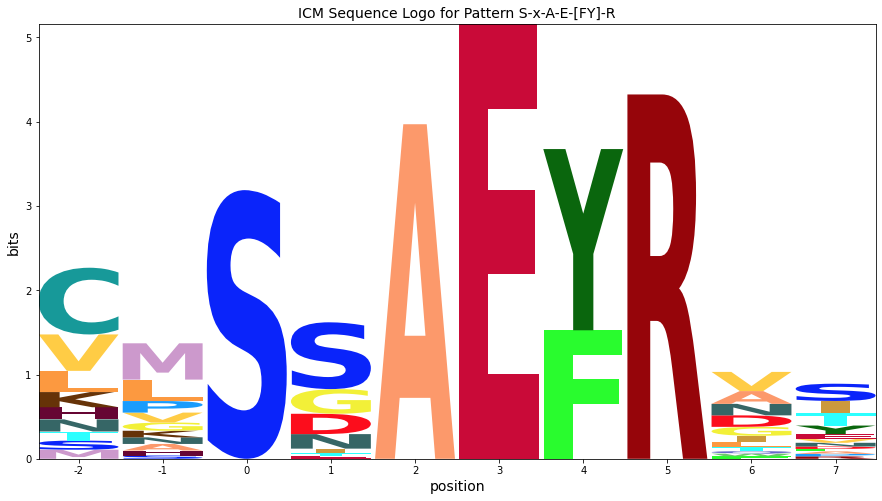

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  3265.5653409090896   0.000000e+00         0.005   
1      7        5  1786.7848750521857   0.000000e+00         0.010   
2      4        2  1378.3882153362485  5.514091e-281         0.015   
3      6        4  1113.4536760686356  3.052258e-224         0.020   
4      0       -2   778.5189718098095  7.883819e-153         0.025   
5      2        0   762.4671374253122  2.021355e-149         0.030   
6      1       -1  233.31877597579629   7.248065e-39         0.035   
7      3        1   226.6197843567274   1.615619e-37         0.040   
8      8        6   89.15458420266735   4.681746e-11         0.045   
9      9        7   74.15072212868725   1.853267e-08         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.896435616976452     S  -3.6452247847882613  
1      0.003414     R   4.059495869396005     S  -3.6452247847882613  
2      0.005121     A   3.706319135025208     S  -3.6452247847882613  
3      0.006828     Y  3.5540362037631636     S  -3.6452247847882613  
4      0.008535     C   4.778029666312898     P   -2.722174524104934  
5      0.010243     S   2.924630823542687     L   -3.278023760625193  
6      0.011950     M  3.1008739559455805     T  -2.7529749502933654  
7      0.013657     S  1.9093640668893765     L   -3.278023760625193  
8      0.015364     V  1.6166557835621655     S  -3.2717663892608164  
9      0.017071     I  1.8603556889608677     L   -2.784983749345076

----------------------------------------------------------------------
i Pattern: D-A-E-[FY]-A
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.000000  0.000000  0.000000  0.092331  0.415490   
1           0.129228  0.0  0.000000  0.000000  0.000000  0.000000  0.129228   
2           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
3           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  2.623576  0.000000  0.000000   
6           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.077327  0.000000  0.128879  0.000000  0.103103   
8           0.000000  0.0  0.000000  0.101172  0.000000  0.050586  0.000000   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.092331  0.000000  0.000000  0.000000  0.184662   
1           0.051691  0.000000  0.000000  0.077537  0.051691  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.051552  0.051552  0.128879  0.000000   
8           0.000000  0.050586  0.050586  0.126466  0.075879  0.151759   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.000000  0.092331  0.323159  0.323159  0.000000   
1           0.000000  0.103382  0.129228  0.232610  0.051691  0.051691   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.231982  0.000000  0.077327  0.051552  0.051552  0.103103   
8           0.000000  0.101172  0.227638  0.000000  0.050586  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
5           1.184841  
6           0.000000  
7           0.051552  
8           0.000000

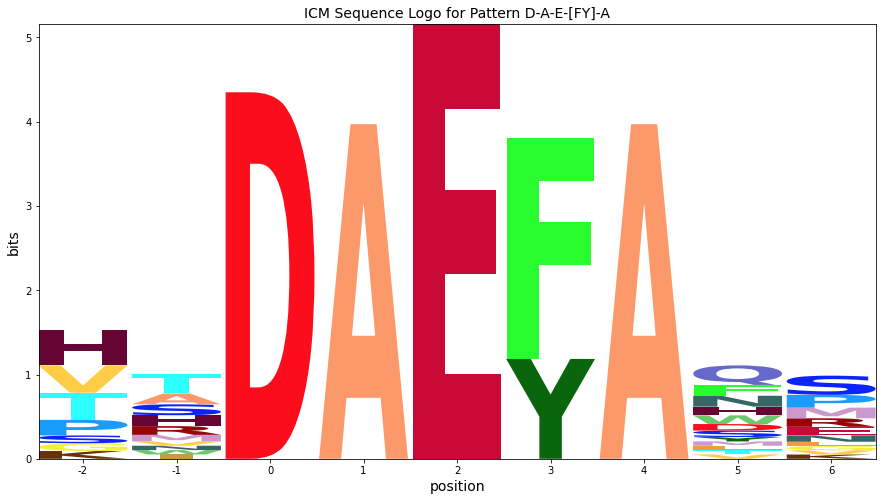

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  1563.3025568181815   0.000000e+00      0.005556   
1      2        0   871.6120218579233  1.252471e-172      0.011111   
2      3        1   659.8666988311829  1.129995e-127      0.016667   
3      6        4   659.8666988311829  1.129995e-127      0.022222   
4      5        3   637.2097919061516  6.988601e-123      0.027778   
5      0       -2   82.71845827554655   6.293733e-10      0.033333   
6      7        5   81.54867016392204   1.004271e-09      0.038889   
7      8        6   48.58551873391664   2.110113e-04      0.044444   
8      1       -1  45.909485391217174   5.104713e-04      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E  4.6606641658388055     S  -2.8347025836519726  
1      0.003928     D   3.849508444028592     S  -2.8347025836519726  
2      0.005891     A  3.4705476838875624     S  -2.8347025836519726  
3      0.007855     A  3.4705476838875624     S  -2.8347025836519726  
4      0.009819     F  3.7361839710348494     S  -2.8347025836519726  
5      0.011783     H   2.140341187474698     L  -2.1730542010236498  
6      0.013747     Q   2.321678693790581     P  -2.3244150162579253  
7      0.015710     M  1.7714845475775576     T  -2.1437649033255313  
8      0.017674     H  1.2486529985098498     L  -2.3277767958222917

----------------------------------------------------------------------
j Pattern: G-A-E-[FY]-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.065831  0.0  0.000000  0.000000  0.000000  0.032915  0.000000   
1           0.055707  0.0  0.027854  0.027854  0.000000  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  3.968209  0.000000   
3           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  1.805713  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.056461  0.0  0.000000  0.000000  0.000000  0.056461  0.042346   
8           0.000000  0.0  0.100470  0.066980  0.000000  0.000000  0.000000   

Amino Acid         I    K         L        M         N         P         Q  \
Position                                                                     
0           0.032915  0.0  0.181035  0.00000  0.000000  0.082289  0.000000   
1           0.000000  0.0  0.027854  0.00000  0.055707  0.069634  0.069634   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
7           0.028231  0.0  0.028231  0.00000  0.155268  0.000000  0.028231   
8           0.050235  0.0  0.033490  0.06698  0.050235  0.284665  0.033490   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.032915  0.181035  0.246866  0.049373  0.000000  0.000000  
1           0.027854  0.236756  0.222829  0.000000  0.000000  0.055707  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  1.862142  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.056461  0.056461  0.239960  0.070576  0.098807  0.000000  
8           0.033490  0.100470  0.000000  0.000000  0.083725  0.083725

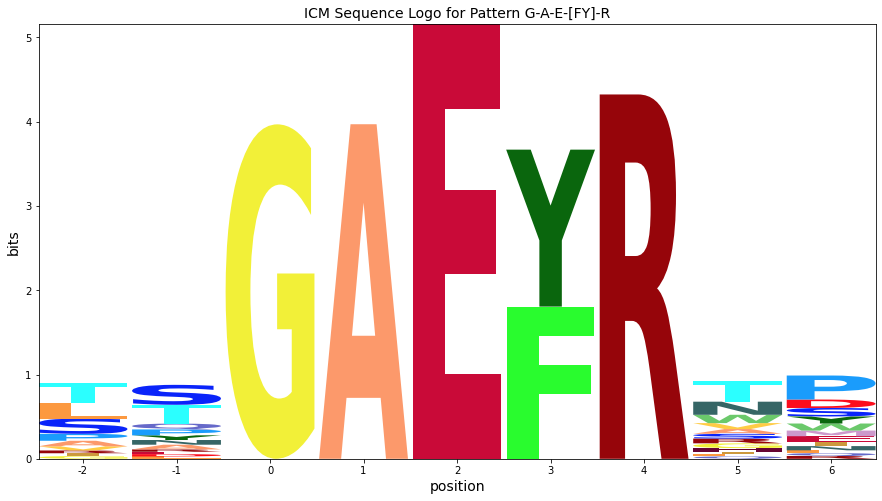

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2   2258.103693181817   0.000000e+00      0.005556   
1      6        4  1235.5427327488521  2.273708e-250      0.011111   
2      3        1   953.1407872005975  5.289004e-190      0.016667   
3      2        0   952.3332918636478  7.863162e-190      0.022222   
4      5        3   762.0281034341713  2.505285e-149      0.027778   
5      7        5   87.69182562004076   8.483530e-11      0.033333   
6      8        6   77.07189299826285   5.912284e-09      0.038889   
7      1       -1   71.00793779313852   6.248841e-08      0.044444   
8      0       -2    63.0897996550528   1.243504e-06      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E  4.7944732060309985     S    -3.22172570676122  
1      0.003928     R  3.9575334584505515     S   -3.221725706761221  
2      0.005891     A  3.6043567240797554     S    -3.22172570676122  
3      0.007855     G   3.603212057496913     S    -3.22172570676122  
4      0.009819     F   3.393554967284055     S   -3.221725706761221  
5      0.011783     W  1.8534439453696354     P  -2.7565260288957103  
6      0.013747     W  1.5440166340513906     T   -2.564902602140793  
7      0.015710     T  1.4513015559397235     G   -2.406830557070765  
8      0.017674     T   1.510059455540428     N   -1.976293909798616

----------------------------------------------------------------------
k Pattern: S-G-E-[FY]-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.042609  0.0  0.000000  0.213043  0.042609  0.000000  0.000000   
1           0.104721  0.0  0.104721  0.392704  0.078541  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  3.968209  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  2.276309  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.075045  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.301879   

Amino Acid         I    K         L         M         N         P         Q  \
Position                                                                      
0           0.127826  0.0  0.063913  0.042609  0.127826  0.042609  0.000000   
1           0.000000  0.0  0.261803  0.052361  0.052361  0.157082  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.412745  0.300178  0.075045  0.000000  0.300178   
8           0.000000  0.0  0.067084  0.000000  0.000000  0.134168  0.067084   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.000000  0.085217  0.191739  0.000000  0.000000  0.127826  
1           0.157082  0.000000  0.000000  0.000000  0.052361  0.000000  
2           0.000000  3.187665  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  1.448560  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.000000  0.337701  0.075045  0.000000  0.000000  0.000000  
8           0.067084  0.201253  0.067084  0.067084  0.000000  0.268337

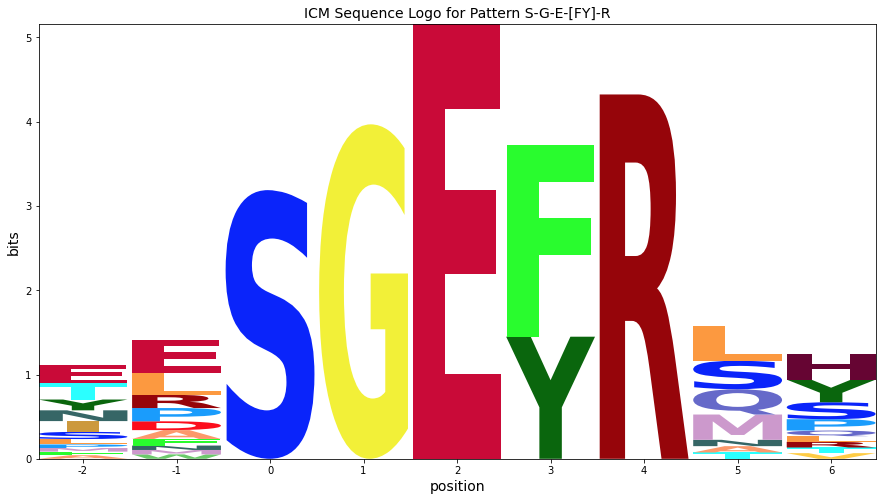

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  1875.9630681818178   0.000000e+00      0.005556   
1      6        4   1026.450885668277  1.194723e-205      0.011111   
2      3        1    791.169196317492  1.618537e-155      0.016667   
3      5        3   687.1536607842019  1.891974e-133      0.022222   
4      2        0   438.0130363932645   5.260881e-81      0.027778   
5      1       -1   160.3353546672426   2.182631e-24      0.033333   
6      7        5  113.15647492504958   2.081947e-15      0.038889   
7      0       -2   97.46186627007935   1.539027e-12      0.044444   
8      8        6   79.92059442195176   1.919157e-09      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.731376370705957     S  -3.0217881362524683  
1      0.003928     R   3.894436623125509     S  -3.0217881362524683  
2      0.005891     G   3.540115222171871     S  -3.0217881362524683  
3      0.007855     F   3.636561259684693     S  -3.0217881362524683  
4      0.009819     S  2.7595715772721907     L  -2.6545871120894002  
5      0.011783     E  2.9500166571812962     S  -3.0217881362524692  
6      0.013747     M    2.28489378727368     P  -2.3013314031448835  
7      0.015710     E  2.4489766400052315     G  -2.2017161271661516  
8      0.017674     H  2.0353716278731553     G  -1.8646811398885808

----------------------------------------------------------------------
l Pattern: P-x-A-E-[FY]-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.000000  0.000000  0.000000  0.046776  0.031184   
1           0.213802  0.0  0.000000  0.000000  0.000000  0.125766  0.037730   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.294158  0.000000  0.000000  0.081710  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  2.721523  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.071508  0.0  0.375419  0.000000  0.160894  0.000000  0.053631   
9           0.000000  0.0  0.000000  0.138748  0.083249  0.194247  0.000000   

Amino Acid         I    K         L         M         N         P    Q  \
Position                                                                 
0           0.000000  0.0  0.077960  0.077960  0.171513  0.000000  0.0   
1           0.050306  0.0  0.088036  0.000000  0.062883  0.088036  0.0   
2           0.000000  0.0  0.000000  0.000000  0.000000  3.652865  0.0   
3           0.000000  0.0  0.049026  0.000000  0.130737  0.000000  0.0   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
8           0.000000  0.0  0.053631  0.053631  0.000000  0.000000  0.0   
9           0.000000  0.0  0.000000  0.000000  0.332994  0.000000  0.0   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.000000  0.218289  0.389802  0.093552  0.000000  0.046776  
1           0.226379  0.000000  0.000000  0.037730  0.000000  0.150919  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.506605  0.310500  0.000000  0.000000  0.032684  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.000000  1.115378  
7           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.000000  0.554191  0.035754  0.000000  0.107263  0.000000  
9           0.000000  0.110998  0.860236  0.000000  0.083249  0.000000

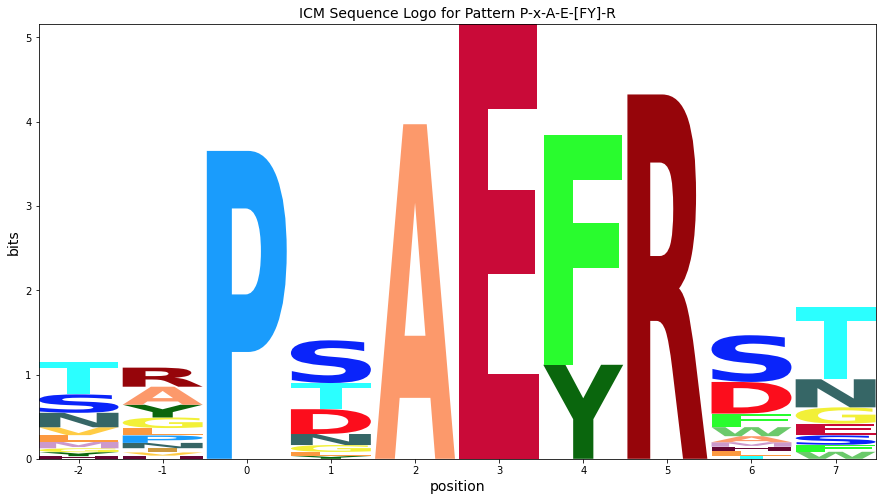

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2987.6448863636356   0.000000e+00         0.005   
1      7        5  1634.7180771754045   0.000000e+00         0.010   
2      4        2   1261.078579988483  7.710648e-256         0.015   
3      6        4  1258.9598866511901  2.192613e-255         0.020   
4      2        0   995.7336966030945  4.320039e-199         0.025   
5      9        7  211.46814472219367   1.759967e-34         0.030   
6      8        6  189.16839786003496   4.795775e-30         0.035   
7      3        1   169.6733744429433   3.292140e-26         0.040   
8      1       -1  128.84131254586825   2.414820e-18         0.045   
9      0       -2  123.65348219605616   2.292774e-17         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.874493064095775     S  -3.5402552251867188  
1      0.003414     R   4.037553316515329     S  -3.5402552251867188  
2      0.005121     A  3.6843765821445316     S  -3.5402552251867188  
3      0.006828     F   3.984827639886979     S  -3.5402552251867188  
4      0.008535     P  3.3678879485275206     S  -3.5402552251867188  
5      0.010243     T  2.3294872098986077     L  -2.8545246825981527  
6      0.011950     D  2.1353205776658344     P  -3.0195604347295038  
7      0.013657     D  1.8683213598804187     P  -3.0750555473212073  
8      0.015364     R  1.8425373341101858     S   -3.540255225186718  
9      0.017071     T  1.8847290124997642     P   -2.901723944435646

----------------------------------------------------------------------
m Pattern: N-x-A-E-[FY]-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.208136  0.000000  0.000000  0.242826  0.000000   
1           0.000000  0.0  0.000000  0.000000  0.107125  0.133906  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.088011  0.044005  0.000000  0.088011  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  2.268969  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.052790  0.0  0.184763  0.000000  0.131974  0.000000  0.131974   
9           0.210479  0.0  0.060137  0.210479  0.000000  0.150342  0.060137   

Amino Acid         I    K    L         M         N         P        Q  \
Position                                                                
0           0.000000  0.0  0.0  0.069379  0.416272  0.138757  0.00000   
1           0.187468  0.0  0.0  0.562404  0.053562  0.000000  0.00000   
2           0.000000  0.0  0.0  0.000000  4.252525  0.000000  0.00000   
3           0.000000  0.0  0.0  0.000000  0.330039  0.110013  0.00000   
4           0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.00000   
5           0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.00000   
6           0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.00000   
7           0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.00000   
8           0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.05279   
9           0.000000  0.0  0.0  0.000000  0.000000  0.000000  0.00000   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.000000  0.450962  0.000000  0.000000  0.000000  0.000000  
1           0.187468  0.241030  0.053562  0.107125  0.000000  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.594071  0.154018  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.000000  1.454467  
7           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.131974  0.000000  0.290342  0.290342  0.000000  0.052790  
9           0.000000  0.270616  0.180411  0.000000  0.240548  0.000000

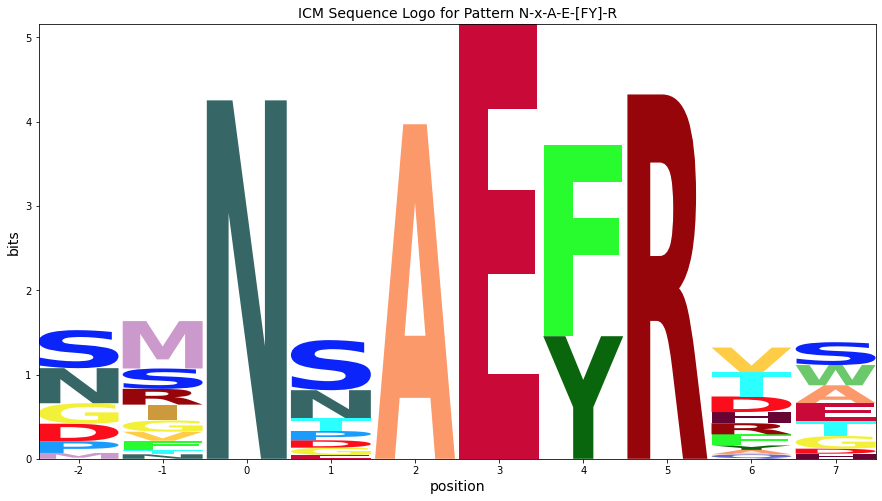

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3   2223.363636363636   0.000000e+00         0.005   
1      7        5   1216.534383014254  2.674275e-246         0.010   
2      2        0  1155.8810651111703  2.567043e-233         0.015   
3      4        2   938.4770827821268  7.086729e-187         0.020   
4      6        4   812.8045191595253  4.077667e-160         0.025   
5      1       -1  251.41757192150595   1.597734e-42         0.030   
6      3        1  133.16820431095354   3.657544e-19         0.035   
7      9        7  100.97658817058243   3.562897e-13         0.040   
8      0       -2   95.09754911503266   4.094067e-12         0.045   
9      8        6   83.99509891134524   3.772576e-10         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.789520413059941     S   -3.204652193402279  
1      0.003414     R   3.952580665479494     S   -3.204652193402279  
2      0.005121     N    3.88257517094696     S   -3.204652193402279  
3      0.006828     A   3.599403931108698     S   -3.204652193402279  
4      0.008535     F  3.6881624561719057     S   -3.204652193402279  
5      0.010243     M  3.1887467119709143     L   -2.784983749345076  
6      0.011950     N   1.860207357918505     L   -2.837451169239211  
7      0.013657     W  2.3883657635911963     L  -2.4895278658189044  
8      0.015364     N  1.9529644988383574     L   -2.445133746460451  
9      0.017071     V  1.5317668859756526     S  -2.9416177875684855

----------------------------------------------------------------------
n Pattern: L-D-A-E-[FY]
Information Content Matrix


Amino Acid         A    C         D         E         F    G         H  \
Position                                                                 
0           0.084036  0.0  0.084036  0.000000  0.000000  0.0  0.105045   
1           0.000000  0.0  0.229432  0.050985  0.050985  0.0  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
3           0.000000  0.0  4.348314  0.000000  0.000000  0.0  0.000000   
4           3.969354  0.0  0.000000  0.000000  0.000000  0.0  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.0  0.000000   
6           0.000000  0.0  0.000000  0.000000  3.367002  0.0  0.000000   
7           0.000000  0.0  0.187853  0.112712  0.075141  0.0  0.000000   
8           0.000000  0.0  0.000000  0.121027  0.000000  0.0  0.363082   

Amino Acid        I         K         L         M         N         P  \
Position                                                                
0           0.00000  0.000000  0.000000  0.084036  0.189081  0.000000   
1           0.10197  0.000000  0.000000  0.000000  0.127462  0.101970   
2           0.00000  0.000000  3.554866  0.000000  0.000000  0.000000   
3           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.00000  0.225424  0.150282  0.000000  0.000000  0.000000   
8           0.00000  0.161370  0.242054  0.000000  0.000000  0.363082   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.042018  0.000000  0.252108  0.000000  0.294126  0.105045   
1           0.000000  0.000000  0.229432  0.076477  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.450847  0.338135  0.000000  0.000000  0.225424  0.000000   
8           0.000000  0.000000  0.080685  0.161370  0.000000  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.662804  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.698812  
7           0.000000  
8           0.000000

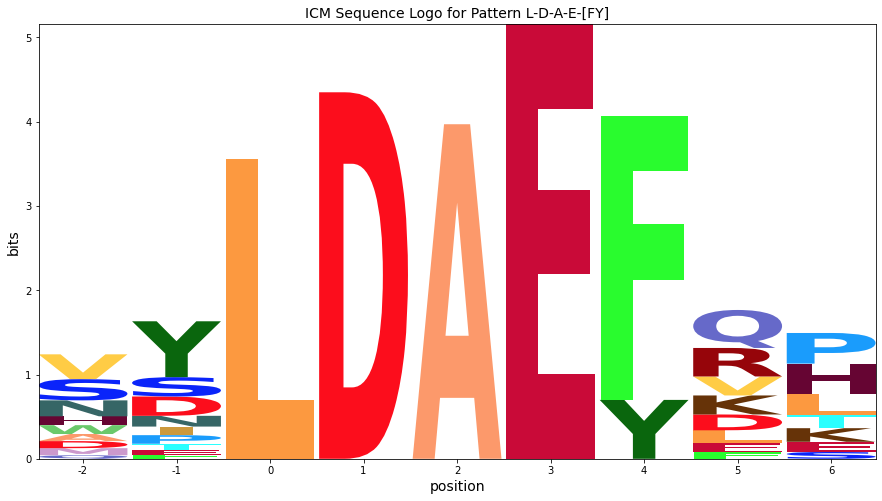

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3   2223.363636363636   0.000000e+00      0.005556   
1      3        1  1239.6259866423802  3.035478e-251      0.011111   
2      6        4  1169.2663400360964  3.509831e-236      0.016667   
3      4        2   938.4770827821268  7.086729e-187      0.022222   
4      2        0   688.1446087017445  1.166910e-133      0.027778   
5      1       -1  248.94319170942555   5.065311e-42      0.033333   
6      7        5  148.66526051174017   3.963480e-22      0.038889   
7      0       -2   92.61764036620677   1.136344e-11      0.044444   
8      8        6   84.26272846814182   3.387971e-10      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.789520413059941     S   -3.204652193402279  
1      0.003928     D  3.9783646912497277     S   -3.204652193402279  
2      0.005891     F   4.121121863448012     S   -3.204652193402279  
3      0.007855     A   3.599403931108698     S   -3.204652193402279  
4      0.009819     L   3.184916643789244     S   -3.204652193402279  
5      0.011783     Y  2.9421413752550105     L  -2.8374511692392117  
6      0.013747     Q  2.6113810500864547     S   -2.878423961081291  
7      0.015710     V   1.679197249630878     L   -2.748914494637554  
8      0.017674     H   2.035371627873155     G  -1.8646811398885816

----------------------------------------------------------------------
o Pattern: S-E-F-R-[LV]
Information Content Matrix


Amino Acid         A    C         D         E         F         G    H  \
Position                                                                 
0           0.000000  0.0  0.158468  0.000000  0.079234  0.079234  0.0   
1           0.000000  0.0  0.193067  0.000000  0.000000  0.085808  0.0   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.0   
4           0.000000  0.0  0.000000  0.000000  4.758552  0.000000  0.0   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.000000  0.0  0.247453  0.000000  0.029112  0.000000  0.0   
8           0.028127  0.0  0.126573  0.042191  0.098446  0.239083  0.0   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.158468  0.031694  0.000000  0.000000   
1           0.000000  0.000000  0.000000  0.000000  0.300326  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  1.082710  0.000000  0.000000  0.000000   
7           0.000000  0.029112  0.087337  0.000000  0.101893  0.000000   
8           0.028127  0.000000  0.056255  0.000000  0.042191  0.028127   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.000000  0.443712  0.079234  0.000000  0.110928   
1           0.000000  0.000000  0.965335  0.214519  0.000000  0.000000   
2           0.000000  0.000000  3.187665  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  1.851084  0.000000   
7           0.029112  0.101893  0.043668  0.232897  0.116449  0.058224   
8           0.042191  0.000000  0.042191  0.182828  0.000000  0.000000   

Amino Acid         Y  
Position              
0           0.031694  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.000000  
6           0.000000  
7           0.000000  
8           0.000000

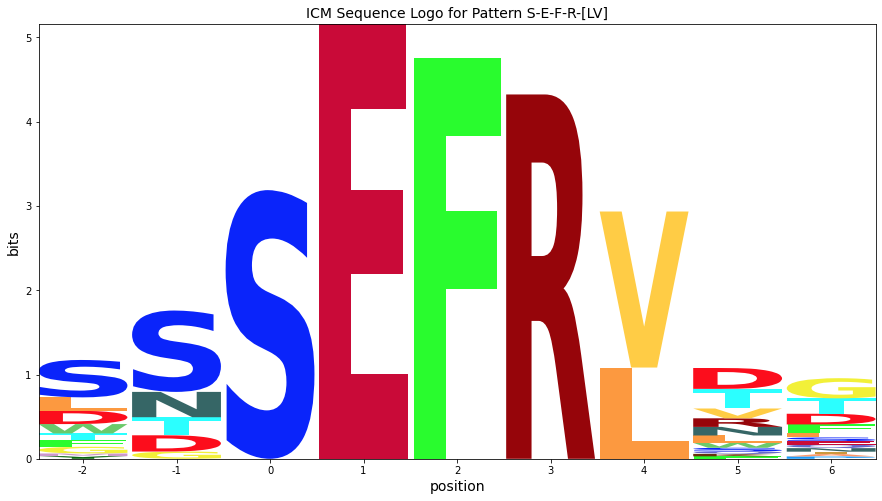

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      3        1  2918.1647727272716   0.000000e+00      0.005556   
1      4        2  2189.7677846211777   0.000000e+00      0.011111   
2      5        3  1596.7013777062084   0.000000e+00      0.016667   
3      2        0   681.3536121673004  3.200235e-132      0.022222   
4      6        4   614.4747203644638  4.441907e-118      0.027778   
5      1       -1  228.02193716250298   8.441566e-38      0.033333   
6      0       -2  113.41194342797851   1.867046e-15      0.038889   
7      7        5  112.44788471887776   2.815861e-15      0.044444   
8      8        6   94.09443032504655   6.191344e-12      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.868421240806856     S    -3.51277448876461  
1      0.003928     F   4.467503002059913     S    -3.51277448876461  
2      0.005891     R   4.031481493226409     S   -3.512774488764611  
3      0.007855     S   2.896616447373091     L  -3.1455734646015427  
4      0.009819     V  3.1305351862218385     S  -3.5127744887646117  
5      0.011783     S  2.0388018434619983     L   -3.117559088431946  
6      0.013747     W  1.7082460298296995     P   -2.901723944435646  
7      0.015710     D  1.9636504507647072     P   -2.901723944435646  
8      0.017674     G  1.6787022570811763     V   -2.383344216437834

----------------------------------------------------------------------
p Pattern: D-A-E-x-R-[LV]
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.096463  0.000000  0.077170  0.077170  0.028939  0.000000   
1           0.094592  0.016693  0.000000  0.016693  0.072335  0.011128   
2           0.000000  0.000000  4.348314  0.000000  0.000000  0.000000   
3           3.969354  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
5           0.000000  0.037809  0.000000  0.000000  0.000000  0.025206   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.042818  0.000000  0.142727  0.028545  0.000000  0.156999   
9           0.000000  0.093149  0.000000  0.000000  0.000000  0.062099   

Amino Acid         H         I    K         L         M         N         P  \
Position                                                                      
0           0.212219  0.028939  0.0  0.019293  0.000000  0.028939  0.028939   
1           0.033385  0.000000  0.0  0.050078  0.027821  0.038950  0.016693   
2           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
5           0.252060  0.063015  0.0  0.302472  0.037809  0.025206  0.000000   
6           0.000000  0.000000  0.0  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.0  1.656336  0.000000  0.000000  0.000000   
8           0.000000  0.000000  0.0  0.042818  0.042818  0.028545  0.042818   
9           0.341545  0.000000  0.0  0.558892  0.217347  0.000000  0.000000   

Amino Acid         Q         R         S         T         V         W  \
Position                                                                 
0           0.000000  0.067524  0.048231  0.048231  0.019293  0.000000   
1           0.000000  0.000000  0.100156  0.066771  0.050078  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.214251  0.000000  0.025206  0.063015  0.025206   
6           0.000000  4.322530  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  1.135774  0.000000   
8           0.042818  0.156999  0.071363  0.000000  0.000000  0.000000   
9           0.000000  0.093149  0.062099  0.093149  0.000000  0.000000   

Amino Acid         Y  
Position              
0           0.173633  
1           0.011128  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.415899  
6           0.000000  
7           0.000000  
8           0.114181  
9           0.062099

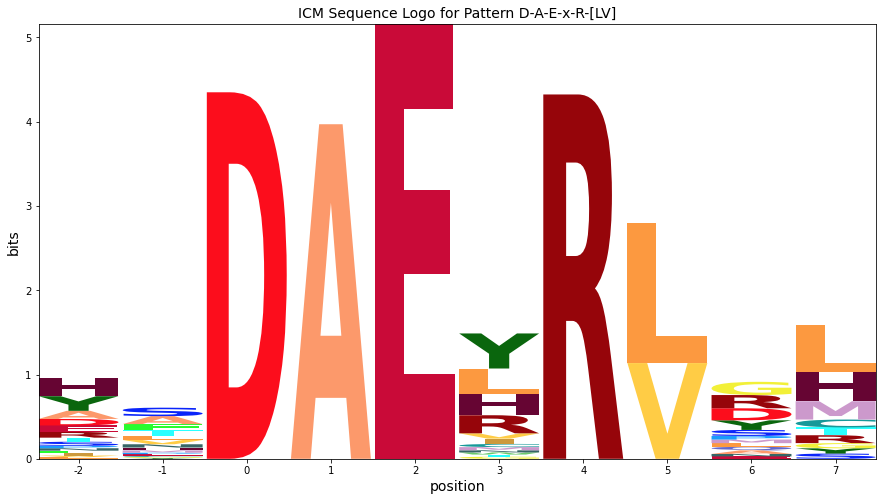

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      2        0  2285.5604128718887   0.000000e+00         0.005   
1      3        1  1730.3171213795463   0.000000e+00         0.010   
2      4        2   4099.326704545455   0.000000e+00         0.015   
3      6        4   2242.985268682532   0.000000e+00         0.020   
4      7        5   699.3428137544616  4.952124e-136         0.025   
5      5        3  310.52332799472697   1.388135e-54         0.030   
6      0       -2  170.07984520362064   2.741163e-26         0.035   
7      9        7  138.53001770933534   3.485307e-20         0.040   
8      8        6   80.91455117868753   1.292902e-09         0.045   
9      1       -1   78.08986555249398   3.959711e-09         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     D   4.134607607529806     S   -3.920859227401689  
1      0.003414     A   3.755646847388776     S   -3.920859227401689  
2      0.005121     E    4.94576332934002     S   -3.920859227401689  
3      0.006828     R   4.108823581759574     S  -3.9208592274016882  
4      0.008535     L  2.5960889162660616     S  -3.9208592274016882  
5      0.010243     Y  2.5585096803424725     S  -3.9208592274016882  
6      0.011950     H  2.1750777398996037     G   -2.926608889031783  
7      0.013657     C  2.4797600220981284     P   -2.496882212262691  
8      0.015364     R  1.5151753531721956     T  -2.6534392767424504  
9      0.017071     C  1.6182798861795566     R  -2.6886969801934546

----------------------------------------------------------------------
q Pattern: D-[AS]-E-H-R
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.074670  0.0  0.000000  0.29868  0.000000  0.000000  0.186675   
1           0.000000  0.0  0.042560  0.00000  0.212798  0.042560  0.042560   
2           0.000000  0.0  4.348314  0.00000  0.000000  0.000000  0.000000   
3           2.975149  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  4.546334   
6           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.00000  0.048194  0.048194  0.000000   
8           0.087918  0.0  0.000000  0.00000  0.000000  0.263754  0.000000   

Amino Acid        I         K         L    M    N         P         Q  \
Position                                                                
0           0.00000  0.000000  0.112005  0.0  0.0  0.074670  0.000000   
1           0.04256  0.000000  0.042560  0.0  0.0  0.127679  0.042560   
2           0.00000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
3           0.00000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
4           0.00000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
5           0.00000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
6           0.00000  0.000000  0.000000  0.0  0.0  0.000000  0.000000   
7           0.00000  0.000000  0.289165  0.0  0.0  0.000000  0.096388   
8           0.00000  0.175836  0.000000  0.0  0.0  0.000000  0.087918   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.000000  0.410685  0.000000  0.336015  0.000000  0.000000  
1           0.000000  0.191519  0.063840  0.063840  0.000000  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.388063  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.216874  0.096388  0.072291  0.192777  0.000000  0.072291  
8           0.058612  0.146530  0.058612  0.058612  0.058612  0.234448

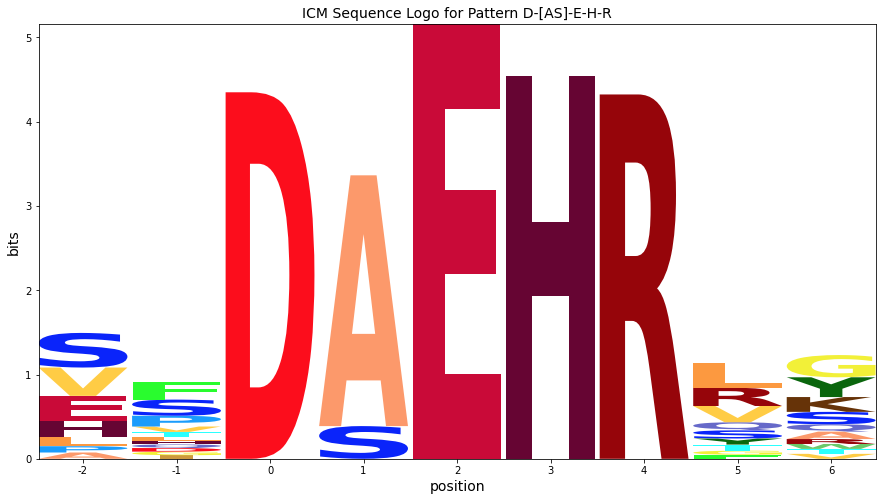

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  1806.4829545454545   0.000000e+00      0.005556   
1      5        3  1163.0275114340768  7.591287e-235      0.011111   
2      2        0  1007.1961141469338  1.543910e-201      0.016667   
3      6        4   988.4341861990814  1.561171e-197      0.022222   
4      3        1   591.7001392387098  2.844851e-113      0.027778   
5      0       -2    98.9727182900147   8.215480e-13      0.033333   
6      8        6   79.68324489020542   2.108606e-09      0.038889   
7      7        5   71.05073480246504   6.146885e-08      0.044444   
8      1       -1   66.00333845417882   4.190814e-07      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.717465475931133     S  -2.9822597720658304  
1      0.003928     H   4.104329000271422     S  -2.9822597720658313  
2      0.005891     D    3.90630975412092     S  -2.9822597720658304  
3      0.007855     R  3.8805257283506864     S  -2.9822597720658313  
4      0.009819     A  3.3540173910943287     L  -2.6150587479027623  
5      0.011783     E  2.4225044286440394     T  -2.1680124495722093  
6      0.013747     K   2.034152165974747     L   -2.399330056847326  
7      0.015710     R  1.5783691796593895     P  -2.4132242832157806  
8      0.017674     F  2.2407034792006835     A  -2.0079263826409144

----------------------------------------------------------------------
r Pattern: D-[AS]-E-x-R-S
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.076840  0.0  0.000000  0.00000  0.000000  0.768402  0.000000   
1           0.076261  0.0  0.000000  0.03813  0.038130  0.114391  0.038130   
2           0.000000  0.0  4.348314  0.00000  0.000000  0.000000  0.000000   
3           1.548723  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.00000  0.920955  0.000000  0.153493   
6           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.00000  0.000000  0.155194  0.000000   
9           0.153653  0.0  0.000000  0.00000  0.358523  0.000000  0.102435   

Amino Acid         I         K         L         M         N         P  \
Position                                                                 
0           0.000000  0.000000  0.000000  0.000000  0.422621  0.000000   
1           0.000000  0.057196  0.038130  0.000000  0.133457  0.209718   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.115119  0.115119  0.000000  0.076746  0.076746  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.206926  0.000000  0.232792  0.181060  0.000000  0.000000   
9           0.000000  0.000000  0.512176  0.000000  0.000000  0.000000   

Amino Acid         Q         R         S        T         V         W  \
Position                                                                
0           0.000000  0.000000  0.192101  0.15368  0.153680  0.000000   
1           0.000000  0.114391  0.000000  0.00000  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
3           0.000000  0.000000  1.113145  0.00000  0.000000  0.000000   
4           0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
5           0.000000  0.000000  0.153493  0.00000  0.000000  0.076746   
6           0.000000  4.322530  0.000000  0.00000  0.000000  0.000000   
7           0.000000  0.000000  3.187665  0.00000  0.000000  0.000000   
8           0.129329  0.284523  0.232792  0.00000  0.000000  0.000000   
9           0.000000  0.204870  0.102435  0.00000  0.102435  0.000000   

Amino Acid         Y  
Position              
0           0.000000  
1           0.190652  
2           0.000000  
3           0.000000  
4           0.000000  
5           0.422104  
6           0.000000  
7           0.000000  
8           0.000000  
9           0.000000

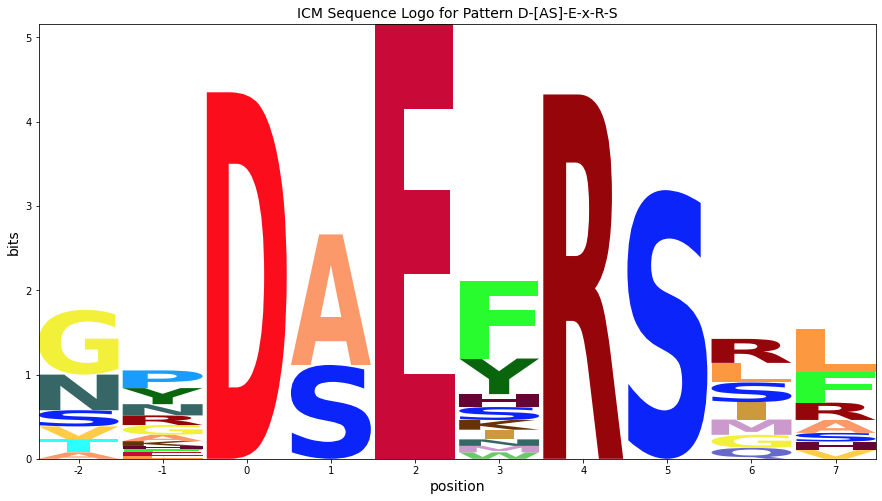

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2  1910.7031249999998   0.000000e+00         0.005   
1      2        0  1065.3035822707952  5.989562e-214         0.010   
2      6        4  1045.4592354028748  1.040543e-209         0.015   
3      7        5   446.1243889190657   1.064439e-82         0.020   
4      3        1  324.26434201205205   2.076829e-57         0.025   
5      5        3   307.4653115590908   5.890937e-54         0.030   
6      0       -2   157.0601939210034   9.441231e-24         0.035   
7      8        6  105.32644256470206   5.747850e-14         0.040   
8      9        7   75.33574769007164   1.167543e-08         0.045   
9      1       -1   74.08295774188196   1.902772e-08         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E   4.738006254371969     S  -3.0411534611193995  
1      0.003414     D  3.9268505325617564     S  -3.0411534611193995  
2      0.005121     R  3.9010665067915227     S  -3.0411534611193995  
3      0.006828     S   2.766201460938204     L  -2.6739524369563314  
4      0.008535     A  2.7849289697215758     L  -2.6739524369563314  
5      0.010243     F   3.173589283342147     L  -2.6739524369563314  
6      0.011950     G  2.3161321776964674     L  -2.4895278658189044  
7      0.013657     M  1.8403464057223617     P   -2.575953783253889  
8      0.015364     F   2.114695594288578     P  -1.9909912825327338  
9      0.017071     Y   1.810184224011719     S  -3.0411534611193995

----------------------------------------------------------------------
s Pattern: L-D-[AS]-E-x-R
Information Content Matrix


Amino Acid         A    C         D        E         F         G         H  \
Position                                                                     
0           0.102183  0.0  0.000000  0.00000  0.000000  0.255459  0.076638   
1           0.097711  0.0  0.000000  0.00000  0.083753  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
3           0.000000  0.0  4.348314  0.00000  0.000000  0.000000  0.000000   
4           2.348143  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.15947  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.00000  0.272628  0.000000  0.049569   
7           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   
9           0.000000  0.0  0.000000  0.00000  0.000000  0.000000  0.000000   

Amino Acid         I         K         L         M         N         P    Q  \
Position                                                                      
0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
1           0.041876  0.000000  0.153547  0.055835  0.000000  0.125629  0.0   
2           0.000000  0.000000  3.554866  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.173490  0.000000  0.123922  0.123922  0.000000  0.000000  0.0   
7           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
8           0.000000  0.135312  0.202967  0.372107  0.169139  0.000000  0.0   
9           0.000000  0.000000  0.277406  0.000000  0.000000  0.000000  0.0   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.204367  0.434279  0.000000  0.127729  0.000000  0.102183  
1           0.041876  0.125629  0.041876  0.000000  0.000000  0.041876  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.678353  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.074353  0.396549  0.000000  0.000000  0.000000  0.223059  
7           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.000000  0.067656  0.067656  0.338279  0.000000  0.236795  
9           0.184937  0.184937  0.000000  0.277406  0.554811  0.462343

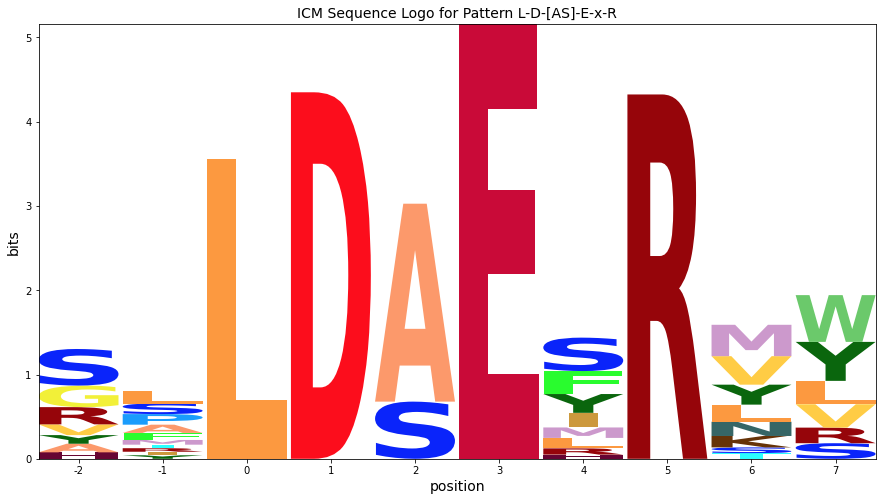

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3  2014.9232954545448   0.000000e+00         0.005   
1      3        1  1123.4110503946563  2.265745e-226         0.010   
2      7        5  1102.4842846066676  6.762594e-222         0.015   
3      2        0   623.6310516359559  5.172717e-120         0.020   
4      4        2   515.4279314528212   3.227104e-97         0.025   
5      8        6   133.6446083574503   2.969643e-19         0.030   
6      6        4   118.9192591428606   1.765728e-16         0.035   
7      9        7   91.09611325610841   2.119798e-11         0.040   
8      0       -2   81.23501413491783   1.138009e-09         0.045   
9      1       -1  49.139407787770644   1.752398e-04         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E    4.75671085330984     S   -3.097736989485766  
1      0.003414     D   3.945555131499626     S   -3.097736989485766  
2      0.005121     R  3.9197711057293927     S   -3.097736989485767  
3      0.006828     L  3.1521070840391423     S   -3.097736989485767  
4      0.008535     A   3.207513278053768     L   -2.730535965322698  
5      0.010243     M  2.5880384064816258     P  -2.4132242832157815  
6      0.011950     F   2.058112065922211     P  -2.6325373116202564  
7      0.013657     W  2.7126377989468575     P  -1.7046870973760924  
8      0.015364     R  1.3427081571674302     L  -2.5948808659651323  
9      0.017071     F  1.2805044872586588     G   -2.317193344586088

----------------------------------------------------------------------
t Pattern: P-x-D-[AS]-E-x-R
Information Content Matrix


Amino Acid         A         C         D         E         F         G  \
Position                                                                 
0           0.056042  0.000000  0.000000  0.000000  0.000000  0.028021   
1           0.140582  0.000000  0.000000  0.000000  0.160665  0.040166   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.057311  0.458487  0.000000  0.000000   
4           0.000000  0.000000  4.348314  0.000000  0.000000  0.000000   
5           2.059210  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  5.159470  0.000000  0.000000   
7           0.000000  0.060159  0.000000  0.000000  0.080211  0.000000   
8           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9           0.000000  0.000000  0.288585  0.000000  0.000000  0.104940   
10          0.000000  0.000000  0.000000  0.000000  0.103731  0.000000   

Amino Acid         H         I         K         L         M         N  \
Position                                                                 
0           0.042031  0.028021  0.000000  0.084063  0.042031  0.000000   
1           0.000000  0.000000  0.000000  0.120499  0.040166  0.000000   
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.057311  0.000000  0.257899  0.057311  0.057311   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.040106  0.160423  0.000000  0.220581  0.060159  0.080211   
8           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9           0.052470  0.000000  0.000000  0.000000  0.236115  0.000000   
10          0.000000  0.207462  0.207462  0.103731  0.000000  0.000000   

Amino Acid         P         Q         R         S         T         V  \
Position                                                                 
0           0.070052  0.000000  0.028021  0.056042  0.056042  0.028021   
1           0.000000  0.000000  0.180748  0.220914  0.040166  0.000000   
2           3.652865  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.171932  0.057311  0.000000  0.057311  0.057311  0.000000   
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.000000  0.000000  0.823684  0.000000  0.000000   
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.000000  0.180476  0.120317  0.000000  0.040106   
8           0.000000  0.000000  4.322530  0.000000  0.000000  0.000000   
9           0.000000  0.052470  0.052470  0.000000  0.367290  0.078705   
10          0.000000  0.000000  0.000000  0.881714  0.207462  0.000000   

Amino Acid         W         Y  
Position                        
0           0.000000  0.112084  
1           0.000000  0.180748  
2           0.000000  0.000000  
3           0.315210  0.000000  
4           0.000000  0.000000  
5           0.000000  0.000000  
6           0.000000  0.000000  
7           0.080211  0.000000  
8           0.000000  0.000000  
9           0.052470  0.131175  
10          0.000000  0.000000

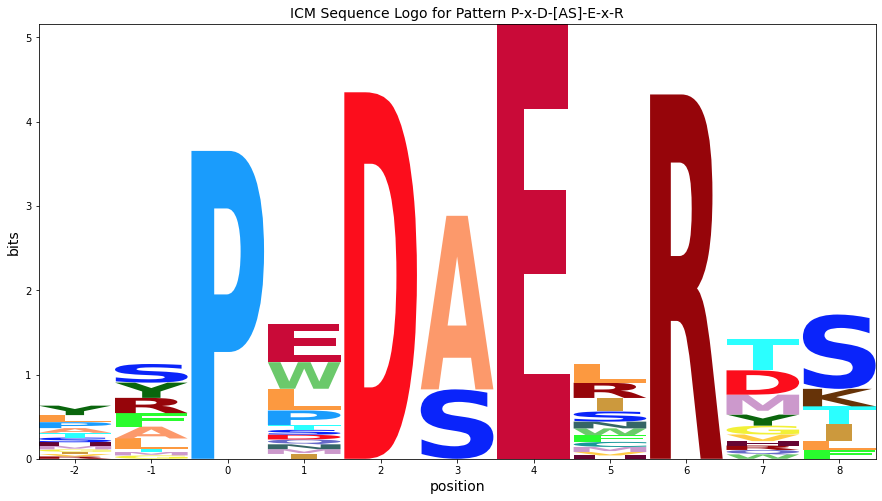

X^2 Critical Value = 38.90371889923782
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0       6        4  1945.4431818181815   0.000000e+00      0.004545   
1       4        2  1084.6727383120829  4.343366e-218      0.009091   
2       8        6  1064.4675851374725  9.037265e-214      0.013636   
3       2        0   648.3847326717824  3.032193e-125      0.018182   
4       5        3  433.18630921711207   5.351282e-80      0.022727   
5       3        1   226.4061660109765   1.783515e-37      0.027273   
6       9        7  117.36656296950802   3.439453e-16      0.031818   
7      10        8   88.52459205892683   6.049434e-11      0.036364   
8       1       -1    83.8784210810331   3.953538e-10      0.040909   
9       7        5   83.07922045897085   5.447287e-10      0.045455   
10      0       -2   37.38481553283221   7.100009e-03      0.050000   

    Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0       0.001505     E   4.744432523531401     S   -3.060262284067105  
1       0.003010     D  3.9332768017211874     S   -3.060262284067105  
2       0.004516     R  3.9074927759509555     S  -3.0602622840671043  
3       0.006021     P  3.2378274079631475     S   -3.060262284067105  
4       0.007526     A  3.0789780320334996     L   -2.693061259904037  
5       0.009031     E      2.999005350617     G  -2.2797186391674247  
6       0.010536     M  2.1816398254766547     S  -3.0217881362524692  
7       0.012041     K  1.7750011946281812     P  -2.0750555473212082  
8       0.013547     F  1.6805492720620299     P   -2.595062606201594  
9       0.015052     C  2.3815796281592254     P   -2.595062606201594  
10      0.016557     Y  1.7271284842841599     N  -1.7698430323311891

----------------------------------------------------------------------
u Pattern: D-[AS]-E-W-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.000000  0.000000  0.179255  0.112035  0.044814   
1           0.125187  0.0  0.000000  0.000000  0.000000  0.350523  0.000000   
2           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
3           1.997489  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.038356  0.0  0.153426  0.000000  0.134248  0.000000  0.230139   
8           0.058955  0.0  0.000000  0.039303  0.000000  0.039303  0.098259   

Amino Acid         I        K         L         M         N         P    Q  \
Position                                                                     
0           0.000000  0.00000  0.268883  0.000000  0.000000  0.089628  0.0   
1           0.000000  0.00000  0.000000  0.175262  0.175262  0.000000  0.0   
2           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0   
3           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0   
4           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0   
5           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0   
6           0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.0   
7           0.000000  0.00000  0.153426  0.134248  0.038356  0.000000  0.0   
8           0.039303  0.11791  0.157214  0.000000  0.000000  0.196517  0.0   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.134442  0.224069  0.044814  0.000000  0.000000  0.000000  
1           0.000000  0.100149  0.200299  0.000000  0.125187  0.100149  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.856067  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  5.262835  0.000000  
6           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.095891  0.038356  0.000000  0.095891  0.038356  0.000000  
8           0.275124  0.000000  0.039303  0.000000  0.078607  0.000000

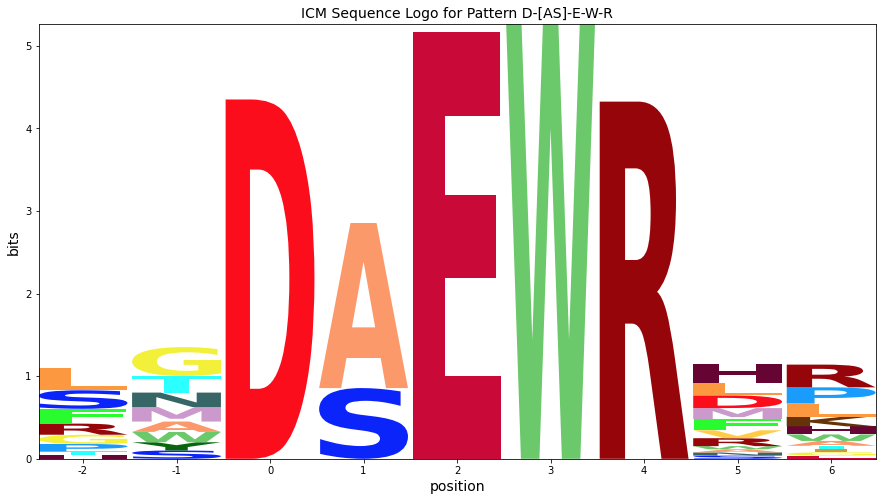

X^2 Critical Value = 38.22495539122972
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      4        2   2084.403409090909   0.000000e+00      0.005556   
1      5        3  2243.6813794682025   0.000000e+00      0.011111   
2      2        0  1162.1493624772313  1.170091e-234      0.016667   
3      6        4  1140.5009840758635  5.009723e-230      0.022222   
4      3        1  449.71421354236594   1.892561e-83      0.027778   
5      1       -1  101.20186354554012   3.242847e-13      0.033333   
6      7        5  100.71037698695629   3.981856e-13      0.038889   
7      8        6   96.18873514999397   2.608030e-12      0.044444   
8      0       -2   69.27669937026606   1.212697e-07      0.050000   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001964     E   4.768279265485771     S    -3.13426286551088  
1      0.003928     W   4.871644124182861     S  -3.1342628655108817  
2      0.005891     D   3.957123543675557     S    -3.13426286551088  
3      0.007855     R  3.9313395179053234     S   -3.134262865510881  
4      0.009819     A   3.073690200673739     L   -2.767061841347812  
5      0.011783     M   1.859711730589293     L  -2.6545871120894002  
6      0.013747     H  1.9248451704042644     P  -2.6690631876453703  
7      0.015710     R  1.9440186519760703     S   -3.097736989485767  
8      0.017674     F  1.8199523287274468     A   -2.139170915919166

----------------------------------------------------------------------
v Pattern: D-[AS]-E-x-R-L
Information Content Matrix


Amino Acid         A    C         D         E         F        G         H  \
Position                                                                     
0           0.203301  0.0  0.000000  0.000000  0.087129  0.00000  0.522774   
1           0.178732  0.0  0.000000  0.035746  0.023831  0.00000  0.023831   
2           0.000000  0.0  4.348314  0.000000  0.000000  0.00000  0.000000   
3           2.548322  0.0  0.000000  0.000000  0.000000  0.00000  0.000000   
4           0.000000  0.0  0.000000  5.159470  0.000000  0.00000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.069136  0.00000  0.276542   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.000000   
8           0.057920  0.0  0.193067  0.000000  0.000000  0.17376  0.000000   
9           0.000000  0.0  0.000000  0.000000  0.000000  0.00000  0.508360   

Amino Acid    I    K         L         M         N        P    Q         R  \
Position                                                                     
0           0.0  0.0  0.058086  0.000000  0.000000  0.00000  0.0  0.087129   
1           0.0  0.0  0.071493  0.035746  0.083408  0.00000  0.0  0.000000   
2           0.0  0.0  0.000000  0.000000  0.000000  0.00000  0.0  0.000000   
3           0.0  0.0  0.000000  0.000000  0.000000  0.00000  0.0  0.000000   
4           0.0  0.0  0.000000  0.000000  0.000000  0.00000  0.0  0.000000   
5           0.0  0.0  0.345678  0.000000  0.000000  0.00000  0.0  0.345678   
6           0.0  0.0  0.000000  0.000000  0.000000  0.00000  0.0  4.322530   
7           0.0  0.0  3.554866  0.000000  0.000000  0.00000  0.0  0.000000   
8           0.0  0.0  0.115840  0.000000  0.000000  0.05792  0.0  0.038613   
9           0.0  0.0  0.564844  0.000000  0.000000  0.00000  0.0  0.000000   

Amino Acid         S         T         V         W         Y  
Position                                                      
0           0.319473  0.000000  0.000000  0.000000  0.522774  
1           0.238309  0.131070  0.095324  0.000000  0.000000  
2           0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.582474  0.000000  0.000000  0.000000  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.046090  0.000000  0.184362  0.714401  
6           0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.057920  0.096533  0.057920  0.038613  0.000000  
9           0.000000  0.169453  0.451875  0.282422  0.000000

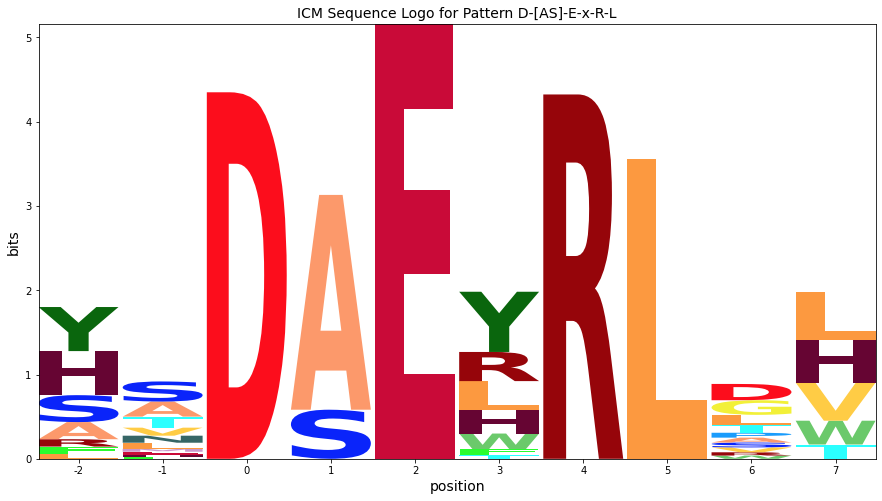

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      2        0  1665.7474195506984   0.000000e+00         0.005   
1      4        2  2987.6448863636356   0.000000e+00         0.010   
2      6        4  1634.7180771754045   0.000000e+00         0.015   
3      7        5   924.6943179429694  6.149467e-184         0.020   
4      3        1   833.5890453152522  1.549135e-164         0.025   
5      5        3  335.43120767496686   1.039308e-59         0.030   
6      0       -2   222.8104753429063   9.408740e-37         0.035   
7      9        7  114.35275427053627   1.249557e-15         0.040   
8      1       -1   79.44672905445506   2.315829e-09         0.045   
9      8        6   57.98080393346792   8.037954e-06         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     D   4.063337342285561     S  -3.5402552251867188  
1      0.003414     E   4.874493064095775     S  -3.5402552251867188  
2      0.005121     R   4.037553316515329     S  -3.5402552251867188  
3      0.006828     L   3.269889294825078     S  -3.5402552251867188  
4      0.008535     A  3.3911802058004854     L  -3.1730542010236498  
5      0.010243     Y   2.851650841307103     S  -3.5402552251867188  
6      0.011950     Y  2.4699468046958035     P  -2.7046870973760924  
7      0.013657     H   2.086901928513237     S   -2.593694484148179  
8      0.015364     A   1.369440698671875     P  -2.9470479349451364  
9      0.017071     D  1.7633518002788762     N  -1.7918693386611881

----------------------------------------------------------------------
w Pattern: S-D-[AS]-E-x-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.097981  0.000000  0.000000  0.000000  0.065321   
1           0.000000  0.0  0.194926  0.000000  0.000000  0.000000  0.116956   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
4           2.392559  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.548868  0.000000  0.259990   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
8           0.390914  0.0  0.111690  0.000000  0.000000  0.055845  0.000000   
9           0.000000  0.0  0.000000  0.120081  0.000000  0.000000  0.000000   

Amino Acid         I    K         L    M         N         P    Q         R  \
Position                                                                      
0           0.489905  0.0  0.000000  0.0  0.065321  0.228622  0.0  0.228622   
1           0.000000  0.0  0.194926  0.0  0.000000  0.077970  0.0  0.000000   
2           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
3           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
4           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
5           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
6           0.086663  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.491092   
7           0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.0  4.322530   
8           0.055845  0.0  0.558449  0.0  0.111690  0.000000  0.0  0.083767   
9           0.600406  0.0  0.000000  0.0  0.120081  0.000000  0.0  0.000000   

Amino Acid         S         T         V         W         Y  
Position                                                      
0           0.000000  0.163302  0.065321  0.000000  0.097981  
1           0.311882  0.077970  0.000000  0.000000  1.013615  
2           3.187665  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.000000  0.000000  0.000000  0.000000  
4           0.656781  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.000000  0.000000  0.000000  0.000000  
6           0.115551  0.057776  0.000000  0.115551  0.202214  
7           0.000000  0.000000  0.000000  0.000000  0.000000  
8           0.000000  0.083767  0.000000  0.000000  0.000000  
9           0.420284  0.000000  0.180122  0.120081  0.240162

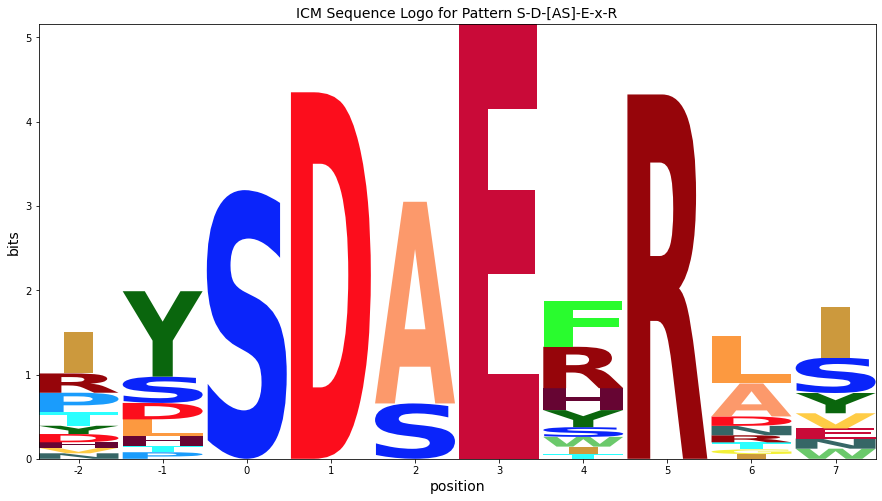

X^2 Critical Value = 38.58225655493424
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0      5        3   2258.103693181817   0.000000e+00         0.005   
1      3        1  1258.9951426836676  2.154813e-255         0.010   
2      7        5  1235.5427327488521  2.273708e-250         0.015   
3      4        2   589.2633890384525  9.289922e-113         0.020   
4      2        0   527.2379141770778   1.065633e-99         0.025   
5      1       -1  299.26780686127114   2.826048e-52         0.030   
6      6        4  237.65520902561337   9.681601e-40         0.035   
7      0       -2  140.56674220767653   1.422336e-20         0.040   
8      8        6     118.60874451759   2.017814e-16         0.045   
9      9        7  104.24398088677431   9.062535e-14         0.050   

   Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0      0.001707     E  4.7944732060309985     S    -3.22172570676122  
1      0.003414     D   3.983317484220785     S    -3.22172570676122  
2      0.005121     R  3.9575334584505515     S   -3.221725706761221  
3      0.006828     A  3.2604023228623937     L   -2.854524682598152  
4      0.008535     S   2.822668412597233     L  -2.8545246825981527  
5      0.010243     Y   3.184711678529089     G   -2.181538245228521  
6      0.011950     F   2.671088942812964     L  -2.8545246825981527  
7      0.013657     I  2.6963799538497417     S  -2.8567288899819725  
8      0.015364     L  1.7772586748759973     S  -2.9822597720658313  
9      0.017071     I   2.556349502070767     L  -2.0889899362351763

----------------------------------------------------------------------
x Pattern: L-x-D-[AS]-E-x-R
Information Content Matrix


Amino Acid         A    C         D         E         F         G         H  \
Position                                                                      
0           0.000000  0.0  0.144811  0.000000  0.048270  0.000000  0.000000   
1           0.000000  0.0  0.049013  0.000000  0.081689  0.277741  0.147039   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.062349  0.0  0.000000  0.000000  0.166264  0.083132  0.041566   
4           0.000000  0.0  4.348314  0.000000  0.000000  0.000000  0.000000   
5           2.049739  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  5.159470  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.000000  0.000000  0.300471  0.000000  0.064387   
8           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
9           0.062234  0.0  0.062234  0.311168  0.404518  0.000000  0.000000   
10          0.000000  0.0  0.000000  0.098614  0.493070  0.000000  0.000000   

Amino Acid         I    K         L         M         N         P         Q  \
Position                                                                      
0           0.193081  0.0  0.241352  0.217217  0.120676  0.000000  0.000000   
1           0.000000  0.0  0.000000  0.000000  0.049013  0.196053  0.032675   
2           0.000000  0.0  3.554866  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.228613  0.103915  0.498792  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
5           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
6           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
7           0.000000  0.0  0.128773  0.064387  0.042924  0.000000  0.000000   
8           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
9           0.093350  0.0  0.062234  0.155584  0.000000  0.000000  0.000000   
10          0.147921  0.0  0.000000  0.000000  0.000000  0.640991  0.000000   

Amino Acid         R         S         T         V         W         Y  
Position                                                                
0           0.000000  0.120676  0.000000  0.072406  0.000000  0.096541  
1           0.032675  0.147039  0.000000  0.000000  0.000000  0.065351  
2           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3           0.000000  0.103915  0.041566  0.000000  0.041566  0.000000  
4           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5           0.000000  0.828618  0.000000  0.000000  0.000000  0.000000  
6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7           0.257546  0.214622  0.042924  0.000000  0.257546  0.042924  
8           4.322530  0.000000  0.000000  0.000000  0.000000  0.000000  
9           0.093350  0.000000  0.000000  0.124467  0.000000  0.311168  
10          0.246535  0.000000  0.000000  0.000000  0.197228  0.098614

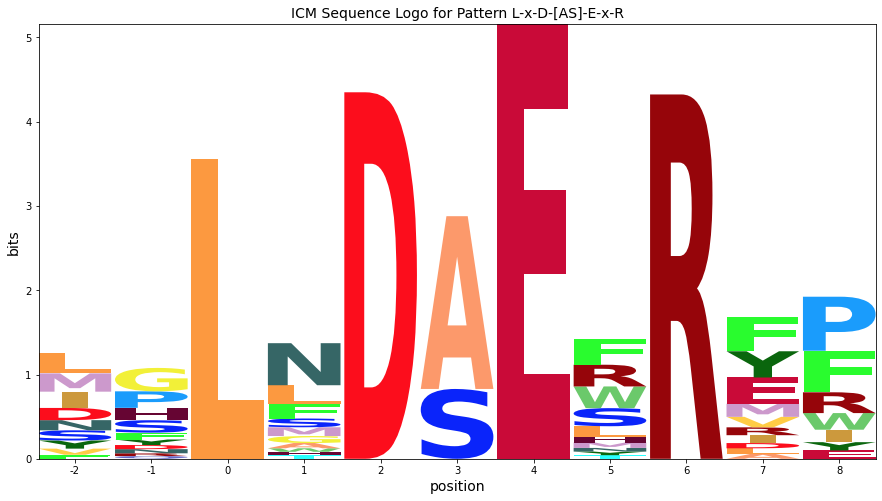

X^2 Critical Value = 38.90371889923782
Chi Square Tests


index Position                 X^2        p-value  Critical pBH  \
0       6        4  2292.8437499999995   0.000000e+00      0.004545   
1       4        2  1278.3642987249546  1.526585e-259      0.009091   
2       8        6  1254.5510824834496  1.929267e-254      0.013636   
3       2        0   709.6491277236742  3.240805e-138      0.018182   
4       5        3   508.0957776093344   1.117614e-95      0.022727   
5       3        1   174.7918051920628   3.268608e-27      0.027273   
6       7        5   173.2036020015919   6.698215e-27      0.031818   
7       9        7   173.0492476804457   7.181687e-27      0.036364   
8      10        8  125.77844197931172   9.135031e-18      0.040909   
9       0       -2   95.80626139667419   3.054988e-12      0.045455   
10      1       -1   94.38360647929409   5.495942e-12      0.050000   

    Critical pBY AAmax             PWMSmax AAmin              PWMSmin  
0       0.001505     E    4.79929445856592     S   -3.238599525325617  
1       0.003010     D  3.9881387367557064     S   -3.238599525325618  
2       0.004516     R   3.962354710985474     S   -3.238599525325617  
3       0.006021     L   3.194690689295223     S   -3.238599525325617  
4       0.007526     A    3.12805128687806     L   -2.871398501162549  
5       0.009031     N   2.470116215769892     P  -2.7733998474601065  
6       0.010536     W  2.5370098449463314     P  -2.7733998474601065  
7       0.012041     E  2.4094482758185936     S  -3.0217881362524683  
8       0.013547     F   2.335340353338759     S    -2.69497781998536  
9       0.015052     M  2.2211681896632927     P  -2.5170600942003207  
10      0.016557     G  1.7118691210163752     L   -2.871398501162549

In [ ]:
begin_parse = False
pattern = ''

with open(file_name, 'r') as f:
  while True:
    line = f.readline().strip()

    # Stop reading the file
    if line == 'PATTERN MATCHES:':
      break

    if begin_parse:
      tokens = line.split() # Split line into array of tokens
      if len(tokens) >= 5:
        # Process each array (line of file)
        if len(tokens[0]) == 1:
          pattern = tokens[5]
          print('-' * 70)
          print('{} Pattern: {}'.format(tokens[0], pattern))
        elif len(tokens) >= 6:
          if tokens[0].startswith('Abeta'):
            continue
          else:
            label = tokens[0].split('_')
            last_num = label[len(label) - 1]
            obs_freq.append(int(last_num))
          if len(tokens) == 6:
            if tokens[4][:1].isupper():
              pattern_seq = tokens[4]
              flank2 = tokens[5]
              flank1_seq_list.append('')
              pattern_seq_list.append(pattern_seq.upper())
              flank2_seq_list.append(flank2)
            else:
              flank1 = tokens[4]
              pattern_seq = tokens[5]
              flank1_seq_list.append(flank1)
              pattern_seq_list.append(pattern_seq.upper())
              flank2_seq_list.append('')
          elif len(tokens) == 7:
            flank1 = tokens[4]
            pattern_seq = tokens[5]
            flank2 = tokens[6]
            flank1_seq_list.append(flank1)
            pattern_seq_list.append(pattern_seq.upper())
            flank2_seq_list.append(flank2)
      # Reached end of a pattern block
      elif len(tokens) == 0 and len(flank1_seq_list) != 0:
        # Begin frequency analysis for pattern block
        padded1 = pad_sequence(flank1_seq_list, 'left', positions)
        padded2 = pad_sequence(flank2_seq_list, 'right', positions)
        combined_sequences = [x + pattern_seq_list[i] + padded2[i] for (i, x) in enumerate(padded1)]
        # Calculate matrices
        freq = frequency_matrix(combined_sequences)
        prob = probability_matrix(freq, 0)
        if norm_ppm:
          prob = transform_matrix(prob, 'normalize')
        prob_pseudo = probability_matrix(freq)
        weight = weight_matrix(prob_pseudo)
        if cent_pwm:
          weight = transform_matrix(weight, 'center')
        info = info_content_matrix(prob)
        # Display outputs
        display_output(freq, prob, weight, info, pattern)
        # Statistical analysis
        chi_square_critical_val(combined_sequences[0])
        chi_square_test(freq)
        # Clear data structures for next pattern block
        x_axis.clear()
        obs_freq.clear()
        flank1_seq_list.clear()
        flank2_seq_list.clear()
        pattern_seq_list.clear()

    # Start processing lines after this line is reached
    if line == 'Best patterns with alignments:':
      f.readline()
      begin_parse = True